<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/adidas/adidas_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ADSDEEUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-28 11:36:58,515 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-28 11:36:58,516 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for ADSDEEUR
2019-08-28 11:40:09,458 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-28 11:47:34,313 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-28 11:51:00,114 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-28 11:54:46,488 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-28 11:58:27,941 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-28 12:01:46,581 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-28 12:05:25,458 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-28 12:09:15,635 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-28 12:20:26,201 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_442__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_ADSDEEUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-ADSDEEUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-ADSDEEUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close     Volume
Date                                                              
2018-01-02 08:00:00  1.67127  1.67635  1.65877  1.66297  44.832031
2018-01-02 09:00:00  1.66297  1.66838  1.65347  1.65698  21.013353
2018-01-02 10:00:00  1.65697  1.66498  1.65597  1.66248  13.846867
2018-01-02 11:00:00  1.66247  1.66798  1.66147  1.66238   9.990114
2018-01-02 12:00:00  1.66248  1.66548  1.65897  1.65897   7.703498
...                      ...      ...      ...      ...        ...
2018-12-28 08:00:00  1.79788  1.83148  1.79788  1.83047  62.036545
2018-12-28 09:00:00  1.83048  1.83648  1.82247  1.82647  47.282406
2018-12-28 10:00:00  1.82648  1.82898  1.82297  1.82498  39.419899
2018-12-28 11:00:00  1.82497  1.83448  1.82097  1.82498  38.986149
2018-12-28 12:00:00  1.82497  1.82798  1.81697  1.82548  32.644234

[2244 rows x 5 columns]

Open         High          Low        Close       Volume
count  2244.000000  2244.000000  2244.000000  2244.000000  2244.000000
mean      1.944211     1.950600     1.937937     1.944220    26.723314
std       0.122097     0.122286     0.121943     0.122118    24.378326
min       1.655470     1.659970     1.652280     1.655480     0.041940
25%       1.854470     1.861353     1.846970     1.854705    10.298722
50%       1.950970     1.957480     1.944970     1.951225    19.526580
75%       2.046970     2.053980     2.039970     2.047970    34.098777
max       2.176970     2.178980     2.173970     2.176980   192.445175

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close      Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
2018-01-09 13:00:00  1.69578  1.70128  1.69227  1.69378   90.058998    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  1.708173  1.699037 -1.727003  1.700060  1.709226  1.701646    1.711380    1.712070  1.729158  1.712965  1.694186  1.713463  1.706836  1.712965  1.699643  1.721683                1.737644                 1.712965                1.688286                1.749984                 1.712965                1.675946                1.762323                 1.712965                1.663607                1.774663                 1.712965                1.651267  1.709226  1.699056  1.721844                1.733905                 1.709226                1.684547                1.746245                 1.709226                1.672207                1.758584                 1.709226                1.659868                1.770924                 1.709226   
2018-01-09 14:00:00  1.69378  1.69888  1.69228  1.69378  105.674995    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  1.707454  1.699248 -1.722140  1.695995  1.705794  1.698150    1.711125    1.712070  1.726207  1.708565  1.690933  1.708528  1.702573  1.708565  1.693780  1.720329                1.732802                 1.708565                1.684328                1.744920                 1.708565                1.672210                1.757038                 1.708565                1.660092                1.769156                 1.708565                1.647974  1.705794  1.694571  1.720110                1.730030                 1.705794                1.681557                1.742148                 1.705794                1.669439                1.754267                 1.705794                1.657321                1.766385                 1.705794   
2018-01-09 15:00:00  1.69378  1.69538  1.68828  1.69277  103.739998    9          1          9             31   

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000    2194.000000  2194.000000   2194.000000     2194.000000       2194.000000  2194.000000  2194.000000  2194.000000  2194.000000   2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000  2194.000000  2194.000000  2194.000000             2194.000000              2194.000000             2194.000000             2194.000000              2194.000000             2194.000000             2194.000000   
mean      1.949809     1.956246     1.943486     1.949827    26.856043    15.970830     2.033273   184.190975      30.415679    11.379672      0.032361        0.024157          0.004102     6.557429     2.521422    26.879672     2.033273      1.990428    26.879672     1.949780     1.949003     0.087307     1.949807     1.949653     1.949373     1.949525     1.949452     1.948514     1.949644     1.949805     1.949640     1.949699     1.949644     1.949870     1.949346                1.969084                 1.949644                1.930205                1.978803                 1.949644                1.920486                1.988523                 1.949644                1.910766                1.998242                 1.949644                1.901046     1.949653     1.949814     1.949395                1.969093                 1.949653                1.930214                1.978812                 1.949653                1.920495                1.988532   
std       0.117581     0.117680     0.117521     0.117586    24.548466     8.550489     1.408166   101.467016       0.857599     2.622184      0.176997        0.153571          0.063931     3.340753     1.100821    14.495124     1.408166      1.400085    14.495124     0.117218     0.116204     1.949680     0.117881     0.116915     0.116947     0.117003     0.117002     0.118335     0.117242     0.117770     0.117384     0.117255     0.117242     0.117523     0.116563                0.117395                 0.117242                0.118843                0.118129                 0.117242                0.120282                0.119294                 0.117242                0.122128                0.120875                 0.117242                0.124363     0.116915     0.117414     0.116654                0.117152                 0.116915                0.118437                0.117930                 0.116915                0.119840                0.119137   
min       1.660370     1.663270     1.657270     1.660370     0.041940     1.000000     0.000000     9.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.068544  0.073704  0.067738  0.064672  0.467856    9          1          9             31    13             0               0                 0      1        1     2        1             0           2  0.081173  0.037404  0.104345  0.077083  0.083196  0.067779    0.090177    0.091189  0.137794  0.094044  0.066279  0.097365  0.082688  0.094044  0.075737  0.096697                0.123648                 0.094044                0.137113                0.130088                 0.094044                0.217447                0.129511                 0.094044                0.282657                0.129046                 0.094044                0.338846  0.083196  0.073215  0.099324                0.114360                 0.083196                0.093424                0.117861                 0.083196                0.178925                0.118592                 0.083196                0.251166                0.118649                 0.083196   
2018-01-09 14:00:00  0.064673  0.069050  0.067757  0.064672  0.549019    9          1          9             31    14             0               0                 0      1        1     2        1             0           2  0.079755  0.037838  0.105467  0.069218  0.076351  0.060846    0.089670    0.091189  0.132137  0.085327  0.060003  0.087667  0.074284  0.085327  0.064372  0.093908                0.114333                 0.085327                0.129848                0.121025                 0.085327                0.211310                0.121070                 0.085327                0.277435                0.121107                 0.085327                0.334395  0.076351  0.064492  0.095770                0.106761                 0.076351                0.087665                0.110626                 0.076351                0.174159                0.111777                 0.076351                0.247219                0.112203                 0.076351   
2018-01-09 15:00:00  0.064673  0.062264  0.060016  0.062717  0.538962    9          1          9         

139850

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcymoz48e
  JVM stdout: /tmp/tmpcymoz48e/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcymoz48e/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_rwi9gf
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.820853  0.528416              0.246097  0.423438  0.179299
1  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.818098  0.525220              0.271809  0.421537  0.177693
2  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.813423  0.533235              0.253444  0.422659  0.178641
3  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.812505  0.537404              0.329201  0.429012  0.184051
4  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.808331  0.536374              0.274105  0.426438  0.181849
5  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.798105  0.554838              0.263085  0.435123  0.189332
6  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.793806  0.585852              0.275482  0.446211  0.199104
7  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.787545  1.238123              0.267677  0.493508  0.243550
8              DeepLearning_1_AutoML_20190828_123115  0.768470  0.597478              0.299816  0.447278  0.200057
9  DeepLearning_grid_1_AutoML_20190828_123115_mod...  0.756407  1.072290              0.300735  0.544952  0.296972

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.008521
1           CDLCLOSINGMARUBOZU             0.571896           0.571896    0.004873
2                  CDLLONGLINE             0.556469           0.556469    0.004742
3                          DIV             0.478100           0.478100    0.004074
4                          SUB             0.462677           0.462677    0.003942
...                        ...                  ...                ...         ...
1031  BBANDS_middleband_14_0_5             0.089752           0.089752    0.000765
1032    BBANDS_lowerband_8_7_2             0.089369           0.089369    0.000762
1033        CDLSEPARATINGLINES             0.089090           0.089090    0.000759
1034   BBANDS_middleband_8_5_3             0.087721           0.087721    0.000747
1035  BBANDS_middleband_30_7_3             0.087401           0.087401    0.000745

[1036 rows x 4 columns]

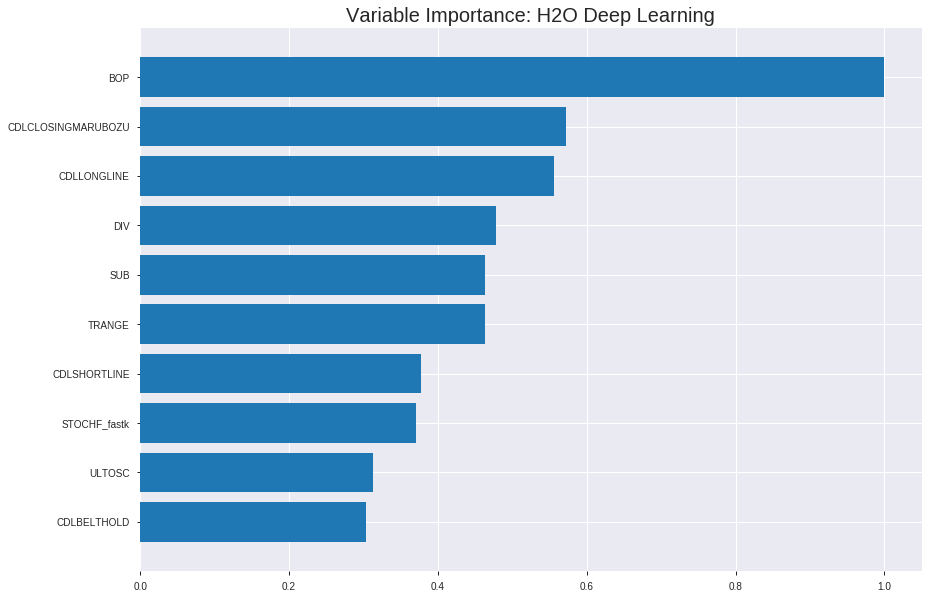

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_123115_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18372055360961473
RMSE: 0.42862635664365617
LogLoss: 0.5444390349096628
Mean Per-Class Error: 0.26537307549856104
AUC: 0.8157677448292031
pr_auc: 0.7972572012751087
Gini: 0.6315354896584062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42504014572482324: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      480  309  0.3916   (309.0/789.0)
1      114  632  0.1528   (114.0/746.0)
Total  594  941  0.2756   (423.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42504      0.749259  230
max f2                       0.317058     0.851596  290
max f0point5                 0.482059     0.742652  186
max accuracy                 0.469099     0.734853  198
max precision                0.989735     1         0
max recall                   0.0441683    1         385
max specificity              0.989735     1         0
max absolute_mcc             0.434522     0.473589  223
max min_per_class_accuracy   0.464138     0.731903  202
max mean_per_class_accuracy  0.466474     0.734627  200

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 46.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.974847           1.80044   1.80044            0.875            0.984562   0.875                       0.984562            0.0187668       0.0187668                  80.0436   80.0436
    2        0.0201954                   0.951639           2.05764   1.92489            1                0.964055   0.935484                    0.974639            0.0201072       0.038874                   105.764   92.489
    3        0.0306189                   0.930875           2.05764   1.97008            1                0.943197   0.957447                    0.963935            0.0214477       0.0603217                  105.764   97.0082
    4        0.0403909                   0.912379           1.92046   1.95808            0.933333         0.921313   0.951613                    0.953623            0.0187668       0.0790885                  92.0465   95.8077
    5        0.0501629                   0.886795           1.92046   1.95075            0.933333         0.899749   0.948052                    0.943129            0.0187668       0.0978552                  92.0465   95.075
    6        0.100326                    0.799717           1.81714   1.88394            0.883117         0.845581   0.915584                    0.894355            0.0911528       0.189008                   81.7137   88.3944
    7        0.150489                    0.690087           1.84386   1.87058            0.896104         0.743628   0.909091                    0.844112            0.0924933       0.281501                   84.386    87.0583
    8        0.2                         0.600574           1.73275   1.83646            0.842105         0.639424   0.892508                    0.79344             0.0857909       0.367292                   73.275    83.6461
    9        0.300326                    0.504532           1.25596   1.64254            0.61039          0.544032   0.798265                    0.710124            0.126005        0.493298                   25.5963   64.2542
    10       0.4                         0.481368           1.439     1.59182            0.699346         0.489513   0.773616                    0.655151            0.143432        0.636729                   43.9004   59.1823
    11       0.500326                    0.462535           0.988736  1.47089            0.480519         0.473335   0.714844                    0.618693            0.0991957       0.735925                   -1.12635  47.0892
    12       0.6                         0.4287             0.98175   1.38963            0.477124         0.446729   0.675353                    0.590126            0.0978552       0.83378                    -1.82498  38.9634
    13       0.699674                    0.385332           0.699329  1.29129            0.339869         0.409527   0.627561                    0.564398            0.0697051       0.903485                   -30.0671  29.1294
    14       0.8                         0.308172           0.561175  1.19973            0.272727         0.348752   0.583062                    0.537354            0.0563003       0.959786                   -43.8825  19.9732
    15       0.899674                    0.161051           0.242075  1.09363            0.117647         0.240893   0.531499                    0.50451             0.0241287       0.983914                   -75.7925  9.36338
    16       1                           0.000836071        0.160336  1                  0.0779221        0.0839455  0.485993                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20059244664691855
RMSE: 0.4478754811852492
LogLoss: 0.5854160051167502
Mean Per-Class Error: 0.2869218567373518
AUC: 0.7809838871263983
pr_auc: 0.791230300875341
Gini: 0.5619677742527966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42403471373157353: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  103  0.4858   (103.0/212.0)
1      29   197  0.1283   (29.0/226.0)
Total  138  300  0.3014   (132.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424035     0.749049  261
max f2                       0.122485     0.851064  373
max f0point5                 0.495425     0.740506  138
max accuracy                 0.473018     0.714612  208
max precision                0.977264     1         0
max recall                   0.0304862    1         395
max specificity              0.977264     1         0
max absolute_mcc             0.495425     0.432657  138
max min_per_class_accuracy   0.479058     0.688679  192
max mean_per_class_accuracy  0.473018     0.713078  208

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 45.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.940015           1.93805   1.93805            1                0.95434   1                           0.95434             0.0221239       0.0221239                  93.8053   93.8053
    2        0.0205479                   0.923891           1.45354   1.72271            0.75             0.933469  0.888889                    0.945064            0.0132743       0.0353982                  45.354    72.2714
    3        0.0319635                   0.903964           1.93805   1.79962            1                0.913908  0.928571                    0.933937            0.0221239       0.0575221                  93.8053   79.9621
    4        0.0410959                   0.888776           1.93805   1.83038            1                0.897828  0.944444                    0.925913            0.0176991       0.0752212                  93.8053   83.0383
    5        0.0502283                   0.847047           1.93805   1.84996            1                0.873226  0.954545                    0.916333            0.0176991       0.0929204                  93.8053   84.996
    6        0.100457                    0.709493           1.67377   1.76187            0.863636         0.782138  0.909091                    0.849235            0.0840708       0.176991                   67.3773   76.1866
    7        0.150685                    0.60648            1.93805   1.8206             1                0.651317  0.939394                    0.783262            0.0973451       0.274336                   93.8053   82.0595
    8        0.200913                    0.545557           1.23331   1.67377            0.636364         0.573108  0.863636                    0.730724            0.0619469       0.336283                   23.3307   67.3773
    9        0.30137                     0.499998           1.49759   1.61504            0.772727         0.519766  0.833333                    0.660405            0.150442        0.486726                   49.7586   61.5044
    10       0.422374                    0.483707           1.02388   1.44568            0.528302         0.488606  0.745946                    0.611187            0.123894        0.610619                   2.38771   44.5683
    11       0.5                         0.479387           0.969027  1.37168            0.5              0.481532  0.707763                    0.591058            0.0752212       0.685841                   -3.09735  37.1681
    12       0.600457                    0.466061           0.969027  1.30432            0.5              0.473572  0.673004                    0.571402            0.0973451       0.783186                   -3.09735  30.4317
    13       0.69863                     0.408126           0.90142   1.2477             0.465116         0.442024  0.643791                    0.553222            0.0884956       0.871681                   -9.858    24.7701
    14       0.799087                    0.30269            0.572607  1.16283            0.295455         0.36181   0.6                         0.529158            0.0575221       0.929204                   -42.7393  16.2832
    15       0.899543                    0.191461           0.440467  1.08216            0.227273         0.244361  0.558376                    0.497354            0.0442478       0.973451                   -55.9533  8.21616
    16       1                           0.011626           0.26428   1                  0.136364         0.107016  0.515982                    0.458142          


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:58:50  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:58:53  8 min 20.492 sec   148 obs/sec       0.29772   1             457        0.662995         2.77245             -0.759632      0.531831        0.409697           1.41463          0.478827                         0.614288           1.15408               -0.510943        0.629759          0.632674             1.55044            0.452055
    2019-08-28 12:59:49  9 min 16.321 sec   198 obs/sec       6.94072   25            10654      0.483986         0.661208            0.062295       0.717962        0.702937           2.05764          0.373941                         0.493048           0.679278              0.0266211        0.705262          0.711591             1.93805            0.394977
    2019-08-28 13:00:43  10 min 10.293 sec  204 obs/sec       13.6612   49            20970      0.454797         0.599478            0.171989       0.771467        0.750896           1.92904          0.357655                         0.465577           0.62302               0.132065         0.757399          0.755627             1.55044            0.321918
    2019-08-28 13:01:35  11 min  1.622 sec  210 obs/sec       20.372    73            31271      0.42876          0.545968            0.264081       0.80324         0.789132           1.92904          0.288599                         0.450338           0.591487              0.187954         0.780577          0.788756             1.93805            0.308219
    2019-08-28 13:02:26  11 min 53.327 sec  215 obs/sec       27.4326   98            42109      0.43333          0.553842            0.248309       0.791815        0.779358           1.92904          0.317915                         0.455589           0.601102              0.168907         0.758088          0.761882             1.55044            0.296804
    2019-08-28 13:03:20  12 min 46.776 sec  219 obs/sec       34.7368   124           53321      0.428626         0.544439            0.264541       0.815768        0.797257           1.80044          0.27557                          0.447875           0.585416              0.19681          0.780984          0.79123              1.93805            0.30137
    2019-08-28 13:04:14  13 min 40.533 sec  222 obs/sec       42.3583   151           65020      0.426585         0.539533            0.27153        0.806824        0.79379            1.92904          0.287296                         0.456741           0.605362              0.164696         0.786557          0.798535             1.93805            0.305936
    2019-08-28 13:05:04  14 min 30.627 sec  225 obs/sec       49.4352   176           75883      0.435534         0.558268            0.240646       0.817932        0.809695           2.05764          0.27557                          0.451923           0.594082              0.182228         0.778824          0.788211             1.93805            0.312785
    2019-08-2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.008520899950060485
CDLCLOSINGMARUBOZU        0.5718958973884583     0.5718958973884583   0.00487306772349711
CDLLONGLINE               0.556469202041626      0.556469202041626    0.004741618395886688
DIV                       0.478099524974823      0.478099524974823    0.004073838218481911
SUB                       0.4626767039299011     0.4626767039299011   0.003942421903410444
---                       ---                    ---                  ---
BBANDS_middleband_14_0_5  0.08975239843130112    0.08975239843130112  0.0007647712073110824
BBANDS_lowerband_8_7_2    0.08936866372823715    0.08936866372823715  0.0007615014422989083
CDLSEPARATINGLINES        0.08908993750810623    0.08908993750810623  0.0007591264440637141
BBANDS_middleband_8_5_3   0.08772145211696625    0.08772145211696625  0.0007474657169626909
BBANDS_middleband_30_7_3  0.08740074187517166    0.08740074187517166  0.0007447329770793995


See the whole table with table.as_data_frame()


('accuracy', 0.7636363636363637)

('F1', 0.7477477477477478)

('auc', 0.8208531596961348)

('logloss', 0.5284158252776675)

('mean_per_class_error', 0.23875114784205698)

('rmse', 0.42343765630990127)

('mse', 0.1792994487812221)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


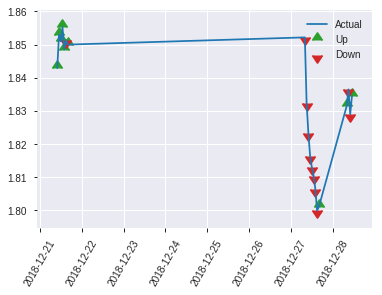


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1792994487812221
RMSE: 0.42343765630990127
LogLoss: 0.5284158252776675
Mean Per-Class Error: 0.23875114784205698
AUC: 0.8208531596961348
pr_auc: 0.7829899611154036
Gini: 0.6417063193922696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3972776670586507: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   40   0.3306   (40.0/121.0)
1      16   83   0.1616   (16.0/99.0)
Total  97   123  0.2545   (56.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397278     0.747748  122
max f2                       0.196174     0.840555  180
max f0point5                 0.442242     0.741127  94
max accuracy                 0.442242     0.763636  94
max precision                0.96909      1         0
max recall                   0.139114     1         193
max specificity              0.96909      1         0
max absolute_mcc             0.43915      0.522498  98
max min_per_class_accuracy   0.428183     0.757576  103
max mean_per_class_accuracy  0.43915      0.761249  98

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 40.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.931682           2.22222   2.22222            1                0.948778   1                           0.948778            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.895054           2.22222   2.22222            1                0.912414   1                           0.934232            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.887895           2.22222   2.22222            1                0.890777   1                           0.921816            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.879731           2.22222   2.22222            1                0.883464   1                           0.913294            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.839693           2.22222   2.22222            1                0.866576   1                           0.9048              0.020202        0.111111                   122.222   122.222
    6        0.1                         0.702683           1.81818   2.0202             0.818182         0.784542   0.909091                    0.844671            0.0909091       0.20202                    81.8182   102.02
    7        0.15                        0.600228           2.0202    2.0202             0.909091         0.657399   0.909091                    0.782247            0.10101         0.30303                    102.02    102.02
    8        0.2                         0.517838           1.61616   1.91919            0.727273         0.549434   0.863636                    0.724044            0.0808081       0.383838                   61.6162   91.9192
    9        0.3                         0.478566           1.21212   1.6835             0.545455         0.490627   0.757576                    0.646238            0.121212        0.505051                   21.2121   68.3502
    10       0.4                         0.447656           1.51515   1.64141            0.681818         0.466473   0.738636                    0.601297            0.151515        0.656566                   51.5152   64.1414
    11       0.5                         0.423403           1.11111   1.53535            0.5              0.435658   0.690909                    0.568169            0.111111        0.767677                   11.1111   53.5354
    12       0.6                         0.369948           0.909091  1.43098            0.409091         0.400113   0.643939                    0.54016             0.0909091       0.858586                   -9.09091  43.0976
    13       0.7                         0.299104           0.505051  1.2987             0.227273         0.343777   0.584416                    0.512105            0.0505051       0.909091                   -49.4949  29.8701
    14       0.8                         0.215116           0.505051  1.19949            0.227273         0.25591    0.539773                    0.480081            0.0505051       0.959596                   -49.4949  19.9495
    15       0.9                         0.106268           0.40404   1.11111            0.181818         0.16843    0.5                         0.445453            0.040404        1                          -59.596   11.1111
    16       1                           0.0107386          0         1                  0                0.0633816  0.45                        0

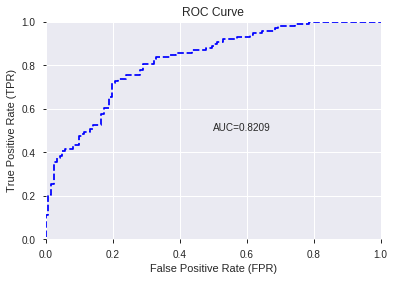

This function is available for GLM models only


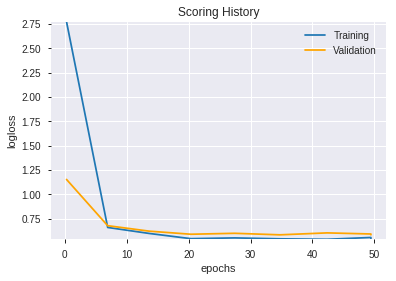

--2019-08-28 13:05:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  48.8MB/s    in 6.4s    

2019-08-28 13:05:30 (54.7 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_123115_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_123115_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_130541_model_9  0.840638  0.501998              0.229568  0.408889  0.167190
1  DeepLearning_grid_1_AutoML_20190828_130541_model_6  0.839302  0.494198              0.231864  0.405185  0.164175
2  DeepLearning_grid_1_AutoML_20190828_130541_model_8  0.823691  0.503424              0.263085  0.412623  0.170258
3               DeepLearning_1_AutoML_20190828_130541  0.823608  0.503913              0.255739  0.412782  0.170389
4  DeepLearning_grid_1_AutoML_20190828_130541_model_3  0.818516  0.542740              0.257117  0.423651  0.179480
5  DeepLearning_grid_1_AutoML_20190828_130541_model_7  0.816178  0.528091              0.266758  0.423561  0.179404
6  DeepLearning_grid_1_AutoML_20190828_130541_model_5  0.809667  0.518124              0.255280  0.419731  0.176174
7  DeepLearning_grid_1_AutoML_20190828_130541_model_4  0.804575  0.589125              0.268595  0.438386  0.192182
8  DeepLearning_grid_1_AutoML_20190828_130541_model_2  0.795976  0.579202              0.258953  0.445576  0.198538
9  DeepLearning_grid_1_AutoML_20190828_130541_model_1  0.775941  0.752715              0.288338  0.484339  0.234585

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.033623
1     CDLCLOSINGMARUBOZU             0.793084           0.793084    0.026666
2                    SUB             0.685013           0.685013    0.023032
3          CDLHANGINGMAN             0.658626           0.658626    0.022145
4            CDLLONGLINE             0.646938           0.646938    0.021752
5                    DIV             0.640086           0.640086    0.021522
6                 TRANGE             0.634167           0.634167    0.021323
7                   hour             0.624420           0.624420    0.020995
8              aroonup_8             0.618128           0.618128    0.020783
9              CDLHAMMER             0.610938           0.610938    0.020542
10             CDLTAKURI             0.604868           0.604868    0.020337
11                ULTOSC             0.601324           0.601324    0.020218
12           CDLMARUBOZU             0.600436           0.600436    0.020188
13            PLUS_DI_12             0.596668           0.596668    0.020062
14                 CCI_8             0.595890           0.595890    0.020036
15            aroonup_12             0.591473           0.591473    0.019887
16      CDLDRAGONFLYDOJI             0.589201           0.589201    0.019811
17             CDLHARAMI             0.588639           0.588639    0.019792
18         days_in_month             0.587412           0.587412    0.019751
19                Volume             0.585450           0.585450    0.019685
20              WILLR_12             0.584302           0.584302    0.019646
21          CDLSHORTLINE             0.582689           0.582689    0.019592
22                CMO_14             0.581863           0.581863    0.019564
23             PLUS_DI_8             0.579304           0.579304    0.019478
24          CDLENGULFING             0.573699           0.573699    0.019290
25                 ROC_8             0.573213           0.573213    0.019273
26                SAREXT             0.572842           0.572842    0.019261
27             PLUS_DM_8             0.572665           0.572665    0.019255
28                 MOM_8             0.572321           0.572321    0.019243
29           CDLBELTHOLD             0.569122           0.569122    0.019136
30              WILLR_24             0.567960           0.567960    0.019097
31             CORREL_14             0.565463           0.565463    0.019013
32               BETA_30             0.564754           0.564754    0.018989
33              WILLR_30             0.564628           0.564628    0.018985
34            aroonup_24             0.563613           0.563613    0.018950
35        CDLRICKSHAWMAN             0.563212           0.563212    0.018937
36              WILLR_14             0.562291           0.562291    0.018906
37                RSI_12             0.560146           0.560146    0.018834
38          STOCHF_fastk             0.559888           0.559888    0.018825
39                ROCP_8             0.558858           0.558858    0.018791
40            ROCR100_20             0.557819           0.557819    0.018756
41              WILLR_20             0.557752           0.557752    0.018753
42          HT_TRENDMODE             0.557505           0.557505    0.018745
43             ROCR100_8             0.554744           0.554744    0.018652
44                 CMO_8             0.554347           0.554347    0.018639
45               WILLR_8             0.554245           0.554245    0.018635
46  HT_PHASOR_quadrature             0.550749           0.550749    0.018518
47                ROCR_8             0.549018           0.549018    0.018460
48        STOCHRSI_fastk             0.532633           0.532633    0.017909
49   CDLXSIDEGAP3METHODS             0.527092           0.527092    0.017722

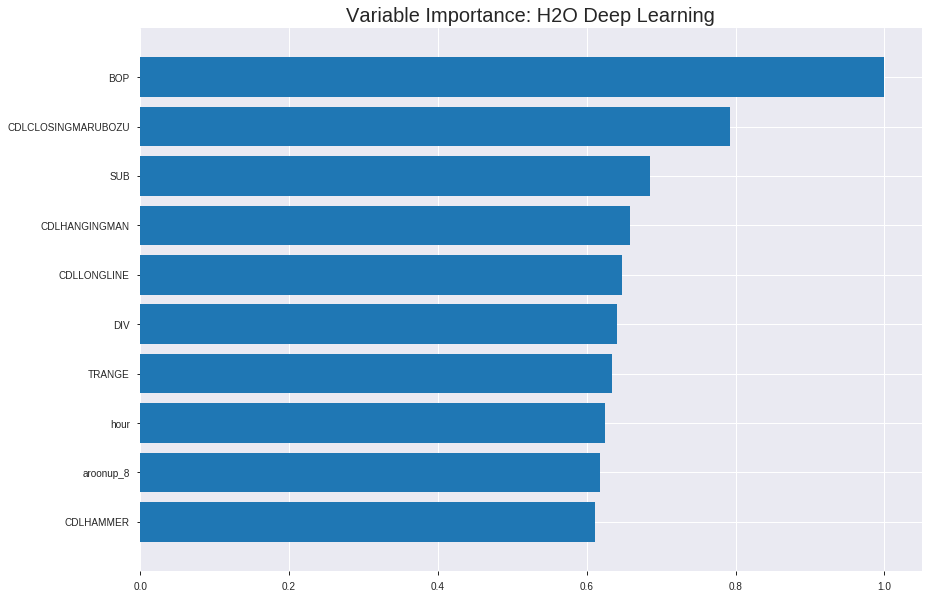

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_130541_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.182788014913839
RMSE: 0.42753715033180334
LogLoss: 0.5425455981130083
Mean Per-Class Error: 0.2612310013353857
AUC: 0.8066443083007983
pr_auc: 0.7922554866525068
Gini: 0.6132886166015965
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5115024470725876: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      536  253  0.3207   (253.0/789.0)
1      151  595  0.2024   (151.0/746.0)
Total  687  848  0.2632   (404.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511502     0.74655   209
max f2                       0.219901     0.839907  334
max f0point5                 0.621273     0.735665  152
max accuracy                 0.523012     0.737459  204
max precision                0.969426     1         0
max recall                   0.0868636    1         385
max specificity              0.969426     1         0
max absolute_mcc             0.511502     0.479385  209
max min_per_class_accuracy   0.554088     0.732573  188
max mean_per_class_accuracy  0.520712     0.738769  205

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 53.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.962732           1.92904   1.92904            0.9375           0.966416  0.9375                      0.966416            0.0201072       0.0201072                  92.9038   92.9038
    2        0.0201954                   0.957211           2.05764   1.99127            1                0.960567  0.967742                    0.963586            0.0201072       0.0402145                  105.764   99.1265
    3        0.0306189                   0.948052           1.92904   1.97008            0.9375           0.952812  0.957447                    0.959918            0.0201072       0.0603217                  92.9038   97.0082
    4        0.0403909                   0.939163           1.92046   1.95808            0.933333         0.943796  0.951613                    0.956018            0.0187668       0.0790885                  92.0465   95.8077
    5        0.0501629                   0.926879           1.78329   1.92403            0.866667         0.933518  0.935065                    0.951635            0.0174263       0.0965147                  78.3289   92.4028
    6        0.100326                    0.865422           1.89731   1.91067            0.922078         0.892375  0.928571                    0.922005            0.0951743       0.191689                   89.7305   91.0666
    7        0.150489                    0.822625           1.73697   1.85277            0.844156         0.842777  0.900433                    0.895596            0.0871314       0.27882                    73.6969   85.2767
    8        0.2                         0.765015           1.6786    1.80965            0.815789         0.793326  0.879479                    0.870278            0.0831099       0.36193                    67.8602   80.9651
    9        0.300326                    0.689701           1.40294   1.67379            0.681818         0.728633  0.813449                    0.822961            0.140751        0.502681                   40.2937   67.3786
    10       0.4                         0.617297           1.29107   1.57842            0.627451         0.654783  0.767101                    0.781053            0.128686        0.631367                   29.1069   57.8418
    11       0.500326                    0.548258           1.10899   1.48429            0.538961         0.583102  0.721354                    0.74136             0.11126         0.742627                   10.8988   48.4288
    12       0.6                         0.471889           0.806918  1.37176            0.392157         0.512422  0.666667                    0.703328            0.080429        0.823056                   -19.3082  37.1761
    13       0.699674                    0.391166           0.605188  1.26256            0.294118         0.434004  0.613594                    0.664961            0.0603217       0.883378                   -39.4812  26.2556
    14       0.8                         0.287425           0.601259  1.17962            0.292208         0.340397  0.57329                     0.624258            0.0603217       0.9437                     -39.8741  17.9625
    15       0.899674                    0.175309           0.349664  1.08767            0.169935         0.23364   0.528602                    0.580982            0.0348525       0.978552                   -65.0336  8.7674
    16       1                           0.0123044          0.213781  1                  0.103896         0.117895  0.485993                    0.534522          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1838771622706766
RMSE: 0.42880900441883985
LogLoss: 0.5449919739351488
Mean Per-Class Error: 0.28422942060444156
AUC: 0.7928389547503757
pr_auc: 0.7895629644847099
Gini: 0.5856779095007514
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36391388335075275: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      109  103  0.4858   (103.0/212.0)
1      19   207  0.0841   (19.0/226.0)
Total  128  310  0.2785   (122.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363914     0.772388  279
max f2                       0.28664      0.862903  304
max f0point5                 0.6544       0.730958  135
max accuracy                 0.390554     0.721461  269
max precision                0.970243     1         0
max recall                   0.101235     1         379
max specificity              0.970243     1         0
max absolute_mcc             0.363914     0.472591  279
max min_per_class_accuracy   0.539632     0.699115  198
max mean_per_class_accuracy  0.390554     0.715771  269

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 52.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.962755           1.55044   1.55044            0.8              0.965944  0.8                         0.965944            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.958136           1.93805   1.72271            1                0.960244  0.888889                    0.96341             0.0176991       0.0353982                  93.8053   72.2714
    3        0.0319635                   0.939896           1.93805   1.79962            1                0.947674  0.928571                    0.95779             0.0221239       0.0575221                  93.8053   79.9621
    4        0.0410959                   0.93276            1.45354   1.72271            0.75             0.936621  0.888889                    0.953086            0.0132743       0.0707965                  45.354    72.2714
    5        0.0502283                   0.91921            1.93805   1.76187            1                0.924021  0.909091                    0.947801            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.868638           1.93805   1.84996            1                0.891217  0.954545                    0.919509            0.0973451       0.185841                   93.8053   84.996
    7        0.150685                    0.816727           1.58568   1.76187            0.818182         0.843349  0.909091                    0.894123            0.079646        0.265487                   58.568    76.1866
    8        0.200913                    0.779483           1.40949   1.67377            0.727273         0.796844  0.863636                    0.869803            0.0707965       0.336283                   40.9493   67.3773
    9        0.30137                     0.68903            1.40949   1.58568            0.727273         0.74087   0.818182                    0.826825            0.141593        0.477876                   40.9493   58.568
    10       0.399543                    0.610863           1.12678   1.47292            0.581395         0.646586  0.76                        0.782538            0.110619        0.588496                   12.6775   47.292
    11       0.5                         0.541556           1.01307   1.38053            0.522727         0.580927  0.712329                    0.742032            0.10177         0.690265                   1.30732   38.0531
    12       0.600457                    0.467839           1.10117   1.33379            0.568182         0.504308  0.688213                    0.70226             0.110619        0.800885                   10.1167   33.3793
    13       0.69863                     0.379147           1.03663   1.29204            0.534884         0.42291   0.666667                    0.663005            0.10177         0.902655                   3.66331   29.2035
    14       0.799087                    0.248653           0.484513  1.19052            0.25             0.306684  0.614286                    0.618211            0.0486726       0.951327                   -51.5487  19.0518
    15       0.899543                    0.144763           0.220233  1.08216            0.113636         0.190872  0.558376                    0.570488            0.0221239       0.973451                   -77.9767  8.21616
    16       1                           0.0328077          0.26428   1                  0.136364         0.101278  0.515982                    0.523352            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:12:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:12:29  2 min 16.473 sec  453 obs/sec       0.585668  1             899        0.497535         0.905684            0.00905613     0.783745        0.715786           1.92904          0.310749                         0.485173           0.876783              0.0574651        0.782205          0.772272             1.55044            0.292237
    2019-08-28 13:12:40  2 min 27.645 sec  666 obs/sec       5.23127   9             8030       0.427537         0.542546            0.268274       0.806644        0.792255           1.92904          0.263192                         0.428809           0.544992              0.263739         0.792839          0.789563             1.55044            0.278539
    2019-08-28 13:12:51  2 min 38.685 sec  808 obs/sec       11.6182   20            17834      0.423701         0.535091            0.281347       0.808798        0.80566            2.05764          0.289902                         0.430846           0.548032              0.256726         0.792912          0.79322              1.55044            0.276256
    2019-08-28 13:13:01  2 min 49.328 sec  901 obs/sec       18.5974   32            28547      0.423889         0.537106            0.280707       0.815194        0.805133           1.92904          0.284691                         0.432005           0.551188              0.252724         0.791461          0.795462             1.55044            0.294521
    2019-08-28 13:13:12  2 min 59.616 sec  979 obs/sec       26.1531   45            40145      0.41868          0.526693            0.298276       0.821212        0.811562           1.92904          0.269055                         0.43249            0.552728              0.251044         0.789082          0.787705             1.55044            0.294521
    2019-08-28 13:13:22  3 min  9.990 sec  1045 obs/sec      34.3147   59            52673      0.415701         0.520165            0.308228       0.823488        0.81676            1.80044          0.269055                         0.43458            0.557272              0.243788         0.788279          0.787932             1.93805            0.289954
    2019-08-28 13:13:32  3 min 19.874 sec  1098 obs/sec      42.3857   73            65062      0.414397         0.518266            0.312562       0.828389        0.816798           1.92904          0.257329                         0.440904           0.578618              0.221619         0.783614          0.784601             1.93805            0.287671
    2019-08-28 13:13:33  3 min 20.900 sec  1097 obs/sec      42.3857   73            65062      0.427537         0.542546            0.268274       0.806644        0.792255           1.92904          0.263192                         0.428809           0.544992              0.263739         0.792839          0.789563             1.55044            0.278539

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
BOP                   1.0                    1.0                  0.03362305227870404
CDLCLOSINGMARUBOZU    0.7930843830108643     0.7930843830108643   0.026665917671398025
SUB                   0.685013473033905      0.685013473033905    0.02303224381543561
CDLHANGINGMAN         0.6586255431175232     0.6586255431175232   0.022145001068330325
CDLLONGLINE           0.6469376683235168     0.6469376683235168   0.0217520190431045
---                   ---                    ---                  ---
WILLR_8               0.5542447566986084     0.5542447566986084   0.01863540042967491
HT_PHASOR_quadrature  0.5507489442825317     0.5507489442825317   0.018517860546052624
ROCR_8                0.549017608165741      0.549017608165741    0.018459647741285758
STOCHRSI_fastk        0.5326329469680786     0.5326329469680786   0.017908745421267903
CDLXSIDEGAP3METHODS   0.5270921587944031     0.5270921587944031   0.017722447210839185


See the whole table with table.as_data_frame()


('accuracy', 0.7727272727272727)

('F1', 0.7614678899082569)

('auc', 0.8406377827865432)

('logloss', 0.5019983042128289)

('mean_per_class_error', 0.22589531680440778)

('rmse', 0.40888881639565305)

('mse', 0.1671900641734381)

deeplearning prediction progress: |███████████████████████████████████████| 100%


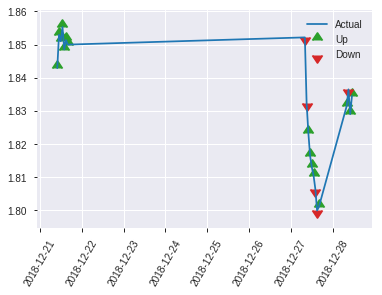


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1671900641734381
RMSE: 0.40888881639565305
LogLoss: 0.5019983042128289
Mean Per-Class Error: 0.22589531680440778
AUC: 0.8406377827865432
pr_auc: 0.8084144265258925
Gini: 0.6812755655730864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.467674886663645: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      85   36   0.2975   (36.0/121.0)
1      16   83   0.1616   (16.0/99.0)
Total  101  119  0.2364   (52.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467675     0.761468  118
max f2                       0.253511     0.847902  175
max f0point5                 0.579306     0.747126  83
max accuracy                 0.529878     0.772727  100
max precision                0.968966     1         0
max recall                   0.176005     1         193
max specificity              0.968966     1         0
max absolute_mcc             0.520798     0.545664  106
max min_per_class_accuracy   0.522891     0.768595  104
max mean_per_class_accuracy  0.520798     0.774105  106

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 49.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.950199           2.22222   2.22222            1                0.95913    1                           0.95913             0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.936407           2.22222   2.22222            1                0.943408   1                           0.952841            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.924453           2.22222   2.22222            1                0.926383   1                           0.945282            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.897865           2.22222   2.22222            1                0.912341   1                           0.937961            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.891156           2.22222   2.22222            1                0.896853   1                           0.930487            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.827526           2.22222   2.22222            1                0.871961   1                           0.901224            0.111111        0.222222                   122.222   122.222
    7        0.15                        0.761672           1.61616   2.0202             0.727273         0.792166   0.909091                    0.864871            0.0808081       0.30303                    61.6162   102.02
    8        0.2                         0.716457           1.81818   1.9697             0.818182         0.739159   0.886364                    0.833443            0.0909091       0.393939                   81.8182   96.9697
    9        0.3                         0.640444           1.41414   1.78451            0.636364         0.683608   0.80303                     0.783498            0.141414        0.535354                   41.4141   78.4512
    10       0.4                         0.570348           1.31313   1.66667            0.590909         0.602992   0.75                        0.738372            0.131313        0.666667                   31.3131   66.6667
    11       0.5                         0.510555           1.21212   1.57576            0.545455         0.538185   0.709091                    0.698334            0.121212        0.787879                   21.2121   57.5758
    12       0.6                         0.422336           0.707071  1.43098            0.318182         0.460676   0.643939                    0.658725            0.0707071       0.858586                   -29.2929  43.0976
    13       0.7                         0.358253           0.707071  1.32756            0.318182         0.394389   0.597403                    0.620962            0.0707071       0.929293                   -29.2929  32.7561
    14       0.8                         0.253283           0.505051  1.22475            0.227273         0.302504   0.551136                    0.581155            0.0505051       0.979798                   -49.4949  22.4747
    15       0.9                         0.1526             0.20202   1.11111            0.0909091        0.198246   0.5                         0.53861             0.020202        1                          -79.798   11.1111
    16       1                           0.0345925          0         1                  0                0.0993672  0.45                        

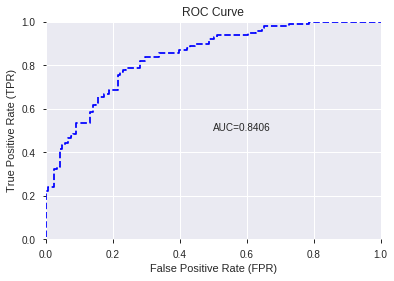

This function is available for GLM models only


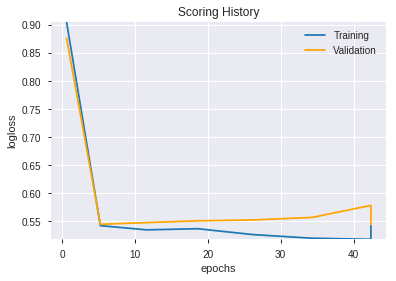

--2019-08-28 13:13:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_130541_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_130541_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'DIV',
 'TRANGE',
 'hour',
 'aroonup_8',
 'CDLHAMMER',
 'CDLTAKURI',
 'ULTOSC',
 'CDLMARUBOZU',
 'PLUS_DI_12',
 'CCI_8',
 'aroonup_12',
 'CDLDRAGONFLYDOJI',
 'CDLHARAMI',
 'days_in_month',
 'Volume',
 'WILLR_12',
 'CDLSHORTLINE',
 'CMO_14',
 'PLUS_DI_8',
 'CDLENGULFING',
 'ROC_8',
 'SAREXT',
 'PLUS_DM_8',
 'MOM_8',
 'CDLBELTHOLD',
 'WILLR_24',
 'CORREL_14',
 'BETA_30',
 'WILLR_30',
 'aroonup_24',
 'CDLRICKSHAWMAN',
 'WILLR_14',
 'RSI_12',
 'STOCHF_fastk',
 'ROCP_8',
 'ROCR100_20',
 'WILLR_20',
 'HT_TRENDMODE',
 'ROCR100_8',
 'CMO_8',
 'WILLR_8',
 'HT_PHASOR_quadrature',
 'ROCR_8',
 'STOCHRSI_fastk',
 'CDLXSIDEGAP3METHODS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_131347_model_1  0.835963  0.507156              0.217172  0.409175  0.167424

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.662145           1.000000    0.151801
1                  CCI_8             0.314725           0.475312    0.072153
2     CDLCLOSINGMARUBOZU             0.244655           0.369489    0.056089
3           STOCHF_fastk             0.241466           0.364672    0.055358
4          CDLHANGINGMAN             0.218810           0.330457    0.050164
5                    SUB             0.179724           0.271427    0.041203
6              PLUS_DI_8             0.174049           0.262857    0.039902
7                   hour             0.153881           0.232397    0.035278
8                    DIV             0.147271           0.222415    0.033763
9                 ULTOSC             0.126660           0.191287    0.029038
10   CDLXSIDEGAP3METHODS             0.111330           0.168135    0.025523
11               WILLR_8             0.096035           0.145037    0.022017
12             CDLHAMMER             0.091970           0.138897    0.021085
13            aroonup_24             0.089327           0.134906    0.020479
14  HT_PHASOR_quadrature             0.089072           0.134521    0.020420
15             CORREL_14             0.088375           0.133468    0.020261
16           CDLLONGLINE             0.080680           0.121846    0.018496
17            aroonup_12             0.078993           0.119298    0.018110
18            PLUS_DI_12             0.074926           0.113157    0.017177
19              WILLR_14             0.067156           0.101421    0.015396
20              WILLR_12             0.064755           0.097796    0.014846
21                TRANGE             0.059704           0.090167    0.013687
22           CDLMARUBOZU             0.054052           0.081631    0.012392
23            ROCR100_20             0.053822           0.081284    0.012339
24          CDLENGULFING             0.050260           0.075905    0.011522
25              WILLR_20             0.049378           0.074573    0.011320
26             aroonup_8             0.049091           0.074140    0.011254
27             CDLHARAMI             0.048483           0.073221    0.011115
28           CDLBELTHOLD             0.047569           0.071841    0.010906
29         days_in_month             0.047063           0.071077    0.010790
30                 CMO_8             0.043648           0.065919    0.010007
31          HT_TRENDMODE             0.041741           0.063039    0.009569
32                SAREXT             0.037434           0.056534    0.008582
33                RSI_12             0.037032           0.055927    0.008490
34      CDLDRAGONFLYDOJI             0.034854           0.052638    0.007991
35             CDLTAKURI             0.034625           0.052292    0.007938
36                CMO_14             0.034458           0.052040    0.007900
37              WILLR_24             0.028763           0.043440    0.006594
38                 ROC_8             0.026334           0.039771    0.006037
39             ROCR100_8             0.025774           0.038925    0.005909
40                ROCP_8             0.025579           0.038630    0.005864
41                ROCR_8             0.025411           0.038377    0.005826
42        CDLRICKSHAWMAN             0.025292           0.038198    0.005798
43             PLUS_DM_8             0.023384           0.035316    0.005361
44               BETA_30             0.018321           0.027669    0.004200
45                Volume             0.015226           0.022996    0.003491
46          CDLSHORTLINE             0.013616           0.020563    0.003121
47                 MOM_8             0.005649           0.008531    0.001295
48              WILLR_30             0.005111           0.007719    0.001172
49        STOCHRSI_fastk             0.004234           0.006394    0.000971

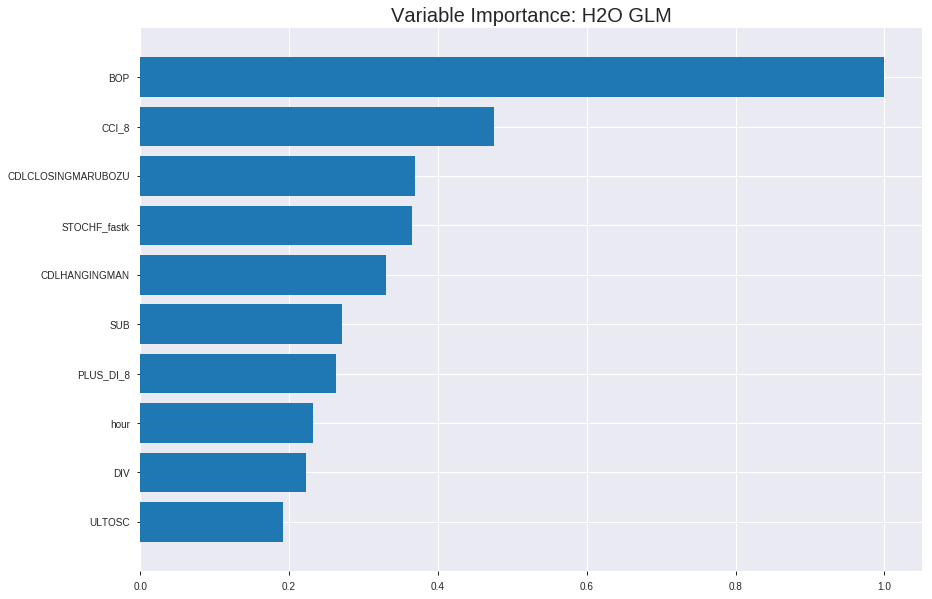

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_131347_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17747722444840247
RMSE: 0.42128045818480886
LogLoss: 0.5320026321470056
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2126.7571264665794
Residual deviance: 1633.2480806913072
AIC: 1735.2480806913072
AUC: 0.8126518449049769
pr_auc: 0.8027848474069398
Gini: 0.6253036898099538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42649156649298015: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      511  278  0.3523   (278.0/789.0)
1      137  609  0.1836   (137.0/746.0)
Total  648  887  0.2704   (415.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426492     0.745867  228
max f2                       0.262535     0.841525  301
max f0point5                 0.603755     0.740864  151
max accuracy                 0.500101     0.74202   196
max precision                0.975884     1         0
max recall                   0.0346792    1         395
max specificity              0.975884     1         0
max absolute_mcc             0.497049     0.483978  197
max min_per_class_accuracy   0.500101     0.741287  196
max mean_per_class_accuracy  0.497049     0.742073  197

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.936659           1.92904   1.92904            0.9375           0.950769   0.9375                      0.950769            0.0201072       0.0201072                  92.9038   92.9038
    2        0.0201954                   0.920322           1.92046   1.92489            0.933333         0.92697    0.935484                    0.939253            0.0187668       0.038874                   92.0465   92.489
    3        0.0306189                   0.897131           2.05764   1.97008            1                0.905315   0.957447                    0.9277              0.0214477       0.0603217                  105.764   97.0082
    4        0.0403909                   0.884508           2.05764   1.99127            1                0.890415   0.967742                    0.918679            0.0201072       0.080429                   105.764   99.1265
    5        0.0501629                   0.874055           1.92046   1.97747            0.933333         0.87865    0.961039                    0.910881            0.0187668       0.0991957                  92.0465   97.7473
    6        0.100326                    0.813722           1.84386   1.91067            0.896104         0.840772   0.928571                    0.875827            0.0924933       0.191689                   84.386    91.0666
    7        0.150489                    0.772701           1.76369   1.86167            0.857143         0.791969   0.904762                    0.847874            0.0884718       0.280161                   76.3692   86.1675
    8        0.2                         0.7247             1.62445   1.80295            0.789474         0.751096   0.876221                    0.823916            0.080429        0.36059                    62.4453   80.2949
    9        0.300326                    0.652905           1.4831    1.6961             0.720779         0.68761    0.824295                    0.778382            0.148794        0.509383                   48.3105   69.6103
    10       0.4                         0.57361            1.25072   1.58512            0.607843         0.615711   0.770358                    0.737847            0.124665        0.634048                   25.0723   58.5121
    11       0.500326                    0.489171           1.13571   1.495              0.551948         0.533248   0.726562                    0.696821            0.113941        0.747989                   13.5711   49.5005
    12       0.6                         0.407973           0.793469  1.37846            0.385621         0.449496   0.669924                    0.655734            0.0790885       0.827078                   -20.6531  37.8463
    13       0.699674                    0.326072           0.753123  1.28938            0.366013         0.367437   0.626629                    0.614664            0.075067        0.902145                   -24.6877  28.9378
    14       0.8                         0.234874           0.440923  1.18298            0.214286         0.283143   0.574919                    0.573089            0.0442359       0.946381                   -55.9077  18.2976
    15       0.899674                    0.137746           0.309319  1.08618            0.150327         0.185649   0.527878                    0.530165            0.0308311       0.977212                   -69.0681  8.6184
    16       1                           0.00159078         0.227142  1                  0.11039          0.0898862  0.485993                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1861284548125334
RMSE: 0.4314260710858042
LogLoss: 0.554800456215937
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 608.3253468479048
Residual deviance: 486.00519964516076
AIC: 588.0051996451607
AUC: 0.7951035231257306
pr_auc: 0.7894660813870458
Gini: 0.5902070462514613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3580090103325004: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  95   0.4481   (95.0/212.0)
1      28   198  0.1239   (28.0/226.0)
Total  145  293  0.2808   (123.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358009     0.763006  266
max f2                       0.251942     0.858179  309
max f0point5                 0.549311     0.744467  177
max accuracy                 0.422058     0.728311  240
max precision                0.973609     1         0
max recall                   0.0549075    1         387
max specificity              0.973609     1         0
max absolute_mcc             0.415483     0.461749  244
max min_per_class_accuracy   0.516196     0.707547  202
max mean_per_class_accuracy  0.422058     0.725184  240

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.925474           1.55044   1.55044            0.8              0.944696   0.8                         0.944696            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.904171           1.45354   1.50737            0.75             0.918549   0.777778                    0.933075            0.0132743       0.0309735                  45.354    50.7375
    3        0.0319635                   0.878139           1.93805   1.66119            1                0.892522   0.857143                    0.918592            0.0221239       0.0530973                  93.8053   66.1188
    4        0.0410959                   0.864508           1.93805   1.72271            1                0.870342   0.888889                    0.90787             0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.849979           1.93805   1.76187            1                0.85695    0.909091                    0.898612            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.793891           1.84996   1.80591            0.954545         0.823382   0.931818                    0.860997            0.0929204       0.181416                   84.996    80.5913
    7        0.150685                    0.760177           1.58568   1.7325             0.818182         0.779407   0.893939                    0.8338              0.079646        0.261062                   58.568    73.2502
    8        0.200913                    0.729462           1.67377   1.71782            0.863636         0.743545   0.886364                    0.811236            0.0840708       0.345133                   67.3773   71.782
    9        0.30137                     0.650519           1.3214    1.58568            0.681818         0.690658   0.818182                    0.771043            0.132743        0.477876                   32.14     58.568
    10       0.399543                    0.578031           1.12678   1.47292            0.581395         0.618411   0.76                        0.733539            0.110619        0.588496                   12.6775   47.292
    11       0.5                         0.517027           1.10117   1.39823            0.568182         0.543794   0.721461                    0.695417            0.110619        0.699115                   10.1167   39.823
    12       0.600457                    0.422882           1.14521   1.3559             0.590909         0.463666   0.69962                     0.656645            0.115044        0.814159                   14.5213   35.59
    13       0.69863                     0.317552           0.721136  1.2667             0.372093         0.378259   0.653595                    0.617525            0.0707965       0.884956                   -27.8864  26.6701
    14       0.799087                    0.220912           0.572607  1.17944            0.295455         0.270829   0.608571                    0.573941            0.0575221       0.942478                   -42.7393  17.9444
    15       0.899543                    0.140348           0.308327  1.08216            0.159091         0.180269   0.558376                    0.529977            0.0309735       0.973451                   -69.1673  8.21616
    16       1                           0.0167459          0.26428   1                  0.136364         0.0802594  0.515982                    0.484


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:13:48  0.000 sec   2            22        51            1.3591            1.36538
    2019-08-28 13:13:48  0.078 sec   4            14        51            1.34637           1.35377
    2019-08-28 13:13:48  0.101 sec   6            8.5       51            1.32926           1.33785
    2019-08-28 13:13:48  0.131 sec   8            5.3       51            1.30748           1.31714
    2019-08-28 13:13:48  0.156 sec   10           3.3       51            1.28111           1.2915
    2019-08-28 13:13:48  0.177 sec   12           2         51            1.25111           1.26185
    2019-08-28 13:13:48  0.207 sec   14           1.3       51            1.21918           1.23016
    2019-08-28 13:13:48  0.232 sec   16           0.78      51            1.18766           1.19925
    2019-08-28 13:13:48  0.253 sec   18           0.49      51            1.15871           1.17189
    2019-08-28 13:13:48  0.282 sec   20           0.3       51            1.1337            1.14981
    2019-08-28 13:13:48  0.300 sec   22           0.19      51            1.11294           1.1335
    2019-08-28 13:13:48  0.323 sec   24           0.12      51            1.0961            1.12233
    2019-08-28 13:13:48  0.342 sec   26           0.072     51            1.08261           1.11527
    2019-08-28 13:13:48  0.360 sec   28           0.045     51            1.072             1.11125
    2019-08-28 13:13:49  0.386 sec   30           0.028     51            1.06401           1.1096
    2019-08-28 13:13:49  0.412 sec   32           0.017     51            1.05833           1.10967
    2019-08-28 13:13:49  0.437 sec   34           0.011     51            1.05458           1.11055
    2019-08-28 13:13:49  0.462 sec   36           0.0067    51            1.05224           1.11174
    2019-08-28 13:13:49  0.488 sec   38           0.0042    51            1.0508            1.11284
    2019-08-28 13:13:49  0.526 sec   40           0.0026    51            1.04986           1.1136

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7772727272727272)

('F1', 0.772093023255814)

('auc', 0.8359629351364889)

('logloss', 0.5071562275094559)

('mean_per_class_error', 0.21717171717171713)

('rmse', 0.4091750902140983)

('mse', 0.1674242544517155)

glm prediction progress: |████████████████████████████████████████████████| 100%


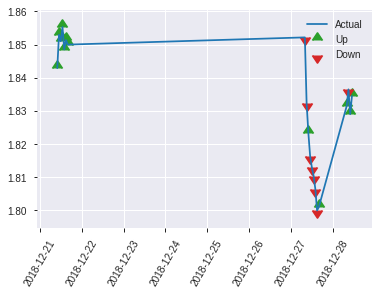


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1674242544517155
RMSE: 0.4091750902140983
LogLoss: 0.5071562275094559
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 303.92457192432397
Residual deviance: 223.14874010416054
AIC: 325.14874010416054
AUC: 0.8359629351364889
pr_auc: 0.801125853194008
Gini: 0.6719258702729778
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42956541557839323: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   33   0.2727   (33.0/121.0)
1      16   83   0.1616   (16.0/99.0)
Total  104  116  0.2227   (49.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429565     0.772093  115
max f2                       0.268536     0.843806  160
max f0point5                 0.507257     0.749465  91
max accuracy                 0.449912     0.777273  107
max precision                0.935918     1         0
max recall                   0.0655033    1         212
max specificity              0.935918     1         0
max absolute_mcc             0.429565     0.56366   115
max min_per_class_accuracy   0.469954     0.760331  104
max mean_per_class_accuracy  0.429565     0.782828  115

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.896447           2.22222   2.22222            1                0.913552   1                           0.913552            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.876112           2.22222   2.22222            1                0.887077   1                           0.902962            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.860215           2.22222   2.22222            1                0.864431   1                           0.891953            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.854395           2.22222   2.22222            1                0.856087   1                           0.883983            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.836863           2.22222   2.22222            1                0.85362    1                           0.878462            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.754988           2.22222   2.22222            1                0.795528   1                           0.836995            0.111111        0.222222                   122.222   122.222
    7        0.15                        0.7065             1.41414   1.95286            0.636364         0.732718   0.878788                    0.802236            0.0707071       0.292929                   41.4141   95.2862
    8        0.2                         0.676824           1.81818   1.91919            0.818182         0.690332   0.863636                    0.77426             0.0909091       0.383838                   81.8182   91.9192
    9        0.3                         0.592058           1.31313   1.71717            0.590909         0.632822   0.772727                    0.727114            0.131313        0.515152                   31.3131   71.7172
    10       0.4                         0.516186           1.51515   1.66667            0.681818         0.549684   0.75                        0.682756            0.151515        0.666667                   51.5152   66.6667
    11       0.5                         0.442211           1.31313   1.59596            0.590909         0.484116   0.718182                    0.643028            0.131313        0.79798                    31.3131   59.596
    12       0.6                         0.381439           0.808081  1.46465            0.363636         0.409431   0.659091                    0.604096            0.0808081       0.878788                   -19.1919  46.4646
    13       0.7                         0.285432           0.505051  1.32756            0.227273         0.331579   0.597403                    0.565165            0.0505051       0.929293                   -49.4949  32.7561
    14       0.8                         0.204582           0.30303   1.19949            0.136364         0.246998   0.539773                    0.525394            0.030303        0.959596                   -69.697   19.9495
    15       0.9                         0.121725           0.20202   1.08866            0.0909091        0.161281   0.489899                    0.484937            0.020202        0.979798                   -79.798   8.86644
    16       1                           0.0131767          0.20202   1                  0.0909091        0.0714234  0.45                        

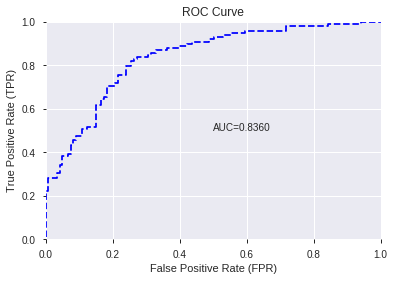

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


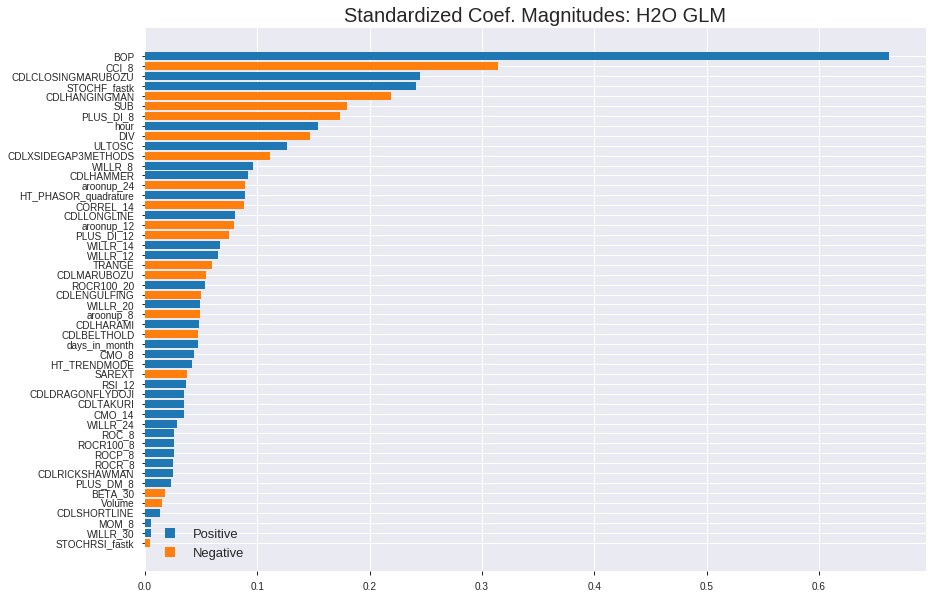

'log_likelihood'
--2019-08-28 13:13:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_131347_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_131347_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'SUB',
 'PLUS_DI_8',
 'hour',
 'DIV',
 'ULTOSC',
 'CDLXSIDEGAP3METHODS',
 'WILLR_8',
 'CDLHAMMER',
 'aroonup_24',
 'HT_PHASOR_quadrature',
 'CORREL_14',
 'CDLLONGLINE',
 'aroonup_12',
 'PLUS_DI_12',
 'WILLR_14',
 'WILLR_12',
 'TRANGE',
 'CDLMARUBOZU',
 'ROCR100_20',
 'CDLENGULFING',
 'WILLR_20',
 'aroonup_8',
 'CDLHARAMI',
 'CDLBELTHOLD',
 'days_in_month',
 'CMO_8',
 'HT_TRENDMODE',
 'SAREXT',
 'RSI_12',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CMO_14',
 'WILLR_24',
 'ROC_8',
 'ROCR100_8',
 'ROCP_8',
 'ROCR_8',
 'CDLRICKSHAWMAN',
 'PLUS_DM_8',
 'BETA_30',
 'Volume',
 'CDLSHORTLINE',
 'MOM_8',
 'WILLR_30',
 'STOCHRSI_fastk']

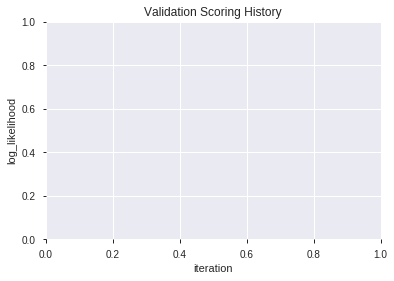

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_131401_model_6  0.841473  0.498428              0.247475  0.406548  0.165281
1  XGBoost_grid_1_AutoML_20190828_131401_model_4  0.838968  0.511947              0.247934  0.411551  0.169374
2  XGBoost_grid_1_AutoML_20190828_131401_model_1  0.838133  0.494603              0.243343  0.406100  0.164917
3  XGBoost_grid_1_AutoML_20190828_131401_model_2  0.836798  0.506078              0.223140  0.409528  0.167713
4               XGBoost_3_AutoML_20190828_131401  0.835462  0.498801              0.237833  0.407325  0.165914
5               XGBoost_2_AutoML_20190828_131401  0.835045  0.503649              0.258035  0.409550  0.167731
6  XGBoost_grid_1_AutoML_20190828_131401_model_3  0.827615  0.505221              0.243343  0.412474  0.170135
7  XGBoost_grid_1_AutoML_20190828_131401_model_7  0.826112  0.501608              0.242883  0.411074  0.168981
8               XGBoost_1_AutoML_20190828_131401  0.824192  0.510667              0.264463  0.414625  0.171914
9  XGBoost_grid_1_AutoML_20190828_131401_model_5  0.812505  0.520672              0.265381  0.422585  0.178578

variable  relative_importance  scaled_importance  percentage
0                    BOP          2029.442261           1.000000    0.206185
1           STOCHF_fastk           883.604431           0.435393    0.089771
2                    DIV           674.131287           0.332176    0.068490
3                  CCI_8           483.241577           0.238115    0.049096
4                 TRANGE           383.037231           0.188740    0.038915
5                 ULTOSC           339.746124           0.167409    0.034517
6                   hour           323.584198           0.159445    0.032875
7   HT_PHASOR_quadrature           304.184875           0.149886    0.030904
8                BETA_30           299.308594           0.147483    0.030409
9                 SAREXT           285.736755           0.140796    0.029030
10               WILLR_8           285.067352           0.140466    0.028962
11             CORREL_14           263.756348           0.129965    0.026797
12             PLUS_DM_8           248.042389           0.122222    0.025200
13             aroonup_8           233.432755           0.115023    0.023716
14            ROCR100_20           221.821899           0.109302    0.022536
15             PLUS_DI_8           209.645081           0.103302    0.021299
16                Volume           208.849609           0.102910    0.021218
17    CDLCLOSINGMARUBOZU           181.757584           0.089560    0.018466
18                 CMO_8           172.872025           0.085182    0.017563
19              WILLR_12           164.771500           0.081191    0.016740
20            aroonup_12           145.445496           0.071668    0.014777
21              WILLR_30           142.956345           0.070441    0.014524
22                 MOM_8           130.237320           0.064174    0.013232
23           CDLLONGLINE           121.304047           0.059772    0.012324
24            PLUS_DI_12           121.249649           0.059745    0.012319
25              WILLR_14           120.567734           0.059409    0.012249
26        STOCHRSI_fastk           116.783539           0.057545    0.011865
27            aroonup_24           115.498062           0.056911    0.011734
28                   SUB           112.765915           0.055565    0.011457
29              WILLR_20           110.723831           0.054559    0.011249
30                 ROC_8            82.111435           0.040460    0.008342
31                CMO_14            56.459263           0.027820    0.005736
32         days_in_month            46.215630           0.022773    0.004695
33              WILLR_24            44.933929           0.022141    0.004565
34          HT_TRENDMODE            39.371876           0.019400    0.004000
35                RSI_12            34.497852           0.016999    0.003505
36         CDLHANGINGMAN            22.657713           0.011165    0.002302
37           CDLBELTHOLD            22.595316           0.011134    0.002296
38             CDLHAMMER            15.557909           0.007666    0.001581
39          CDLSHORTLINE             9.342379           0.004603    0.000949
40                ROCP_8             9.037837           0.004453    0.000918
41             CDLTAKURI             7.368693           0.003631    0.000749
42                ROCR_8             6.447770           0.003177    0.000655
43        CDLRICKSHAWMAN             5.084009           0.002505    0.000517
44          CDLENGULFING             4.060814           0.002001    0.000413
45           CDLMARUBOZU             3.516943           0.001733    0.000357

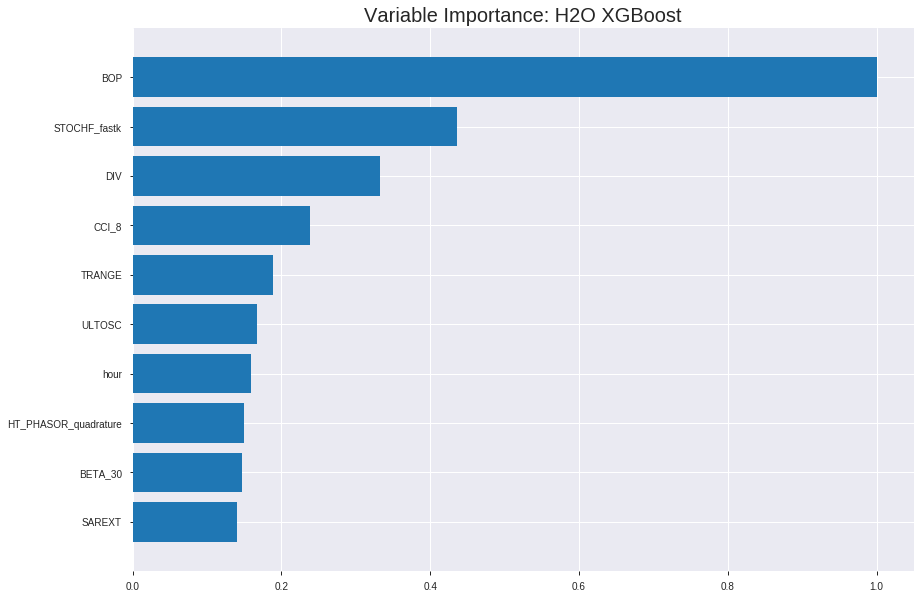

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_131401_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11835794366725125
RMSE: 0.3440318933867197
LogLoss: 0.3907413413089886
Mean Per-Class Error: 0.14865255167398916
AUC: 0.9367637114887342
pr_auc: 0.9340055872333171
Gini: 0.8735274229774683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4014091193675995: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      597  192  0.2433   (192.0/789.0)
1      44   702  0.059    (44.0/746.0)
Total  641  894  0.1537   (236.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401409     0.856098  238
max f2                       0.357944     0.91128   256
max f0point5                 0.618177     0.871898  147
max accuracy                 0.437146     0.849511  223
max precision                0.950674     1         0
max recall                   0.208635     1         322
max specificity              0.950674     1         0
max absolute_mcc             0.401409     0.707069  238
max min_per_class_accuracy   0.502513     0.837769  198
max mean_per_class_accuracy  0.437146     0.851347  223

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104235                   0.927469           2.05764   2.05764            1                0.93556    1                           0.93556             0.0214477       0.0214477                  105.764    105.764
    2        0.0201954                   0.914167           2.05764   2.05764            1                0.918849   1                           0.927474            0.0201072       0.041555                   105.764    105.764
    3        0.0306189                   0.90508            2.05764   2.05764            1                0.909234   1                           0.921265            0.0214477       0.0630027                  105.764    105.764
    4        0.0403909                   0.896235           2.05764   2.05764            1                0.901363   1                           0.91645             0.0201072       0.0831099                  105.764    105.764
    5        0.0501629                   0.887623           2.05764   2.05764            1                0.891642   1                           0.911617            0.0201072       0.103217                   105.764    105.764
    6        0.100326                    0.848885           2.05764   2.05764            1                0.869317   1                           0.890467            0.103217        0.206434                   105.764    105.764
    7        0.150489                    0.801623           2.05764   2.05764            1                0.826486   1                           0.86914             0.103217        0.309651                   105.764    105.764
    8        0.2                         0.768791           2.03057   2.05094            0.986842         0.785441   0.996743                    0.84842             0.100536        0.410188                   103.057    105.094
    9        0.300326                    0.672812           1.76369   1.95498            0.857143         0.720281   0.950108                    0.805614            0.176944        0.587131                   76.3692    95.4982
    10       0.4                         0.589877           1.54659   1.85322            0.751634         0.630134   0.900651                    0.761887            0.154155        0.741287                   54.6593    85.3217
    11       0.500326                    0.494371           1.08227   1.69863            0.525974         0.541916   0.825521                    0.717778            0.108579        0.849866                   8.22656    69.8625
    12       0.6                         0.374842           0.995199  1.58177            0.48366          0.438233   0.76873                     0.671339            0.0991957       0.949062                   -0.480121  58.1769
    13       0.699674                    0.283675           0.376562  1.41008            0.183007         0.331961   0.685289                    0.622992            0.0375335       0.986595                   -62.3438   41.0078
    14       0.8                         0.191074           0.133613  1.25               0.0649351        0.235983   0.607492                    0.574458            0.0134048       1                          -86.6387   25
    15       0.899674                    0.124202           0         1.11151            0                0.156198   0.540188                    0.52812             0               1                          -100       11.1513
    16       1                           0.0520066          0         1                  0                0.0933347  0.485993       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19506898238173792
RMSE: 0.44166614357650047
LogLoss: 0.5697703463631729
Mean Per-Class Error: 0.29042828518951413
AUC: 0.7719569210218735
pr_auc: 0.7586192160602157
Gini: 0.543913842043747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30087944865226746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  108  0.5094   (108.0/212.0)
1      21   205  0.0929   (21.0/226.0)
Total  125  313  0.2945   (129.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300879     0.760668  284
max f2                       0.173848     0.864101  334
max f0point5                 0.390491     0.705615  248
max accuracy                 0.355626     0.714612  264
max precision                0.952326     1         0
max recall                   0.113629     1         369
max specificity              0.952326     1         0
max absolute_mcc             0.355626     0.443588  264
max min_per_class_accuracy   0.481015     0.683962  200
max mean_per_class_accuracy  0.355626     0.709572  264

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.933834           1.93805   1.93805            1                0.944448   1                           0.944448            0.0221239       0.0221239                  93.8053    93.8053
    2        0.0205479                   0.917667           1.45354   1.72271            0.75             0.923942   0.888889                    0.935334            0.0132743       0.0353982                  45.354     72.2714
    3        0.0319635                   0.910268           1.55044   1.66119            0.8              0.914306   0.857143                    0.927824            0.0176991       0.0530973                  55.0442    66.1188
    4        0.0410959                   0.89808            1.93805   1.72271            1                0.901821   0.888889                    0.922045            0.0176991       0.0707965                  93.8053    72.2714
    5        0.0502283                   0.891031           1.45354   1.67377            0.75             0.895422   0.863636                    0.917205            0.0132743       0.0840708                  45.354     67.3773
    6        0.100457                    0.831136           1.58568   1.62973            0.818182         0.861036   0.840909                    0.88912             0.079646        0.163717                   58.568     62.9726
    7        0.150685                    0.796542           1.76187   1.67377            0.909091         0.815877   0.863636                    0.864706            0.0884956       0.252212                   76.1866    67.3773
    8        0.200913                    0.74295            1.58568   1.65175            0.818182         0.770478   0.852273                    0.841149            0.079646        0.331858                   58.568     65.175
    9        0.30137                     0.660004           1.27735   1.52695            0.659091         0.699076   0.787879                    0.793791            0.128319        0.460177                   27.7353    52.6951
    10       0.399543                    0.580542           1.0817    1.41755            0.55814          0.622481   0.731429                    0.751698            0.106195        0.566372                   8.17041    41.7547
    11       0.5                         0.488001           1.10117   1.35398            0.568182         0.532397   0.69863                     0.707637            0.110619        0.676991                   10.1167    35.3982
    12       0.600457                    0.412635           1.14521   1.31906            0.590909         0.450682   0.680608                    0.664649            0.115044        0.792035                   14.5213    31.9055
    13       0.69863                     0.318952           0.991562  1.27303            0.511628         0.364634   0.656863                    0.62249             0.0973451       0.889381                   -0.843795  27.3035
    14       0.799087                    0.215357           0.52856   1.17944            0.272727         0.266122   0.608571                    0.577689            0.0530973       0.942478                   -47.144    17.9444
    15       0.899543                    0.126842           0.352373  1.08708            0.181818         0.166399   0.560914                    0.531758            0.0353982       0.977876                   -64.7627   8.70805
    16       1                           0.0616798          0.220233  1                  0.113636         0.0967943  0.515982   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:14:18  10.080 sec  0                  0.5              0.693147            0.5             0                  1                0.514007                         0.5                0.693147              0.5               0                    1                  0.484018
    2019-08-28 13:14:18  10.198 sec  5                  0.465079         0.625218            0.871708        0.860504           2.05764          0.231922                         0.476442           0.646763              0.769901          0.754264             1.93805            0.33105
    2019-08-28 13:14:18  10.280 sec  10                 0.439113         0.576116            0.887331        0.882839           2.05764          0.229316                         0.462402           0.619051              0.771143          0.756563             1.93805            0.305936
    2019-08-28 13:14:18  10.364 sec  15                 0.419426         0.538684            0.893522        0.89065            2.05764          0.199349                         0.452624           0.598883              0.772176          0.755545             1.55044            0.292237
    2019-08-28 13:14:19  10.446 sec  20                 0.404428         0.509727            0.90001         0.897289           2.05764          0.188274                         0.446497           0.585428              0.773251          0.756385             1.93805            0.30137
    2019-08-28 13:14:19  10.531 sec  25                 0.391945         0.485209            0.9058          0.900399           2.05764          0.185016                         0.443254           0.577319              0.77252           0.761813             1.93805            0.30137
    2019-08-28 13:14:19  10.621 sec  30                 0.38327          0.467664            0.909348        0.903084           2.05764          0.179805                         0.44062            0.570405              0.774117          0.765211             1.93805            0.294521
    2019-08-28 13:14:19  10.704 sec  35                 0.375343         0.451544            0.913145        0.9079             2.05764          0.178502                         0.4405             0.569035              0.77228           0.760874             1.93805            0.292237
    2019-08-28 13:14:19  10.796 sec  40                 0.368057         0.437474            0.919563        0.915506           2.05764          0.177199                         0.439486           0.566252              0.774148          0.761104             1.93805            0.299087
    2019-08-28 13:14:19  10.883 sec  45                 0.362089         0.425056            0.922537        0.918156           2.05764          0.171987                         0.439437           0.5657                0.774691          0.76082              1.93805            0.296804
    2019-08-28 13:14:19  10.986 sec  50                 0.355918         0.413182            0.927845        0.924148           2.05764          0.172638                         0.441063           0.569204              0.772416          0.756832             1.93805            0.292237
    2019-08-28 13:14:19  11.075 sec  55                 0.349282         0.400749            0.933164        0.929535           2.05764          0.162215                         0.442172           0.571171              0.77012           0.75

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             2029.4422607421875     1.0                    0.20618493409288235
STOCHF_fastk    883.6044311523438      0.4353927422548108     0.08977142386632748
DIV             674.1312866210938      0.33217564237307107    0.06848961292995252
CCI_8           483.2415771484375      0.23811545984644628    0.0490958203949359
TRANGE          383.0372314453125      0.18874014740642678    0.03891537485367501
---             ---                    ---                    ---
CDLTAKURI       7.3686933517456055     0.0036308957856484177  0.0007486360082620433
ROCR_8          6.447770118713379      0.0031771143448818123  0.0006550731118050076
CDLRICKSHAWMAN  5.084009170532227      0.0025051262944888876  0.0005165192999235378
CDLENGULFING    4.060813903808594      0.002000950695844637   0.00041256588734583363
CDLMARUBOZU     3.5169425010681152     0.0017329601186987867  0.0003573102678595029


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7630522088353413)

('auc', 0.8414725770097671)

('logloss', 0.4984279514250983)

('mean_per_class_error', 0.23783287419651056)

('rmse', 0.40654751135369493)

('mse', 0.1652808789878827)

xgboost prediction progress: |████████████████████████████████████████████| 100%


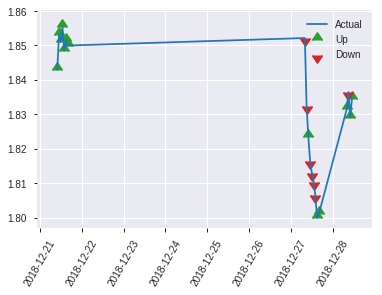


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1652808789878827
RMSE: 0.40654751135369493
LogLoss: 0.4984279514250983
Mean Per-Class Error: 0.23783287419651056
AUC: 0.8414725770097671
pr_auc: 0.8050850096919094
Gini: 0.6829451540195342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2871610224246979: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   55   0.4545   (55.0/121.0)
1      4    95   0.0404   (4.0/99.0)
Total  70   150  0.2682   (59.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287161     0.763052  149
max f2                       0.287161     0.869963  149
max f0point5                 0.460392     0.729847  89
max accuracy                 0.435572     0.754545  102
max precision                0.911642     1         0
max recall                   0.0994236    1         213
max specificity              0.911642     1         0
max absolute_mcc             0.287161     0.539449  149
max min_per_class_accuracy   0.435572     0.747475  102
max mean_per_class_accuracy  0.40456      0.762167  120

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 43.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.908976           2.22222   2.22222            1                0.910953  1                           0.910953            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.901026           2.22222   2.22222            1                0.902861  1                           0.907716            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.891001           2.22222   2.22222            1                0.896221  1                           0.904432            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.882733           2.22222   2.22222            1                0.886929  1                           0.900543            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.870682           2.22222   2.22222            1                0.876641  1                           0.896197            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.782029           1.81818   2.0202             0.818182         0.824778  0.909091                    0.860487            0.0909091       0.20202                    81.8182   102.02
    7        0.15                        0.709928           2.22222   2.08754            1                0.745785  0.939394                    0.822253            0.111111        0.313131                   122.222   108.754
    8        0.2                         0.647316           1.41414   1.91919            0.636364         0.684412  0.863636                    0.787793            0.0707071       0.383838                   41.4141   91.9192
    9        0.3                         0.547065           1.41414   1.75084            0.636364         0.59507   0.787879                    0.723552            0.141414        0.525253                   41.4141   75.0842
    10       0.4                         0.46087            1.31313   1.64141            0.590909         0.503629  0.738636                    0.668571            0.131313        0.656566                   31.3131   64.1414
    11       0.5                         0.430324           1.11111   1.53535            0.5              0.44442   0.690909                    0.623741            0.111111        0.767677                   11.1111   53.5354
    12       0.6                         0.354823           1.11111   1.46465            0.5              0.399645  0.659091                    0.586392            0.111111        0.878788                   11.1111   46.4646
    13       0.7                         0.273022           0.808081  1.37085            0.363636         0.315631  0.616883                    0.547712            0.0808081       0.959596                   -19.1919  37.0851
    14       0.8                         0.187841           0.30303   1.23737            0.136364         0.22207   0.556818                    0.507007            0.030303        0.989899                   -69.697   23.7374
    15       0.9                         0.125909           0         1.09989            0                0.153686  0.494949                    0.467749            0               0.989899                   -100      9.98878
    16       1                           0.0516844          0.10101   1                  0.0454545        0.103617  0.45                        0.431335          

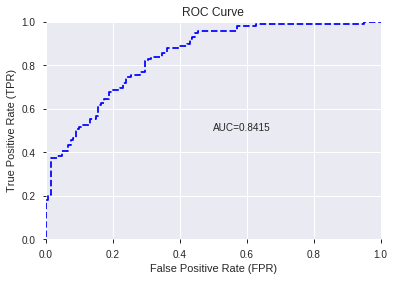

This function is available for GLM models only


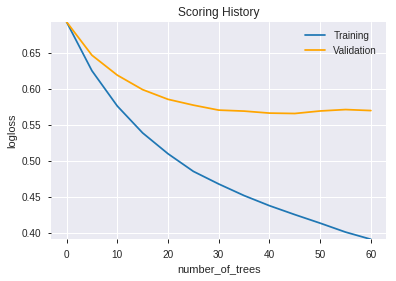

--2019-08-28 13:14:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.32
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.32|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_131401_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_131401_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CCI_8',
 'TRANGE',
 'ULTOSC',
 'hour',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'SAREXT',
 'WILLR_8',
 'CORREL_14',
 'PLUS_DM_8',
 'aroonup_8',
 'ROCR100_20',
 'PLUS_DI_8',
 'Volume',
 'CDLCLOSINGMARUBOZU',
 'CMO_8',
 'WILLR_12',
 'aroonup_12',
 'WILLR_30',
 'MOM_8',
 'CDLLONGLINE',
 'PLUS_DI_12',
 'WILLR_14',
 'STOCHRSI_fastk',
 'aroonup_24',
 'SUB',
 'WILLR_20',
 'ROC_8',
 'CMO_14',
 'days_in_month',
 'WILLR_24',
 'HT_TRENDMODE',
 'RSI_12',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLSHORTLINE',
 'ROCP_8',
 'CDLTAKURI',
 'ROCR_8',
 'CDLRICKSHAWMAN',
 'CDLENGULFING',
 'CDLMARUBOZU']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_131431_model_1  0.820102  0.526532              0.256198  0.418939  0.17551

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.413406           1.000000  3.560619e-02
1           CDLCLOSINGMARUBOZU             0.192227           0.464982  1.655624e-02
2                          SUB             0.169840           0.410830  1.462808e-02
3                 STOCHF_fastk             0.169511           0.410035  1.459979e-02
4                CDLHANGINGMAN             0.166835           0.403562  1.436932e-02
...                        ...                  ...                ...           ...
1031  BBANDS_middleband_14_0_3             0.000027           0.000066  2.332694e-06
1032  BBANDS_middleband_12_1_3             0.000027           0.000065  2.324907e-06
1033   BBANDS_lowerband_12_5_4             0.000025           0.000060  2.138576e-06
1034                  TRIMA_14             0.000013           0.000031  1.107649e-06
1035   BBANDS_lowerband_12_0_4             0.000003           0.000007  2.325711e-07

[1036 rows x 4 columns]

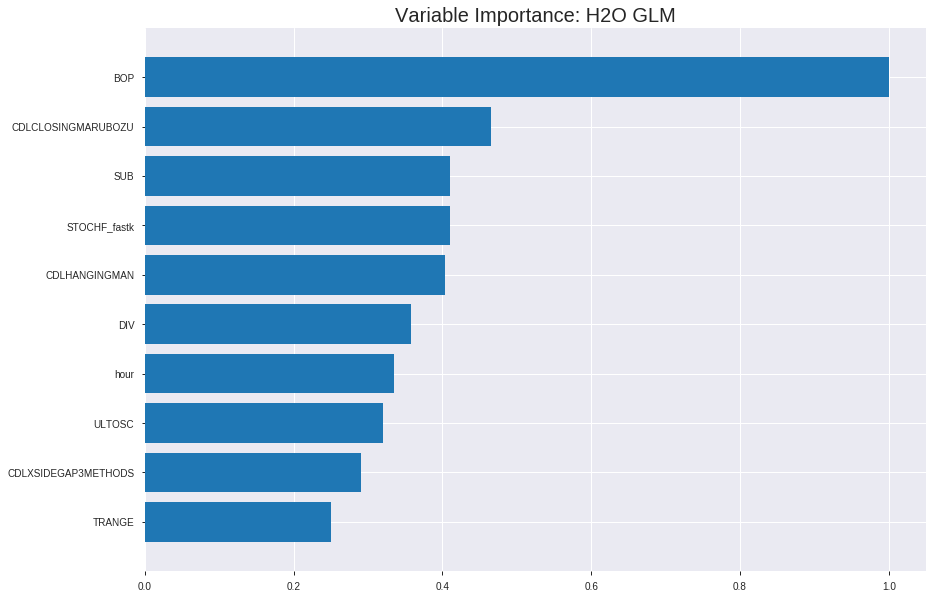

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_131431_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17056885196383303
RMSE: 0.41299982077942
LogLoss: 0.5153902975892034
Null degrees of freedom: 1534
Residual degrees of freedom: 498
Null deviance: 2126.7571264665794
Residual deviance: 1582.2482135988544
AIC: 3656.2482135988544
AUC: 0.8311552615215242
pr_auc: 0.8193676131562895
Gini: 0.6623105230430484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42326330317881844: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      512  277  0.3511   (277.0/789.0)
1      113  633  0.1515   (113.0/746.0)
Total  625  910  0.2541   (390.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423263     0.764493  231
max f2                       0.190516     0.847122  332
max f0point5                 0.575323     0.76045   157
max accuracy                 0.474559     0.750489  209
max precision                0.978284     1         0
max recall                   0.0542975    1         390
max specificity              0.978284     1         0
max absolute_mcc             0.423263     0.506052  231
max min_per_class_accuracy   0.501095     0.74398   194
max mean_per_class_accuracy  0.474559     0.751662  209

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.918143           1.80044   1.80044            0.875            0.940216   0.875                       0.940216            0.0187668       0.0187668                  80.0436   80.0436
    2        0.0201954                   0.900534           2.05764   1.92489            1                0.909298   0.935484                    0.925255            0.0201072       0.038874                   105.764   92.489
    3        0.0306189                   0.883293           2.05764   1.97008            1                0.892068   0.957447                    0.913958            0.0214477       0.0603217                  105.764   97.0082
    4        0.0403909                   0.869903           1.92046   1.95808            0.933333         0.875691   0.951613                    0.9047              0.0187668       0.0790885                  92.0465   95.8077
    5        0.0501629                   0.86313            1.92046   1.95075            0.933333         0.866704   0.948052                    0.897298            0.0187668       0.0978552                  92.0465   95.075
    6        0.100326                    0.802902           1.92403   1.93739            0.935065         0.832641   0.941558                    0.86497             0.0965147       0.19437                    92.4028   93.7389
    7        0.150489                    0.759863           1.84386   1.90621            0.896104         0.781702   0.926407                    0.837214            0.0924933       0.286863                   84.386    90.6213
    8        0.2                         0.720691           1.70568   1.85657            0.828947         0.740141   0.90228                     0.813183            0.0844504       0.371314                   70.5676   85.6568
    9        0.300326                    0.643474           1.50983   1.74074            0.733766         0.681578   0.845987                    0.769219            0.151475        0.522788                   50.9827   74.0737
    10       0.4                         0.566111           1.26417   1.62198            0.614379         0.604369   0.788274                    0.728141            0.126005        0.648794                   26.4171   62.1984
    11       0.500326                    0.494298           1.0689    1.51108            0.519481         0.529569   0.734375                    0.688323            0.107239        0.756032                   6.89043   51.108
    12       0.6                         0.416986           0.968302  1.42091            0.470588         0.459266   0.690554                    0.650271            0.0965147       0.852547                   -3.16985  42.0912
    13       0.699674                    0.334917           0.564843  1.29896            0.27451          0.379161   0.631285                    0.61165             0.0563003       0.908847                   -43.5157  29.8958
    14       0.8                         0.240181           0.454284  1.19303            0.220779         0.288388   0.579805                    0.57111             0.0455764       0.954424                   -54.5716  19.3029
    15       0.899674                    0.147404           0.29587   1.09363            0.143791         0.192797   0.531499                    0.529197            0.0294906       0.983914                   -70.413   9.36338
    16       1                           0.00279013         0.160336  1                  0.0779221        0.0985628  0.485993                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19125601993532906
RMSE: 0.43732827479518066
LogLoss: 0.5644569294034871
Null degrees of freedom: 437
Residual degrees of freedom: -599
Null deviance: 608.3253468479048
Residual deviance: 494.46427015745473
AIC: 2568.464270157455
AUC: 0.7816517782601435
pr_auc: 0.7727322206393129
Gini: 0.5633035565202871
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31329020135381375: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  104  0.4906   (104.0/212.0)
1      21   205  0.0929   (21.0/226.0)
Total  129  309  0.2854   (125.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31329      0.766355  279
max f2                       0.121236     0.85431   372
max f0point5                 0.587474     0.733042  156
max accuracy                 0.316887     0.714612  276
max precision                0.96697      1         0
max recall                   0.0476442    1         391
max specificity              0.96697      1         0
max absolute_mcc             0.31329      0.456643  279
max min_per_class_accuracy   0.498854     0.688679  202
max mean_per_class_accuracy  0.316887     0.708549  276

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.899199           1.55044   1.55044            0.8              0.941684   0.8                         0.941684            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.886179           1.93805   1.72271            1                0.890315   0.888889                    0.918853            0.0176991       0.0353982                  93.8053   72.2714
    3        0.0319635                   0.876466           1.55044   1.66119            0.8              0.880846   0.857143                    0.905279            0.0176991       0.0530973                  55.0442   66.1188
    4        0.0410959                   0.866558           1.93805   1.72271            1                0.87111    0.888889                    0.897686            0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.857406           1.45354   1.67377            0.75             0.862324   0.863636                    0.891257            0.0132743       0.0840708                  45.354    67.3773
    6        0.100457                    0.811965           1.93805   1.80591            1                0.835902   0.931818                    0.863579            0.0973451       0.181416                   93.8053   80.5913
    7        0.150685                    0.760843           1.49759   1.70314            0.772727         0.784273   0.878788                    0.837144            0.0752212       0.256637                   49.7586   70.3138
    8        0.200913                    0.735001           1.40949   1.62973            0.727273         0.747201   0.840909                    0.814658            0.0707965       0.327434                   40.9493   62.9726
    9        0.30137                     0.652299           1.45354   1.571              0.75             0.692577   0.810606                    0.773965            0.146018        0.473451                   45.354    57.0998
    10       0.399543                    0.583004           1.21692   1.48399            0.627907         0.618046   0.765714                    0.735653            0.119469        0.59292                    21.6917   48.3995
    11       0.5                         0.504185           0.880933  1.36283            0.454545         0.547614   0.703196                    0.697874            0.0884956       0.681416                   -11.9067  36.2832
    12       0.600457                    0.427206           1.01307   1.30432            0.522727         0.466826   0.673004                    0.659219            0.10177         0.783186                   1.30732   30.4317
    13       0.69863                     0.316097           1.17185   1.2857             0.604651         0.372452   0.663399                    0.618922            0.115044        0.89823                    17.1846   28.5702
    14       0.799087                    0.241823           0.39642   1.17391            0.204545         0.279837   0.605714                    0.576294            0.039823        0.938053                   -60.358   17.3906
    15       0.899543                    0.155705           0.39642   1.08708            0.204545         0.199115   0.560914                    0.534173            0.039823        0.977876                   -60.358   8.70805
    16       1                           0.0203119          0.220233  1                  0.113636         0.0906019  0.515982                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:14:34  0.000 sec   2            .22E2     1037          1.3522897170211414  1.3620974977915226
     2019-08-28 13:14:37  2.190 sec   4            .16E2     1037          1.3437396387007752  1.3547503589022298
     2019-08-28 13:14:39  4.237 sec   6            .12E2     1037          1.333399701912881   1.345448836673056
     2019-08-28 13:14:41  6.434 sec   8            .85E1     1037          1.3210254180140824  1.3341206900688924
     2019-08-28 13:14:43  8.633 sec   10           .62E1     1037          1.3064662925610049  1.3205600609116377
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:15:15  40.133 sec  40           .53E-1    1037          1.0190151455672685  1.1308186932958484
     2019-08-28 13:15:17  42.247 sec  42           .38E-1    1037          1.0083146041519027  1.1348300512522576
     2019-08-28 13:15:19  44.384 sec  44           .28E-1    1037          0.9984566681985906  1.141135492193941
     2019-08-28 13:15:21  46.466 sec  46           .2E-1     1037          0.9892849153789275  1.149797886517273
     2019-08-28 13:15:23  48.762 sec  48           .15E-1    1037          0.980660130032833   1.161228252882962


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7363636363636364)

('auc', 0.8201018448952334)

('logloss', 0.5265324568587113)

('mean_per_class_error', 0.25022956841138655)

('rmse', 0.4189391240863777)

('mse', 0.17550998969026135)

glm prediction progress: |████████████████████████████████████████████████| 100%


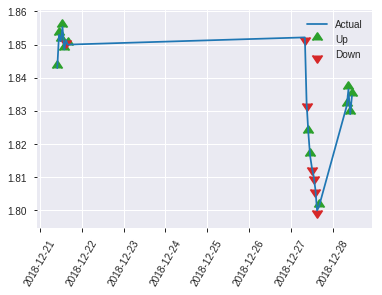


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.17550998969026135
RMSE: 0.4189391240863777
LogLoss: 0.5265324568587113
Null degrees of freedom: 219
Residual degrees of freedom: -817
Null deviance: 303.92457192432397
Residual deviance: 231.67428101783295
AIC: 2305.674281017833
AUC: 0.8201018448952334
pr_auc: 0.7905090222449004
Gini: 0.6402036897904668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35887703813213767: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      81   40   0.3306   (40.0/121.0)
1      18   81   0.1818   (18.0/99.0)
Total  99   121  0.2636   (58.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358877     0.736364  120
max f2                       0.231552     0.83935   157
max f0point5                 0.492929     0.744417  75
max accuracy                 0.470114     0.754545  84
max precision                0.921745     1         0
max recall                   0.0602427    1         213
max specificity              0.921745     1         0
max absolute_mcc             0.470114     0.501949  84
max min_per_class_accuracy   0.416792     0.747475  103
max mean_per_class_accuracy  0.416792     0.74977   103

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 40.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.88067            2.22222   2.22222            1                0.907461   1                           0.907461            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.822672           2.22222   2.22222            1                0.830088   1                           0.876512            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.814514           2.22222   2.22222            1                0.817551   1                           0.859666            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.804133           2.22222   2.22222            1                0.810368   1                           0.848711            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.79119            2.22222   2.22222            1                0.802311   1                           0.840274            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.725641           2.0202    2.12121            0.909091         0.760259   0.954545                    0.800267            0.10101         0.212121                   102.02    112.121
    7        0.15                        0.687683           1.81818   2.0202             0.818182         0.700138   0.909091                    0.76689             0.0909091       0.30303                    81.8182   102.02
    8        0.2                         0.628955           1.61616   1.91919            0.727273         0.662467   0.863636                    0.740785            0.0808081       0.383838                   61.6162   91.9192
    9        0.3                         0.532031           1.31313   1.71717            0.590909         0.570575   0.772727                    0.684048            0.131313        0.515152                   31.3131   71.7172
    10       0.4                         0.462298           1.41414   1.64141            0.636364         0.491971   0.738636                    0.636029            0.141414        0.656566                   41.4141   64.1414
    11       0.5                         0.396787           1.11111   1.53535            0.5              0.42829    0.690909                    0.594481            0.111111        0.767677                   11.1111   53.5354
    12       0.6                         0.328386           0.808081  1.41414            0.363636         0.359779   0.636364                    0.555364            0.0808081       0.848485                   -19.1919  41.4141
    13       0.7                         0.239567           0.808081  1.32756            0.363636         0.288568   0.597403                    0.51725             0.0808081       0.929293                   -19.1919  32.7561
    14       0.8                         0.177484           0.20202   1.18687            0.0909091        0.202373   0.534091                    0.477891            0.020202        0.949495                   -79.798   18.6869
    15       0.9                         0.109362           0.30303   1.08866            0.136364         0.143995   0.489899                    0.440791            0.030303        0.979798                   -69.697   8.86644
    16       1                           0.0124232          0.20202   1                  0.0909091        0.0668673  0.45                        

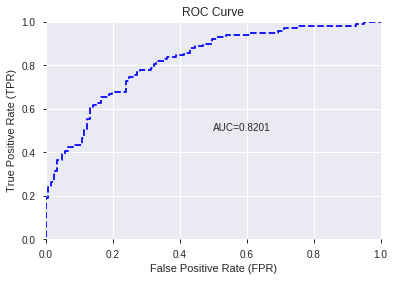

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


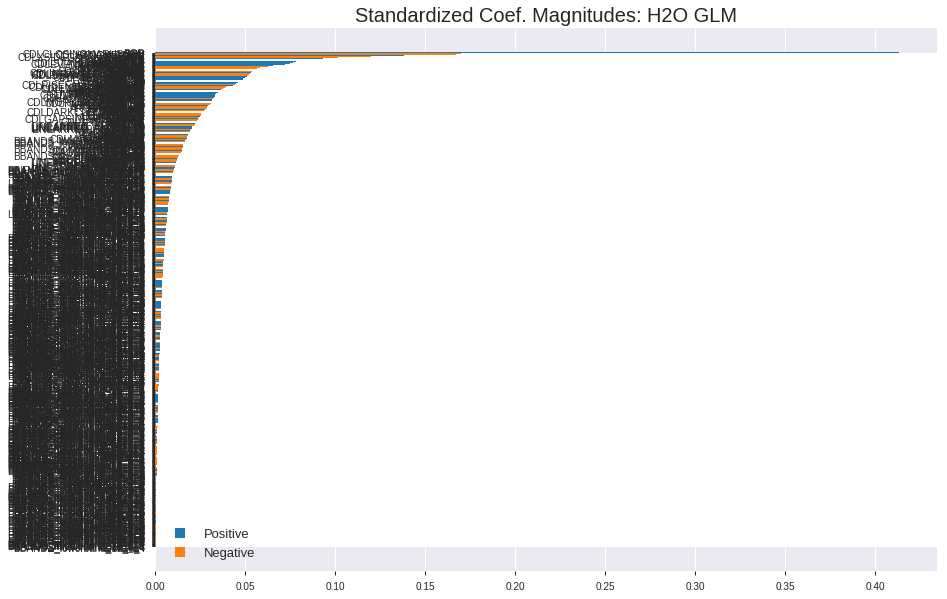

'log_likelihood'
--2019-08-28 13:15:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_131431_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_131431_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

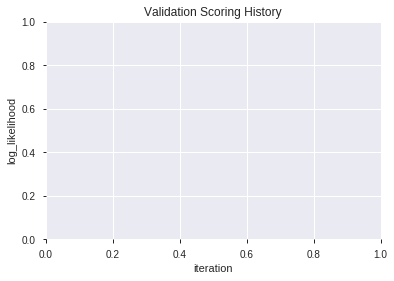

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_131558_model_4  0.838634  0.510934              0.232323  0.410682  0.168660
1  XGBoost_grid_1_AutoML_20190828_131558_model_7  0.837883  0.502096              0.215794  0.408701  0.167036
2               XGBoost_3_AutoML_20190828_131558  0.835963  0.503200              0.240588  0.408501  0.166873
3  XGBoost_grid_1_AutoML_20190828_131558_model_2  0.831956  0.511350              0.254821  0.412111  0.169835
4               XGBoost_2_AutoML_20190828_131558  0.831205  0.512127              0.259412  0.413015  0.170581
5  XGBoost_grid_1_AutoML_20190828_131558_model_6  0.826530  0.515866              0.239669  0.414360  0.171695
6  XGBoost_grid_1_AutoML_20190828_131558_model_1  0.826279  0.506299              0.254362  0.412008  0.169751
7               XGBoost_1_AutoML_20190828_131558  0.825945  0.514551              0.229109  0.414158  0.171527
8  XGBoost_grid_1_AutoML_20190828_131558_model_3  0.819100  0.519480              0.236915  0.417527  0.174329
9  XGBoost_grid_1_AutoML_20190828_131558_model_5  0.811170  0.522796              0.268595  0.419150  0.175686

variable  relative_importance  scaled_importance  percentage
0                        BOP          2216.652832           1.000000    0.372831
1                        DIV           509.335114           0.229777    0.085668
2               STOCHF_fastk           424.524445           0.191516    0.071403
3                     TRANGE           187.256088           0.084477    0.031496
4                     ULTOSC           173.784836           0.078400    0.029230
..                       ...                  ...                ...         ...
133               PLUS_DM_12             4.503694           0.002032    0.000758
134                    DX_24             4.431286           0.001999    0.000745
135                    ROC_8             4.379899           0.001976    0.000737
136              MINUS_DI_30             4.333533           0.001955    0.000729
137  BBANDS_lowerband_14_7_2             3.857032           0.001740    0.000649

[138 rows x 4 columns]

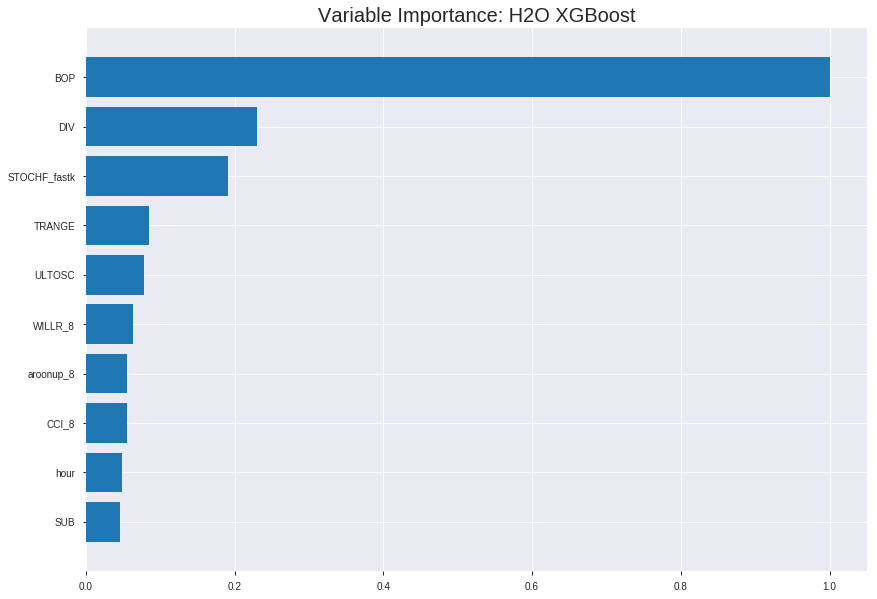

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_131558_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15201297274739378
RMSE: 0.3898884106348812
LogLoss: 0.4738094366878634
Mean Per-Class Error: 0.20494007754071575
AUC: 0.8738442797582033
pr_auc: 0.8632553451339819
Gini: 0.7476885595164067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46193235367536545: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      594  195  0.2471   (195.0/789.0)
1      124  622  0.1662   (124.0/746.0)
Total  718  817  0.2078   (319.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461932     0.795905  219
max f2                       0.28887      0.867819  299
max f0point5                 0.637713     0.805933  132
max accuracy                 0.511512     0.79544   195
max precision                0.907936     1         0
max recall                   0.140763     1         370
max specificity              0.907936     1         0
max absolute_mcc             0.511512     0.590451  195
max min_per_class_accuracy   0.491865     0.789607  203
max mean_per_class_accuracy  0.511512     0.79506   195

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.61 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.884593           2.05764    2.05764            1                0.895044  1                           0.895044            0.0214477       0.0214477                  105.764   105.764
    2        0.0201954                   0.87303            1.92046    1.99127            0.933333         0.878801  0.967742                    0.887184            0.0187668       0.0402145                  92.0465   99.1265
    3        0.0306189                   0.864573           1.92904    1.97008            0.9375           0.868398  0.957447                    0.880789            0.0201072       0.0603217                  92.9038   97.0082
    4        0.0403909                   0.854859           2.05764    1.99127            1                0.859577  0.967742                    0.875657            0.0201072       0.080429                   105.764   99.1265
    5        0.0501629                   0.846465           2.05764    2.0042             1                0.851703  0.974026                    0.870991            0.0201072       0.100536                   105.764   100.42
    6        0.100326                    0.81306            1.95075    1.97747            0.948052         0.828539  0.961039                    0.849765            0.0978552       0.198391                   95.075    97.7473
    7        0.150489                    0.776975           1.92403    1.95966            0.935065         0.795036  0.952381                    0.831522            0.0965147       0.294906                   92.4028   95.9658
    8        0.2                         0.738511           1.6786     1.89008            0.815789         0.757697  0.918567                    0.813246            0.0831099       0.378016                   67.8602   89.008
    9        0.300326                    0.660427           1.71025    1.83001            0.831169         0.699151  0.889371                    0.775132            0.171582        0.549598                   71.0247   83.0006
    10       0.4                         0.575287           1.35831    1.71247            0.660131         0.619447  0.832248                    0.736337            0.135389        0.684987                   35.8312   71.2466
    11       0.500326                    0.484674           1.14907    1.59949            0.558442         0.534996  0.777344                    0.695964            0.115282        0.800268                   14.9072   59.9494
    12       0.6                         0.395868           0.780021   1.46336            0.379085         0.441732  0.711183                    0.65373             0.077748        0.878016                   -21.9979  46.336
    13       0.699674                    0.313563           0.564843   1.33536            0.27451          0.3551    0.648976                    0.611188            0.0563003       0.934316                   -43.5157  33.5359
    14       0.8                         0.232023           0.440923   1.22319            0.214286         0.273103  0.594463                    0.56879             0.0442359       0.978552                   -55.9077  22.319
    15       0.899674                    0.147255           0.174832   1.10704            0.0849673        0.188843  0.538016                    0.526696            0.0174263       0.995979                   -82.5168  10.7044
    16       1                           0.082527           0.0400839  1                  0.0194805        0.122369  0.485993                    0.4



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19058020091151817
RMSE: 0.4365549231328381
LogLoss: 0.5602310990417837
Mean Per-Class Error: 0.2953122391050258
AUC: 0.7831127901152113
pr_auc: 0.7639804185881172
Gini: 0.5662255802304226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3016679883003235: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  112  0.5283   (112.0/212.0)
1      17   209  0.0752   (17.0/226.0)
Total  117  321  0.2945   (129.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301668     0.764168  296
max f2                       0.146073     0.871418  357
max f0point5                 0.599651     0.728477  155
max accuracy                 0.426785     0.707763  243
max precision                0.910454     1         0
max recall                   0.134281     1         365
max specificity              0.910454     1         0
max absolute_mcc             0.301668     0.447811  296
max min_per_class_accuracy   0.502013     0.69469   204
max mean_per_class_accuracy  0.426785     0.704688  243

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 49.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.888413           1.55044    1.55044            0.8              0.898184  0.8                         0.898184            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.878221           1.93805    1.72271            1                0.883745  0.888889                    0.891767            0.0176991       0.0353982                  93.8053   72.2714
    3        0.0319635                   0.870919           1.55044    1.66119            0.8              0.874733  0.857143                    0.885683            0.0176991       0.0530973                  55.0442   66.1188
    4        0.0410959                   0.858173           1.93805    1.72271            1                0.865263  0.888889                    0.881146            0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.849803           1.93805    1.76187            1                0.855331  0.909091                    0.876452            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.817279           1.58568    1.67377            0.818182         0.835346  0.863636                    0.855899            0.079646        0.168142                   58.568    67.3773
    7        0.150685                    0.776725           1.67377    1.67377            0.863636         0.798197  0.863636                    0.836665            0.0840708       0.252212                   67.3773   67.3773
    8        0.200913                    0.741141           1.58568    1.65175            0.818182         0.757755  0.852273                    0.816938            0.079646        0.331858                   58.568    65.175
    9        0.30137                     0.660565           1.36545    1.55632            0.704545         0.698993  0.80303                     0.777623            0.137168        0.469027                   36.5447   55.6315
    10       0.399543                    0.591056           1.17185    1.46185            0.604651         0.627548  0.754286                    0.740747            0.115044        0.584071                   17.1846   46.1846
    11       0.5                         0.506125           1.05712    1.38053            0.545455         0.55229   0.712329                    0.702884            0.106195        0.690265                   5.71199   38.0531
    12       0.600457                    0.428287           1.05712    1.32642            0.545455         0.464396  0.684411                    0.662985            0.106195        0.79646                    5.71199   32.6424
    13       0.69863                     0.330951           0.856349   1.26037            0.44186          0.372568  0.650327                    0.622174            0.0840708       0.880531                   -14.3651  26.0368
    14       0.799087                    0.222242           0.704747   1.19052            0.363636         0.280806  0.614286                    0.57926             0.0707965       0.951327                   -29.5253  19.0518
    15       0.899543                    0.13605            0.440467   1.10676            0.227273         0.169232  0.571066                    0.53347             0.0442478       0.995575                   -55.9533  10.6756
    16       1                           0.0821426          0.0440467  1                  0.0227273        0.118419  0.515982                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:16:35  16.395 sec  0                  0.5              0.693147            0.5             0                  1                0.514007                         0.5                0.693147              0.5               0                    1                  0.484018
    2019-08-28 13:16:36  17.558 sec  5                  0.473514         0.641231            0.812003        0.716609           1.97308          0.284691                         0.479136           0.652015              0.759632          0.695818             1.61504            0.342466
    2019-08-28 13:16:37  17.903 sec  10                 0.454505         0.604451            0.820777        0.72229            1.97308          0.285993                         0.465146           0.624438              0.766896          0.694985             1.61504            0.328767
    2019-08-28 13:16:37  18.250 sec  15                 0.441681         0.579333            0.826206        0.811104           2.05764          0.299674                         0.45576            0.605504              0.77107           0.755147             1.55044            0.308219
    2019-08-28 13:16:37  18.575 sec  20                 0.430783         0.557641            0.833363        0.818948           2.05764          0.263844                         0.448645           0.590622              0.776037          0.755608             1.55044            0.317352
    2019-08-28 13:16:38  18.936 sec  25                 0.423215         0.542251            0.838876        0.828894           2.05764          0.252117                         0.444635           0.581616              0.775787          0.754086             1.55044            0.308219
    2019-08-28 13:16:38  19.268 sec  30                 0.417447         0.530181            0.842549        0.831142           2.05764          0.254723                         0.44237            0.576079              0.77754           0.757297             1.93805            0.303653
    2019-08-28 13:16:38  19.600 sec  35                 0.412438         0.519985            0.848379        0.837472           2.05764          0.248208                         0.440449           0.571286              0.778469          0.764699             1.93805            0.303653
    2019-08-28 13:16:39  19.956 sec  40                 0.408283         0.511409            0.852967        0.843301           2.05764          0.231922                         0.44012            0.569812              0.776455          0.760373             1.55044            0.30137
    2019-08-28 13:16:39  20.291 sec  45                 0.404545         0.503315            0.856047        0.846464           2.05764          0.224104                         0.439082           0.566957              0.777707          0.764224             1.93805            0.294521
    2019-08-28 13:16:39  20.640 sec  50                 0.401056         0.496021            0.85952         0.849673           2.05764          0.235831                         0.437799           0.563973              0.780723          0.765258             1.55044            0.296804
    2019-08-28 13:16:40  20.995 sec  55                 0.39797          0.489603            0.862838        0.851617           2.05764          0.224104                         0.436833           0.561567              0.782549          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2216.65283203125       1.0                    0.37283067867458325
DIV                      509.3351135253906      0.22977667326401166    0.08566779303660943
STOCHF_fastk             424.5244445800781      0.19151598231603154    0.07140303366391552
TRANGE                   187.25608825683594     0.08447695802921115    0.03149560159439508
ULTOSC                   173.7848358154297      0.07839966335918302    0.02922979969806307
---                      ---                    ---                    ---
PLUS_DM_12               4.503693580627441      0.0020317541455061507  0.0007575002769689562
DX_24                    4.431285858154297      0.001999088803677772   0.0007453216354059445
ROC_8                    4.379898548126221      0.00197590641386665    0.0007366785292793651
MINUS_DI_30              4.33353328704834       0.0019549896241881355  0.000728880108387831
BBANDS_lowerband_14_7_2  3.857032060623169      0.0017400253232657738  0.0006487348221841397


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.759090909090909)

('F1', 0.7672413793103449)

('auc', 0.8386342766508056)

('logloss', 0.5109336956701704)

('mean_per_class_error', 0.23232323232323226)

('rmse', 0.4106823163216807)

('mse', 0.168659964939341)

xgboost prediction progress: |████████████████████████████████████████████| 100%


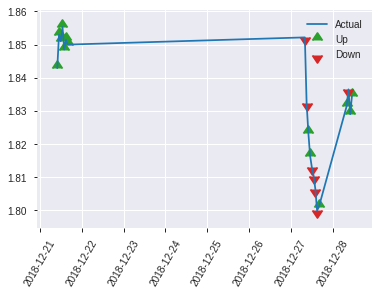


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.168659964939341
RMSE: 0.4106823163216807
LogLoss: 0.5109336956701704
Mean Per-Class Error: 0.23232323232323226
AUC: 0.8386342766508056
pr_auc: 0.8004607392423284
Gini: 0.6772685533016112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3753209114074707: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   44   0.3636   (44.0/121.0)
1      10   89   0.101    (10.0/99.0)
Total  87   133  0.2455   (54.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375321     0.767241  132
max f2                       0.346608     0.855019  141
max f0point5                 0.533407     0.746988  78
max accuracy                 0.504953     0.759091  89
max precision                0.893656     1         0
max recall                   0.155006     1         195
max specificity              0.893656     1         0
max absolute_mcc             0.375321     0.54471   132
max min_per_class_accuracy   0.45185      0.743802  104
max mean_per_class_accuracy  0.375321     0.767677  132

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 44.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.875438           2.22222   2.22222            1                0.886555  1                           0.886555            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.858091           2.22222   2.22222            1                0.862737  1                           0.877028            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.849612           2.22222   2.22222            1                0.854392  1                           0.870561            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.834285           2.22222   2.22222            1                0.844008  1                           0.86466             0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.82087            2.22222   2.22222            1                0.826973  1                           0.857808            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.748129           2.0202    2.12121            0.909091         0.784594  0.954545                    0.821201            0.10101         0.212121                   102.02    112.121
    7        0.15                        0.692225           1.61616   1.95286            0.727273         0.721911  0.878788                    0.788104            0.0808081       0.292929                   61.6162   95.2862
    8        0.2                         0.647683           1.61616   1.86869            0.727273         0.677652  0.840909                    0.760491            0.0808081       0.373737                   61.6162   86.8687
    9        0.3                         0.56828            1.61616   1.78451            0.727273         0.608758  0.80303                     0.709913            0.161616        0.535354                   61.6162   78.4512
    10       0.4                         0.5076             1.31313   1.66667            0.590909         0.535872  0.75                        0.666403            0.131313        0.666667                   31.3131   66.6667
    11       0.5                         0.440601           0.909091  1.51515            0.409091         0.474628  0.681818                    0.628048            0.0909091       0.757576                   -9.09091  51.5152
    12       0.6                         0.376806           1.31313   1.48148            0.590909         0.411355  0.666667                    0.591932            0.131313        0.888889                   31.3131   48.1481
    13       0.7                         0.292212           0.505051  1.34199            0.227273         0.339235  0.603896                    0.555833            0.0505051       0.939394                   -49.4949  34.1991
    14       0.8                         0.226121           0.20202   1.19949            0.0909091        0.258206  0.539773                    0.518629            0.020202        0.959596                   -79.798   19.9495
    15       0.9                         0.150855           0.40404   1.11111            0.181818         0.188485  0.5                         0.481947            0.040404        1                          -59.596   11.1111
    16       1                           0.0982439          0         1                  0                0.12172   0.45                        0.445924         

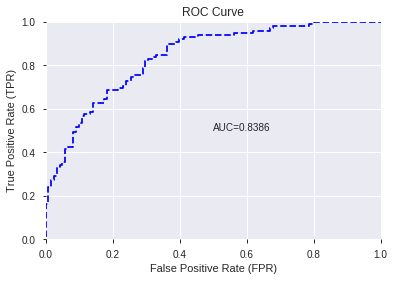

This function is available for GLM models only


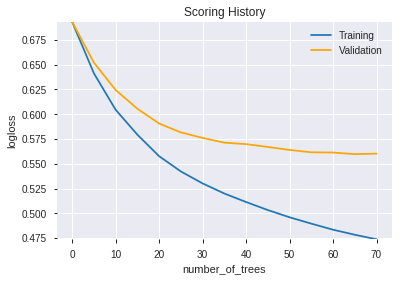

--2019-08-28 13:17:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_131558_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_131558_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_131713_model_5  0.837048  0.507497              0.229109  0.408084  0.166533
1  DeepLearning_grid_1_AutoML_20190828_131713_model_9  0.837048  0.530305              0.224977  0.418995  0.175557
2  DeepLearning_grid_1_AutoML_20190828_131713_model_8  0.830370  0.529032              0.247934  0.421314  0.177506
3  DeepLearning_grid_1_AutoML_20190828_131713_model_6  0.828617  0.510279              0.245179  0.413943  0.171349
4               DeepLearning_1_AutoML_20190828_131713  0.819601  0.520861              0.254821  0.421344  0.177531
5  DeepLearning_grid_1_AutoML_20190828_131713_model_7  0.818933  0.581122              0.263085  0.441363  0.194802
6  DeepLearning_grid_1_AutoML_20190828_131713_model_3  0.815260  0.547990              0.245179  0.429005  0.184045
7  DeepLearning_grid_1_AutoML_20190828_131713_model_4  0.809750  0.642157              0.287879  0.450740  0.203167
8  DeepLearning_grid_1_AutoML_20190828_131713_model_2  0.798815  0.602745              0.273646  0.451685  0.204019
9  DeepLearning_grid_1_AutoML_20190828_131713_model_1  0.795392  0.621174              0.292470  0.448736  0.201364

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.038445
1     CDLCLOSINGMARUBOZU             0.762961           0.762961    0.029332
2            CDLLONGLINE             0.703734           0.703734    0.027055
3           HT_TRENDMODE             0.671024           0.671024    0.025797
4                   hour             0.663218           0.663218    0.025497
5          CDLHANGINGMAN             0.649920           0.649920    0.024986
6                    DIV             0.636354           0.636354    0.024464
7                  CCI_8             0.624184           0.624184    0.023997
8          days_in_month             0.622123           0.622123    0.023917
9                    SUB             0.618775           0.618775    0.023789
10            aroonup_24             0.609832           0.609832    0.023445
11               BETA_30             0.604000           0.604000    0.023221
12             aroonup_8             0.600987           0.600987    0.023105
13  HT_PHASOR_quadrature             0.593025           0.593025    0.022799
14                TRANGE             0.585075           0.585075    0.022493
15                Volume             0.581932           0.581932    0.022372
16             CORREL_14             0.581284           0.581284    0.022347
17                SAREXT             0.573380           0.573380    0.022043
18          STOCHF_fastk             0.559077           0.559077    0.021494
19                ULTOSC             0.555617           0.555617    0.021361
20        STOCHRSI_fastk             0.541343           0.541343    0.020812
21            aroonup_12             0.536647           0.536647    0.020631
22             PLUS_DI_8             0.531870           0.531870    0.020448
23               WILLR_8             0.483404           0.483404    0.018584
24          CDLSHORTLINE             0.482500           0.482500    0.018550
25             CDLHAMMER             0.469696           0.469696    0.018057
26              WILLR_30             0.458422           0.458422    0.017624
27        CDLRICKSHAWMAN             0.456172           0.456172    0.017537
28           CDLBELTHOLD             0.450198           0.450198    0.017308
29              WILLR_20             0.449248           0.449248    0.017271
30            ROCR100_20             0.444754           0.444754    0.017098
31             CDLHARAMI             0.435050           0.435050    0.016725
32   CDLXSIDEGAP3METHODS             0.433349           0.433349    0.016660
33                ROCP_8             0.431136           0.431136    0.016575
34           CDLMARUBOZU             0.429746           0.429746    0.016521
35            PLUS_DI_12             0.428939           0.428939    0.016490
36             CDLTAKURI             0.427142           0.427142    0.016421
37          CDLENGULFING             0.427000           0.427000    0.016416
38              WILLR_12             0.423224           0.423224    0.016271
39                ROCR_8             0.423086           0.423086    0.016265
40             ROCR100_8             0.419715           0.419715    0.016136
41              WILLR_14             0.414000           0.414000    0.015916
42                 MOM_8             0.413924           0.413924    0.015913
43             PLUS_DM_8             0.413254           0.413254    0.015887
44              WILLR_24             0.411100           0.411100    0.015805
45                RSI_12             0.409498           0.409498    0.015743
46      CDLDRAGONFLYDOJI             0.406822           0.406822    0.015640
47                 ROC_8             0.400810           0.400810    0.015409
48                CMO_14             0.398730           0.398730    0.015329
49                 CMO_8             0.364099           0.364099    0.013998

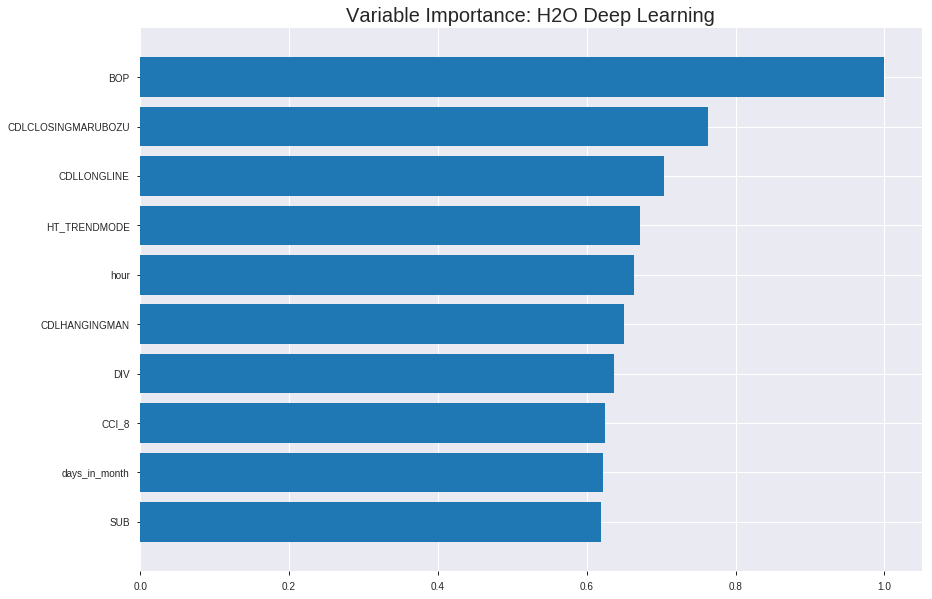

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_131713_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15541301012527323
RMSE: 0.39422456814013157
LogLoss: 0.46872338372600875
Mean Per-Class Error: 0.2298248028352311
AUC: 0.8590692395777055
pr_auc: 0.8490584904212709
Gini: 0.7181384791554111
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48639654245606656: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      573  216  0.2738   (216.0/789.0)
1      141  605  0.189    (141.0/746.0)
Total  714  821  0.2326   (357.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486397     0.772176  209
max f2                       0.308293     0.868884  293
max f0point5                 0.661707     0.796767  129
max accuracy                 0.522953     0.770684  191
max precision                0.998178     1         0
max recall                   0.0705855    1         371
max specificity              0.998178     1         0
max absolute_mcc             0.522953     0.540855  191
max min_per_class_accuracy   0.512657     0.768061  196
max mean_per_class_accuracy  0.522953     0.770175  191

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 51.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.993298           2.05764    2.05764            1                0.995877   1                           0.995877            0.0214477       0.0214477                  105.764   105.764
    2        0.0201954                   0.988569           1.92046    1.99127            0.933333         0.990725   0.967742                    0.993384            0.0187668       0.0402145                  92.0465   99.1265
    3        0.0306189                   0.98257            2.05764    2.01386            1                0.985783   0.978723                    0.990797            0.0214477       0.0616622                  105.764   101.386
    4        0.0403909                   0.977833           2.05764    2.02445            1                0.980564   0.983871                    0.988321            0.0201072       0.0817694                  105.764   102.445
    5        0.0501629                   0.972798           2.05764    2.03092            1                0.974926   0.987013                    0.985711            0.0201072       0.101877                   105.764   103.092
    6        0.100326                    0.927241           1.95075    1.99083            0.948052         0.95181    0.967532                    0.968761            0.0978552       0.199732                   95.075    99.0834
    7        0.150489                    0.861257           1.89731    1.95966            0.922078         0.895253   0.952381                    0.944258            0.0951743       0.294906                   89.7305   95.9658
    8        0.2                         0.795778           1.75982    1.91019            0.855263         0.82917    0.928339                    0.915767            0.0871314       0.382038                   75.9824   91.0188
    9        0.300326                    0.663341           1.69689    1.83893            0.824675         0.729293   0.893709                    0.853474            0.170241        0.552279                   69.6886   83.8933
    10       0.4                         0.574118           1.18348    1.6756             0.575163         0.618396   0.814332                    0.794896            0.117962        0.670241                   18.348    67.5603
    11       0.500326                    0.506155           1.05554    1.55127            0.512987         0.537915   0.753906                    0.743366            0.105898        0.776139                   5.5543    55.1268
    12       0.6                         0.445043           0.739675   1.41644            0.359477         0.476034   0.688382                    0.698956            0.0737265       0.849866                   -26.0325  41.6443
    13       0.699674                    0.362419           0.780021   1.32578            0.379085         0.405342   0.64432                     0.657128            0.077748        0.927614                   -21.9979  32.578
    14       0.8                         0.255608           0.521091   1.22487            0.253247         0.314407   0.595277                    0.614149            0.0522788       0.979893                   -47.8909  22.4866
    15       0.899674                    0.107448           0.161384   1.10704            0.0784314        0.190319   0.538016                    0.567193            0.0160858       0.995979                   -83.8616  10.7044
    16       1                           0.00198251         0.0400839  1                  0.0194805        0.0499491  0.485993  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1902826507695418
RMSE: 0.4362139965309937
LogLoss: 0.563815666112073
Mean Per-Class Error: 0.2829562531307397
AUC: 0.7839163466354984
pr_auc: 0.7765367422867913
Gini: 0.5678326932709967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32728196457068726: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      99   113  0.533    (113.0/212.0)
1      24   202  0.1062   (24.0/226.0)
Total  123  315  0.3128   (137.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327282     0.746765  288
max f2                       0.131798     0.871418  354
max f0point5                 0.614758     0.732662  152
max accuracy                 0.510768     0.716895  200
max precision                0.997277     1         0
max recall                   0.0749008    1         365
max specificity              0.997277     1         0
max absolute_mcc             0.510768     0.43387   200
max min_per_class_accuracy   0.50805      0.716814  202
max mean_per_class_accuracy  0.510768     0.717044  200

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.990533           1.93805    1.93805            1                0.994131   1                           0.994131            0.0221239       0.0221239                  93.8053   93.8053
    2        0.0205479                   0.986061           0.969027   1.50737            0.5              0.987815   0.777778                    0.991324            0.00884956      0.0309735                  -3.09735  50.7375
    3        0.0319635                   0.980124           1.93805    1.66119            1                0.982755   0.857143                    0.988263            0.0221239       0.0530973                  93.8053   66.1188
    4        0.0410959                   0.977859           1.93805    1.72271            1                0.978338   0.888889                    0.986058            0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.975011           1.93805    1.76187            1                0.976769   0.909091                    0.984369            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.928677           1.67377    1.71782            0.863636         0.955326   0.886364                    0.969847            0.0840708       0.172566                   67.3773   71.782
    7        0.150685                    0.879709           1.58568    1.67377            0.818182         0.901136   0.863636                    0.946943            0.079646        0.252212                   58.568    67.3773
    8        0.200913                    0.806985           1.67377    1.67377            0.863636         0.845719   0.863636                    0.921637            0.0840708       0.336283                   67.3773   67.3773
    9        0.30137                     0.682688           1.36545    1.571              0.704545         0.743922   0.810606                    0.862399            0.137168        0.473451                   36.5447   57.0998
    10       0.399543                    0.587994           1.21692    1.48399            0.627907         0.635938   0.765714                    0.806754            0.119469        0.59292                    21.6917   48.3995
    11       0.5                         0.51153            1.14521    1.41593            0.590909         0.546873   0.730594                    0.754541            0.115044        0.707965                   14.5213   41.5929
    12       0.600457                    0.45457            0.836887   1.31906            0.431818         0.481662   0.680608                    0.708888            0.0840708       0.792035                   -16.3113  31.9055
    13       0.69863                     0.350108           0.811278   1.2477             0.418605         0.400436   0.643791                    0.665543            0.079646        0.871681                   -18.8722  24.7701
    14       0.799087                    0.228734           0.704747   1.17944            0.363636         0.291977   0.608571                    0.618581            0.0707965       0.942478                   -29.5253  17.9444
    15       0.899543                    0.107771           0.52856    1.10676            0.272727         0.165963   0.571066                    0.568035            0.0530973       0.995575                   -47.144   10.6756
    16       1                           0.00240959         0.0440467  1                  0.0227273        0.0445759  0.515982  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:20:24  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:20:26  1 min 28.002 sec  1111 obs/sec      1.47883   1             2270       0.425846         0.541916            0.274053       0.803357        0.784866           1.92904          0.284691                         0.440773           0.571973              0.22208          0.773032          0.76957              1.55044            0.276256
    2019-08-28 13:20:32  1 min 34.028 sec  1823 obs/sec      8.89381   6             13652      0.414504         0.511688            0.312205       0.825138        0.814599           2.05764          0.284039                         0.441342           0.578821              0.220073         0.781662          0.77979              1.55044            0.30137
    2019-08-28 13:20:38  1 min 40.196 sec  2082 obs/sec      17.755    12            27254      0.394225         0.468723            0.37786        0.859069        0.849058           2.05764          0.232573                         0.436214           0.563816              0.238091         0.783916          0.776537             1.93805            0.312785
    2019-08-28 13:20:44  1 min 46.110 sec  2219 obs/sec      26.6469   18            40903      0.379194         0.433826            0.424395       0.874952        0.873997           2.05764          0.242997                         0.46063            0.636225              0.150411         0.759392          0.745193             1.93805            0.305936
    2019-08-28 13:20:51  1 min 52.380 sec  2165 obs/sec      34.0476   23            52263      0.359156         0.399249            0.483624       0.905254        0.897867           2.05764          0.192182                         0.455348           0.61599               0.169786         0.758088          0.752446             1.93805            0.358447
    2019-08-28 13:20:57  1 min 58.768 sec  2276 obs/sec      44.4137   30            68175      0.351564         0.382497            0.505222       0.919238        0.907262           2.05764          0.177199                         0.466204           0.668743              0.129725         0.744312          0.72976              1.55044            0.324201
    2019-08-28 13:20:58  1 min 59.357 sec  2275 obs/sec      44.4137   30            68175      0.394225         0.468723            0.37786        0.859069        0.849058           2.05764          0.232573                         0.436214           0.563816              0.238091         0.783916          0.776537             1.93805            0.312785

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03844471663578711
CDLCLOSINGMARUBOZU  0.7629606127738953     0.7629606127738953   0.0293318045623589
CDLLONGLINE         0.703734278678894      0.703734278678894    0.02705486493070012
HT_TRENDMODE        0.671023964881897      0.671023964881897    0.02579732618570689
hour                0.6632179021835327     0.6632179021835327   0.025497224317227087
---                 ---                    ---                  ---
RSI_12              0.4094976484775543     0.4094976484775543   0.015743021058740734
CDLDRAGONFLYDOJI    0.40682196617126465    0.40682196617126465  0.015640155210668038
ROC_8               0.40080952644348145    0.40080952644348145  0.015409008669043664
CMO_14              0.39873045682907104    0.39873045682907104  0.015329079426851583
CMO_8               0.3640987277030945     0.3640987277030945   0.013997672413996078


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7727272727272727)

('F1', 0.7559808612440191)

('auc', 0.83704816762668)

('logloss', 0.5074966353327178)

('mean_per_class_error', 0.2286501377410468)

('rmse', 0.4080840574968461)

('mse', 0.1665325979830892)

deeplearning prediction progress: |███████████████████████████████████████| 100%


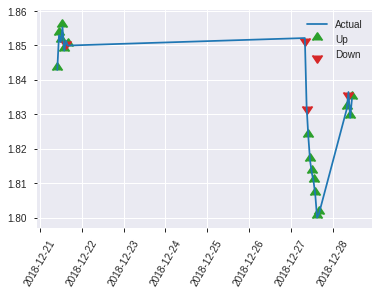


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1665325979830892
RMSE: 0.4080840574968461
LogLoss: 0.5074966353327178
Mean Per-Class Error: 0.2286501377410468
AUC: 0.83704816762668
pr_auc: 0.7865190998866818
Gini: 0.67409633525336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4885431641318804: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   31   0.2562   (31.0/121.0)
1      20   79   0.202    (20.0/99.0)
Total  110  110  0.2318   (51.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488543     0.755981  109
max f2                       0.297626     0.861456  166
max f0point5                 0.586896     0.759036  78
max accuracy                 0.512786     0.772727  100
max precision                0.996861     1         0
max recall                   0.14629      1         191
max specificity              0.996861     1         0
max absolute_mcc             0.512786     0.541796  100
max min_per_class_accuracy   0.508844     0.767677  103
max mean_per_class_accuracy  0.512786     0.77135   100

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 49.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.994937           2.22222   2.22222            1                0.996095   1                           0.996095            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.994359           1.11111   1.77778            0.5              0.994553   0.8                         0.995478            0.010101        0.040404                   11.1111   77.7778
    3        0.0318182                   0.991336           2.22222   1.90476            1                0.993707   0.857143                    0.994972            0.020202        0.0606061                  122.222   90.4762
    4        0.0409091                   0.988751           2.22222   1.97531            1                0.989483   0.888889                    0.993752            0.020202        0.0808081                  122.222   97.5309
    5        0.05                        0.98191            2.22222   2.0202             1                0.986497   0.909091                    0.992433            0.020202        0.10101                    122.222   102.02
    6        0.1                         0.934656           2.0202    2.0202             0.909091         0.96733    0.909091                    0.979882            0.10101         0.20202                    102.02    102.02
    7        0.15                        0.826639           2.22222   2.08754            1                0.887657   0.939394                    0.94914             0.111111        0.313131                   122.222   108.754
    8        0.2                         0.762061           1.21212   1.86869            0.545455         0.797227   0.840909                    0.911162            0.0606061       0.373737                   21.2121   86.8687
    9        0.3                         0.633359           1.61616   1.78451            0.727273         0.684992   0.80303                     0.835772            0.161616        0.535354                   61.6162   78.4512
    10       0.4                         0.545138           1.41414   1.69192            0.636364         0.589982   0.761364                    0.774324            0.141414        0.676768                   41.4141   69.1919
    11       0.5                         0.488134           1.21212   1.59596            0.545455         0.518859   0.718182                    0.723231            0.121212        0.79798                    21.2121   59.596
    12       0.6                         0.417119           0.606061  1.43098            0.272727         0.454893   0.643939                    0.678508            0.0606061       0.858586                   -39.3939  43.0976
    13       0.7                         0.356801           0.606061  1.31313            0.272727         0.395783   0.590909                    0.638119            0.0606061       0.919192                   -39.3939  31.3131
    14       0.8                         0.234418           0.606061  1.22475            0.272727         0.299497   0.551136                    0.595791            0.0606061       0.979798                   -39.3939  22.4747
    15       0.9                         0.115904           0.20202   1.11111            0.0909091        0.176991   0.5                         0.549258            0.020202        1                          -79.798   11.1111
    16       1                           0.00690741         0         1                  0                0.0532716  0.45                        0.

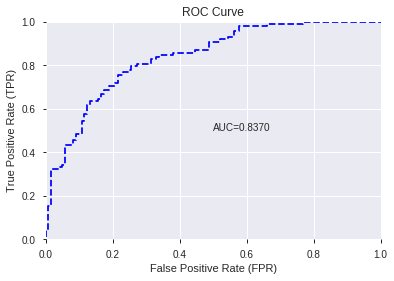

This function is available for GLM models only


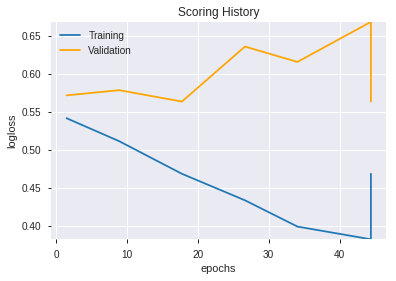

--2019-08-28 13:25:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.96.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.96.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_131713_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_131713_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'HT_TRENDMODE',
 'hour',
 'CDLHANGINGMAN',
 'DIV',
 'CCI_8',
 'days_in_month',
 'SUB',
 'aroonup_24',
 'BETA_30',
 'aroonup_8',
 'HT_PHASOR_quadrature',
 'TRANGE',
 'Volume',
 'CORREL_14',
 'SAREXT',
 'STOCHF_fastk',
 'ULTOSC',
 'STOCHRSI_fastk',
 'aroonup_12',
 'PLUS_DI_8',
 'WILLR_8',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'WILLR_30',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'WILLR_20',
 'ROCR100_20',
 'CDLHARAMI',
 'CDLXSIDEGAP3METHODS',
 'ROCP_8',
 'CDLMARUBOZU',
 'PLUS_DI_12',
 'CDLTAKURI',
 'CDLENGULFING',
 'WILLR_12',
 'ROCR_8',
 'ROCR100_8',
 'WILLR_14',
 'MOM_8',
 'PLUS_DM_8',
 'WILLR_24',
 'RSI_12',
 'CDLDRAGONFLYDOJI',
 'ROC_8',
 'CMO_14',
 'CMO_8']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_132511_model_1  0.835963  0.507156              0.217172  0.409175  0.167424

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.662145           1.000000    0.151801
1                  CCI_8             0.314725           0.475312    0.072153
2     CDLCLOSINGMARUBOZU             0.244655           0.369489    0.056089
3           STOCHF_fastk             0.241466           0.364672    0.055358
4          CDLHANGINGMAN             0.218810           0.330457    0.050164
5                    SUB             0.179724           0.271427    0.041203
6              PLUS_DI_8             0.174049           0.262857    0.039902
7                   hour             0.153881           0.232397    0.035278
8                    DIV             0.147271           0.222415    0.033763
9                 ULTOSC             0.126660           0.191287    0.029038
10   CDLXSIDEGAP3METHODS             0.111330           0.168135    0.025523
11               WILLR_8             0.096035           0.145037    0.022017
12             CDLHAMMER             0.091970           0.138897    0.021085
13            aroonup_24             0.089327           0.134906    0.020479
14  HT_PHASOR_quadrature             0.089072           0.134521    0.020420
15             CORREL_14             0.088375           0.133468    0.020261
16           CDLLONGLINE             0.080680           0.121846    0.018496
17            aroonup_12             0.078993           0.119298    0.018110
18            PLUS_DI_12             0.074926           0.113157    0.017177
19              WILLR_14             0.067156           0.101421    0.015396
20              WILLR_12             0.064755           0.097796    0.014846
21                TRANGE             0.059704           0.090167    0.013687
22           CDLMARUBOZU             0.054052           0.081631    0.012392
23            ROCR100_20             0.053822           0.081284    0.012339
24          CDLENGULFING             0.050260           0.075905    0.011522
25              WILLR_20             0.049378           0.074573    0.011320
26             aroonup_8             0.049091           0.074140    0.011254
27             CDLHARAMI             0.048483           0.073221    0.011115
28           CDLBELTHOLD             0.047569           0.071841    0.010906
29         days_in_month             0.047063           0.071077    0.010790
30                 CMO_8             0.043648           0.065919    0.010007
31          HT_TRENDMODE             0.041741           0.063039    0.009569
32                SAREXT             0.037434           0.056534    0.008582
33                RSI_12             0.037032           0.055927    0.008490
34      CDLDRAGONFLYDOJI             0.034854           0.052638    0.007991
35             CDLTAKURI             0.034625           0.052292    0.007938
36                CMO_14             0.034458           0.052040    0.007900
37              WILLR_24             0.028763           0.043440    0.006594
38                 ROC_8             0.026334           0.039771    0.006037
39             ROCR100_8             0.025774           0.038925    0.005909
40                ROCP_8             0.025579           0.038630    0.005864
41                ROCR_8             0.025411           0.038377    0.005826
42        CDLRICKSHAWMAN             0.025292           0.038198    0.005798
43             PLUS_DM_8             0.023384           0.035316    0.005361
44               BETA_30             0.018321           0.027669    0.004200
45                Volume             0.015226           0.022996    0.003491
46          CDLSHORTLINE             0.013616           0.020563    0.003121
47                 MOM_8             0.005649           0.008531    0.001295
48              WILLR_30             0.005111           0.007719    0.001172
49        STOCHRSI_fastk             0.004234           0.006394    0.000971

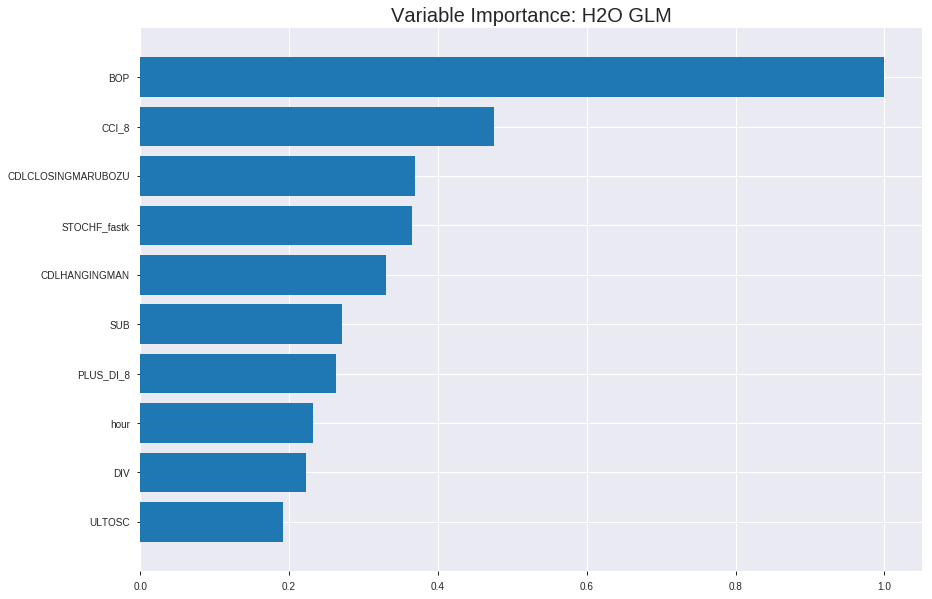

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_132511_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17747722444840247
RMSE: 0.42128045818480886
LogLoss: 0.5320026321470056
Null degrees of freedom: 1534
Residual degrees of freedom: 1484
Null deviance: 2126.7571264665794
Residual deviance: 1633.2480806913072
AIC: 1735.2480806913072
AUC: 0.8126518449049769
pr_auc: 0.8027848474069398
Gini: 0.6253036898099538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42649156649298015: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      511  278  0.3523   (278.0/789.0)
1      137  609  0.1836   (137.0/746.0)
Total  648  887  0.2704   (415.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426492     0.745867  228
max f2                       0.262535     0.841525  301
max f0point5                 0.603755     0.740864  151
max accuracy                 0.500101     0.74202   196
max precision                0.975884     1         0
max recall                   0.0346792    1         395
max specificity              0.975884     1         0
max absolute_mcc             0.497049     0.483978  197
max min_per_class_accuracy   0.500101     0.741287  196
max mean_per_class_accuracy  0.497049     0.742073  197

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.936659           1.92904   1.92904            0.9375           0.950769   0.9375                      0.950769            0.0201072       0.0201072                  92.9038   92.9038
    2        0.0201954                   0.920322           1.92046   1.92489            0.933333         0.92697    0.935484                    0.939253            0.0187668       0.038874                   92.0465   92.489
    3        0.0306189                   0.897131           2.05764   1.97008            1                0.905315   0.957447                    0.9277              0.0214477       0.0603217                  105.764   97.0082
    4        0.0403909                   0.884508           2.05764   1.99127            1                0.890415   0.967742                    0.918679            0.0201072       0.080429                   105.764   99.1265
    5        0.0501629                   0.874055           1.92046   1.97747            0.933333         0.87865    0.961039                    0.910881            0.0187668       0.0991957                  92.0465   97.7473
    6        0.100326                    0.813722           1.84386   1.91067            0.896104         0.840772   0.928571                    0.875827            0.0924933       0.191689                   84.386    91.0666
    7        0.150489                    0.772701           1.76369   1.86167            0.857143         0.791969   0.904762                    0.847874            0.0884718       0.280161                   76.3692   86.1675
    8        0.2                         0.7247             1.62445   1.80295            0.789474         0.751096   0.876221                    0.823916            0.080429        0.36059                    62.4453   80.2949
    9        0.300326                    0.652905           1.4831    1.6961             0.720779         0.68761    0.824295                    0.778382            0.148794        0.509383                   48.3105   69.6103
    10       0.4                         0.57361            1.25072   1.58512            0.607843         0.615711   0.770358                    0.737847            0.124665        0.634048                   25.0723   58.5121
    11       0.500326                    0.489171           1.13571   1.495              0.551948         0.533248   0.726562                    0.696821            0.113941        0.747989                   13.5711   49.5005
    12       0.6                         0.407973           0.793469  1.37846            0.385621         0.449496   0.669924                    0.655734            0.0790885       0.827078                   -20.6531  37.8463
    13       0.699674                    0.326072           0.753123  1.28938            0.366013         0.367437   0.626629                    0.614664            0.075067        0.902145                   -24.6877  28.9378
    14       0.8                         0.234874           0.440923  1.18298            0.214286         0.283143   0.574919                    0.573089            0.0442359       0.946381                   -55.9077  18.2976
    15       0.899674                    0.137746           0.309319  1.08618            0.150327         0.185649   0.527878                    0.530165            0.0308311       0.977212                   -69.0681  8.6184
    16       1                           0.00159078         0.227142  1                  0.11039          0.0898862  0.485993                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1861284548125334
RMSE: 0.4314260710858042
LogLoss: 0.554800456215937
Null degrees of freedom: 437
Residual degrees of freedom: 387
Null deviance: 608.3253468479048
Residual deviance: 486.00519964516076
AIC: 588.0051996451607
AUC: 0.7951035231257306
pr_auc: 0.7894660813870458
Gini: 0.5902070462514613
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3580090103325004: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  95   0.4481   (95.0/212.0)
1      28   198  0.1239   (28.0/226.0)
Total  145  293  0.2808   (123.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358009     0.763006  266
max f2                       0.251942     0.858179  309
max f0point5                 0.549311     0.744467  177
max accuracy                 0.422058     0.728311  240
max precision                0.973609     1         0
max recall                   0.0549075    1         387
max specificity              0.973609     1         0
max absolute_mcc             0.415483     0.461749  244
max min_per_class_accuracy   0.516196     0.707547  202
max mean_per_class_accuracy  0.422058     0.725184  240

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.925474           1.55044   1.55044            0.8              0.944696   0.8                         0.944696            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.904171           1.45354   1.50737            0.75             0.918549   0.777778                    0.933075            0.0132743       0.0309735                  45.354    50.7375
    3        0.0319635                   0.878139           1.93805   1.66119            1                0.892522   0.857143                    0.918592            0.0221239       0.0530973                  93.8053   66.1188
    4        0.0410959                   0.864508           1.93805   1.72271            1                0.870342   0.888889                    0.90787             0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.849979           1.93805   1.76187            1                0.85695    0.909091                    0.898612            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.793891           1.84996   1.80591            0.954545         0.823382   0.931818                    0.860997            0.0929204       0.181416                   84.996    80.5913
    7        0.150685                    0.760177           1.58568   1.7325             0.818182         0.779407   0.893939                    0.8338              0.079646        0.261062                   58.568    73.2502
    8        0.200913                    0.729462           1.67377   1.71782            0.863636         0.743545   0.886364                    0.811236            0.0840708       0.345133                   67.3773   71.782
    9        0.30137                     0.650519           1.3214    1.58568            0.681818         0.690658   0.818182                    0.771043            0.132743        0.477876                   32.14     58.568
    10       0.399543                    0.578031           1.12678   1.47292            0.581395         0.618411   0.76                        0.733539            0.110619        0.588496                   12.6775   47.292
    11       0.5                         0.517027           1.10117   1.39823            0.568182         0.543794   0.721461                    0.695417            0.110619        0.699115                   10.1167   39.823
    12       0.600457                    0.422882           1.14521   1.3559             0.590909         0.463666   0.69962                     0.656645            0.115044        0.814159                   14.5213   35.59
    13       0.69863                     0.317552           0.721136  1.2667             0.372093         0.378259   0.653595                    0.617525            0.0707965       0.884956                   -27.8864  26.6701
    14       0.799087                    0.220912           0.572607  1.17944            0.295455         0.270829   0.608571                    0.573941            0.0575221       0.942478                   -42.7393  17.9444
    15       0.899543                    0.140348           0.308327  1.08216            0.159091         0.180269   0.558376                    0.529977            0.0309735       0.973451                   -69.1673  8.21616
    16       1                           0.0167459          0.26428   1                  0.136364         0.0802594  0.515982                    0.484


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:25:11  0.000 sec   2            22        51            1.3591            1.36538
    2019-08-28 13:25:11  0.013 sec   4            14        51            1.34637           1.35377
    2019-08-28 13:25:11  0.031 sec   6            8.5       51            1.32926           1.33785
    2019-08-28 13:25:11  0.043 sec   8            5.3       51            1.30748           1.31714
    2019-08-28 13:25:11  0.054 sec   10           3.3       51            1.28111           1.2915
    2019-08-28 13:25:11  0.066 sec   12           2         51            1.25111           1.26185
    2019-08-28 13:25:11  0.079 sec   14           1.3       51            1.21918           1.23016
    2019-08-28 13:25:11  0.094 sec   16           0.78      51            1.18766           1.19925
    2019-08-28 13:25:11  0.106 sec   18           0.49      51            1.15871           1.17189
    2019-08-28 13:25:11  0.118 sec   20           0.3       51            1.1337            1.14981
    2019-08-28 13:25:11  0.130 sec   22           0.19      51            1.11294           1.1335
    2019-08-28 13:25:11  0.143 sec   24           0.12      51            1.0961            1.12233
    2019-08-28 13:25:11  0.160 sec   26           0.072     51            1.08261           1.11527
    2019-08-28 13:25:11  0.177 sec   28           0.045     51            1.072             1.11125
    2019-08-28 13:25:11  0.194 sec   30           0.028     51            1.06401           1.1096
    2019-08-28 13:25:11  0.206 sec   32           0.017     51            1.05833           1.10967
    2019-08-28 13:25:11  0.219 sec   34           0.011     51            1.05458           1.11055
    2019-08-28 13:25:11  0.234 sec   36           0.0067    51            1.05224           1.11174
    2019-08-28 13:25:11  0.249 sec   38           0.0042    51            1.0508            1.11284
    2019-08-28 13:25:11  0.261 sec   40           0.0026    51            1.04986           1.1136

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7772727272727272)

('F1', 0.772093023255814)

('auc', 0.8359629351364889)

('logloss', 0.5071562275094559)

('mean_per_class_error', 0.21717171717171713)

('rmse', 0.4091750902140983)

('mse', 0.1674242544517155)

glm prediction progress: |████████████████████████████████████████████████| 100%


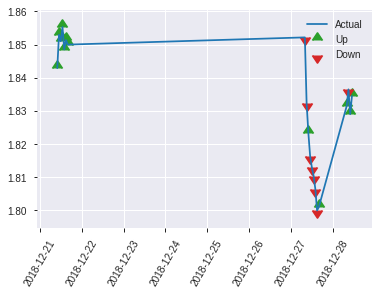


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1674242544517155
RMSE: 0.4091750902140983
LogLoss: 0.5071562275094559
Null degrees of freedom: 219
Residual degrees of freedom: 169
Null deviance: 303.92457192432397
Residual deviance: 223.14874010416054
AIC: 325.14874010416054
AUC: 0.8359629351364889
pr_auc: 0.801125853194008
Gini: 0.6719258702729778
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42956541557839323: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   33   0.2727   (33.0/121.0)
1      16   83   0.1616   (16.0/99.0)
Total  104  116  0.2227   (49.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.429565     0.772093  115
max f2                       0.268536     0.843806  160
max f0point5                 0.507257     0.749465  91
max accuracy                 0.449912     0.777273  107
max precision                0.935918     1         0
max recall                   0.0655033    1         212
max specificity              0.935918     1         0
max absolute_mcc             0.429565     0.56366   115
max min_per_class_accuracy   0.469954     0.760331  104
max mean_per_class_accuracy  0.429565     0.782828  115

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 44.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.896447           2.22222   2.22222            1                0.913552   1                           0.913552            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.876112           2.22222   2.22222            1                0.887077   1                           0.902962            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.860215           2.22222   2.22222            1                0.864431   1                           0.891953            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.854395           2.22222   2.22222            1                0.856087   1                           0.883983            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.836863           2.22222   2.22222            1                0.85362    1                           0.878462            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.754988           2.22222   2.22222            1                0.795528   1                           0.836995            0.111111        0.222222                   122.222   122.222
    7        0.15                        0.7065             1.41414   1.95286            0.636364         0.732718   0.878788                    0.802236            0.0707071       0.292929                   41.4141   95.2862
    8        0.2                         0.676824           1.81818   1.91919            0.818182         0.690332   0.863636                    0.77426             0.0909091       0.383838                   81.8182   91.9192
    9        0.3                         0.592058           1.31313   1.71717            0.590909         0.632822   0.772727                    0.727114            0.131313        0.515152                   31.3131   71.7172
    10       0.4                         0.516186           1.51515   1.66667            0.681818         0.549684   0.75                        0.682756            0.151515        0.666667                   51.5152   66.6667
    11       0.5                         0.442211           1.31313   1.59596            0.590909         0.484116   0.718182                    0.643028            0.131313        0.79798                    31.3131   59.596
    12       0.6                         0.381439           0.808081  1.46465            0.363636         0.409431   0.659091                    0.604096            0.0808081       0.878788                   -19.1919  46.4646
    13       0.7                         0.285432           0.505051  1.32756            0.227273         0.331579   0.597403                    0.565165            0.0505051       0.929293                   -49.4949  32.7561
    14       0.8                         0.204582           0.30303   1.19949            0.136364         0.246998   0.539773                    0.525394            0.030303        0.959596                   -69.697   19.9495
    15       0.9                         0.121725           0.20202   1.08866            0.0909091        0.161281   0.489899                    0.484937            0.020202        0.979798                   -79.798   8.86644
    16       1                           0.0131767          0.20202   1                  0.0909091        0.0714234  0.45                        

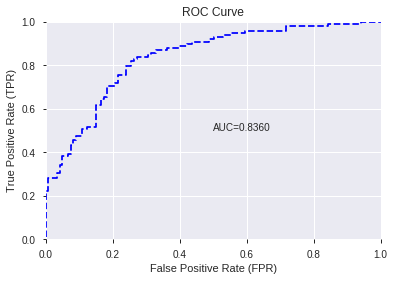

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


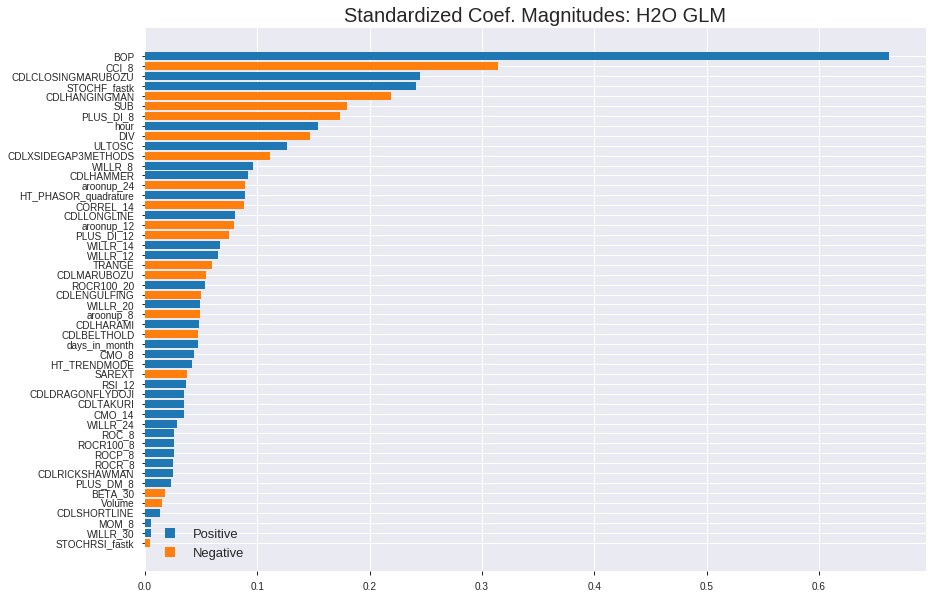

'log_likelihood'
--2019-08-28 13:25:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_132511_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_132511_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CDLHANGINGMAN',
 'SUB',
 'PLUS_DI_8',
 'hour',
 'DIV',
 'ULTOSC',
 'CDLXSIDEGAP3METHODS',
 'WILLR_8',
 'CDLHAMMER',
 'aroonup_24',
 'HT_PHASOR_quadrature',
 'CORREL_14',
 'CDLLONGLINE',
 'aroonup_12',
 'PLUS_DI_12',
 'WILLR_14',
 'WILLR_12',
 'TRANGE',
 'CDLMARUBOZU',
 'ROCR100_20',
 'CDLENGULFING',
 'WILLR_20',
 'aroonup_8',
 'CDLHARAMI',
 'CDLBELTHOLD',
 'days_in_month',
 'CMO_8',
 'HT_TRENDMODE',
 'SAREXT',
 'RSI_12',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CMO_14',
 'WILLR_24',
 'ROC_8',
 'ROCR100_8',
 'ROCP_8',
 'ROCR_8',
 'CDLRICKSHAWMAN',
 'PLUS_DM_8',
 'BETA_30',
 'Volume',
 'CDLSHORTLINE',
 'MOM_8',
 'WILLR_30',
 'STOCHRSI_fastk']

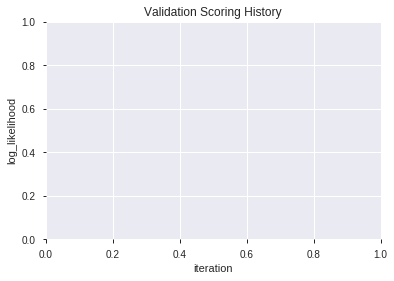

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_132522_model_6  0.841473  0.498428              0.247475  0.406548  0.165281
1  XGBoost_grid_1_AutoML_20190828_132522_model_4  0.838968  0.511947              0.247934  0.411551  0.169374
2  XGBoost_grid_1_AutoML_20190828_132522_model_1  0.838133  0.494603              0.243343  0.406100  0.164917
3  XGBoost_grid_1_AutoML_20190828_132522_model_2  0.836798  0.506078              0.223140  0.409528  0.167713
4               XGBoost_3_AutoML_20190828_132522  0.835462  0.498801              0.237833  0.407325  0.165914
5               XGBoost_2_AutoML_20190828_132522  0.835045  0.503649              0.258035  0.409550  0.167731
6  XGBoost_grid_1_AutoML_20190828_132522_model_3  0.827615  0.505221              0.243343  0.412474  0.170135
7  XGBoost_grid_1_AutoML_20190828_132522_model_7  0.826112  0.501608              0.242883  0.411074  0.168981
8               XGBoost_1_AutoML_20190828_132522  0.824192  0.510667              0.264463  0.414625  0.171914
9  XGBoost_grid_1_AutoML_20190828_132522_model_5  0.810084  0.523873              0.275023  0.423649  0.179479

variable  relative_importance  scaled_importance  percentage
0                    BOP          2029.442261           1.000000    0.206185
1           STOCHF_fastk           883.604431           0.435393    0.089771
2                    DIV           674.131287           0.332176    0.068490
3                  CCI_8           483.241577           0.238115    0.049096
4                 TRANGE           383.037231           0.188740    0.038915
5                 ULTOSC           339.746124           0.167409    0.034517
6                   hour           323.584198           0.159445    0.032875
7   HT_PHASOR_quadrature           304.184875           0.149886    0.030904
8                BETA_30           299.308594           0.147483    0.030409
9                 SAREXT           285.736755           0.140796    0.029030
10               WILLR_8           285.067352           0.140466    0.028962
11             CORREL_14           263.756348           0.129965    0.026797
12             PLUS_DM_8           248.042389           0.122222    0.025200
13             aroonup_8           233.432755           0.115023    0.023716
14            ROCR100_20           221.821899           0.109302    0.022536
15             PLUS_DI_8           209.645081           0.103302    0.021299
16                Volume           208.849609           0.102910    0.021218
17    CDLCLOSINGMARUBOZU           181.757584           0.089560    0.018466
18                 CMO_8           172.872025           0.085182    0.017563
19              WILLR_12           164.771500           0.081191    0.016740
20            aroonup_12           145.445496           0.071668    0.014777
21              WILLR_30           142.956345           0.070441    0.014524
22                 MOM_8           130.237320           0.064174    0.013232
23           CDLLONGLINE           121.304047           0.059772    0.012324
24            PLUS_DI_12           121.249649           0.059745    0.012319
25              WILLR_14           120.567734           0.059409    0.012249
26        STOCHRSI_fastk           116.783539           0.057545    0.011865
27            aroonup_24           115.498062           0.056911    0.011734
28                   SUB           112.765915           0.055565    0.011457
29              WILLR_20           110.723831           0.054559    0.011249
30                 ROC_8            82.111435           0.040460    0.008342
31                CMO_14            56.459263           0.027820    0.005736
32         days_in_month            46.215630           0.022773    0.004695
33              WILLR_24            44.933929           0.022141    0.004565
34          HT_TRENDMODE            39.371876           0.019400    0.004000
35                RSI_12            34.497852           0.016999    0.003505
36         CDLHANGINGMAN            22.657713           0.011165    0.002302
37           CDLBELTHOLD            22.595316           0.011134    0.002296
38             CDLHAMMER            15.557909           0.007666    0.001581
39          CDLSHORTLINE             9.342379           0.004603    0.000949
40                ROCP_8             9.037837           0.004453    0.000918
41             CDLTAKURI             7.368693           0.003631    0.000749
42                ROCR_8             6.447770           0.003177    0.000655
43        CDLRICKSHAWMAN             5.084009           0.002505    0.000517
44          CDLENGULFING             4.060814           0.002001    0.000413
45           CDLMARUBOZU             3.516943           0.001733    0.000357

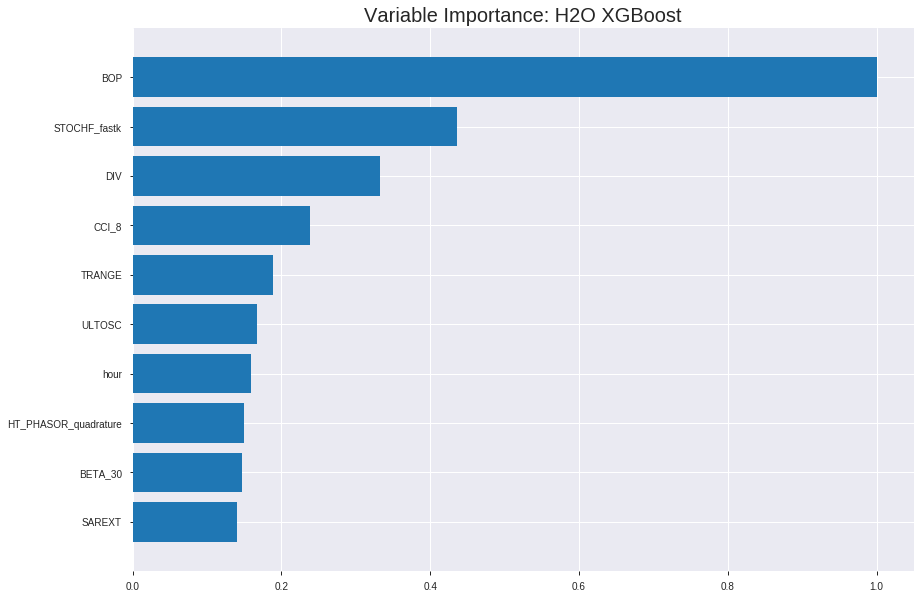

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_132522_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11835794366725125
RMSE: 0.3440318933867197
LogLoss: 0.3907413413089886
Mean Per-Class Error: 0.14865255167398916
AUC: 0.9367637114887342
pr_auc: 0.9340055872333171
Gini: 0.8735274229774683
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4014091193675995: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      597  192  0.2433   (192.0/789.0)
1      44   702  0.059    (44.0/746.0)
Total  641  894  0.1537   (236.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401409     0.856098  238
max f2                       0.357944     0.91128   256
max f0point5                 0.618177     0.871898  147
max accuracy                 0.437146     0.849511  223
max precision                0.950674     1         0
max recall                   0.208635     1         322
max specificity              0.950674     1         0
max absolute_mcc             0.401409     0.707069  238
max min_per_class_accuracy   0.502513     0.837769  198
max mean_per_class_accuracy  0.437146     0.851347  223

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104235                   0.927469           2.05764   2.05764            1                0.93556    1                           0.93556             0.0214477       0.0214477                  105.764    105.764
    2        0.0201954                   0.914167           2.05764   2.05764            1                0.918849   1                           0.927474            0.0201072       0.041555                   105.764    105.764
    3        0.0306189                   0.90508            2.05764   2.05764            1                0.909234   1                           0.921265            0.0214477       0.0630027                  105.764    105.764
    4        0.0403909                   0.896235           2.05764   2.05764            1                0.901363   1                           0.91645             0.0201072       0.0831099                  105.764    105.764
    5        0.0501629                   0.887623           2.05764   2.05764            1                0.891642   1                           0.911617            0.0201072       0.103217                   105.764    105.764
    6        0.100326                    0.848885           2.05764   2.05764            1                0.869317   1                           0.890467            0.103217        0.206434                   105.764    105.764
    7        0.150489                    0.801623           2.05764   2.05764            1                0.826486   1                           0.86914             0.103217        0.309651                   105.764    105.764
    8        0.2                         0.768791           2.03057   2.05094            0.986842         0.785441   0.996743                    0.84842             0.100536        0.410188                   103.057    105.094
    9        0.300326                    0.672812           1.76369   1.95498            0.857143         0.720281   0.950108                    0.805614            0.176944        0.587131                   76.3692    95.4982
    10       0.4                         0.589877           1.54659   1.85322            0.751634         0.630134   0.900651                    0.761887            0.154155        0.741287                   54.6593    85.3217
    11       0.500326                    0.494371           1.08227   1.69863            0.525974         0.541916   0.825521                    0.717778            0.108579        0.849866                   8.22656    69.8625
    12       0.6                         0.374842           0.995199  1.58177            0.48366          0.438233   0.76873                     0.671339            0.0991957       0.949062                   -0.480121  58.1769
    13       0.699674                    0.283675           0.376562  1.41008            0.183007         0.331961   0.685289                    0.622992            0.0375335       0.986595                   -62.3438   41.0078
    14       0.8                         0.191074           0.133613  1.25               0.0649351        0.235983   0.607492                    0.574458            0.0134048       1                          -86.6387   25
    15       0.899674                    0.124202           0         1.11151            0                0.156198   0.540188                    0.52812             0               1                          -100       11.1513
    16       1                           0.0520066          0         1                  0                0.0933347  0.485993       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19506898238173792
RMSE: 0.44166614357650047
LogLoss: 0.5697703463631729
Mean Per-Class Error: 0.29042828518951413
AUC: 0.7719569210218735
pr_auc: 0.7586192160602157
Gini: 0.543913842043747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30087944865226746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  108  0.5094   (108.0/212.0)
1      21   205  0.0929   (21.0/226.0)
Total  125  313  0.2945   (129.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300879     0.760668  284
max f2                       0.173848     0.864101  334
max f0point5                 0.390491     0.705615  248
max accuracy                 0.355626     0.714612  264
max precision                0.952326     1         0
max recall                   0.113629     1         369
max specificity              0.952326     1         0
max absolute_mcc             0.355626     0.443588  264
max min_per_class_accuracy   0.481015     0.683962  200
max mean_per_class_accuracy  0.355626     0.709572  264

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.933834           1.93805   1.93805            1                0.944448   1                           0.944448            0.0221239       0.0221239                  93.8053    93.8053
    2        0.0205479                   0.917667           1.45354   1.72271            0.75             0.923942   0.888889                    0.935334            0.0132743       0.0353982                  45.354     72.2714
    3        0.0319635                   0.910268           1.55044   1.66119            0.8              0.914306   0.857143                    0.927824            0.0176991       0.0530973                  55.0442    66.1188
    4        0.0410959                   0.89808            1.93805   1.72271            1                0.901821   0.888889                    0.922045            0.0176991       0.0707965                  93.8053    72.2714
    5        0.0502283                   0.891031           1.45354   1.67377            0.75             0.895422   0.863636                    0.917205            0.0132743       0.0840708                  45.354     67.3773
    6        0.100457                    0.831136           1.58568   1.62973            0.818182         0.861036   0.840909                    0.88912             0.079646        0.163717                   58.568     62.9726
    7        0.150685                    0.796542           1.76187   1.67377            0.909091         0.815877   0.863636                    0.864706            0.0884956       0.252212                   76.1866    67.3773
    8        0.200913                    0.74295            1.58568   1.65175            0.818182         0.770478   0.852273                    0.841149            0.079646        0.331858                   58.568     65.175
    9        0.30137                     0.660004           1.27735   1.52695            0.659091         0.699076   0.787879                    0.793791            0.128319        0.460177                   27.7353    52.6951
    10       0.399543                    0.580542           1.0817    1.41755            0.55814          0.622481   0.731429                    0.751698            0.106195        0.566372                   8.17041    41.7547
    11       0.5                         0.488001           1.10117   1.35398            0.568182         0.532397   0.69863                     0.707637            0.110619        0.676991                   10.1167    35.3982
    12       0.600457                    0.412635           1.14521   1.31906            0.590909         0.450682   0.680608                    0.664649            0.115044        0.792035                   14.5213    31.9055
    13       0.69863                     0.318952           0.991562  1.27303            0.511628         0.364634   0.656863                    0.62249             0.0973451       0.889381                   -0.843795  27.3035
    14       0.799087                    0.215357           0.52856   1.17944            0.272727         0.266122   0.608571                    0.577689            0.0530973       0.942478                   -47.144    17.9444
    15       0.899543                    0.126842           0.352373  1.08708            0.181818         0.166399   0.560914                    0.531758            0.0353982       0.977876                   -64.7627   8.70805
    16       1                           0.0616798          0.220233  1                  0.113636         0.0967943  0.515982   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:25:36  8.650 sec   0                  0.5              0.693147            0.5             0                  1                0.514007                         0.5                0.693147              0.5               0                    1                  0.484018
    2019-08-28 13:25:36  8.764 sec   5                  0.465079         0.625218            0.871708        0.860504           2.05764          0.231922                         0.476442           0.646763              0.769901          0.754264             1.93805            0.33105
    2019-08-28 13:25:36  8.825 sec   10                 0.439113         0.576116            0.887331        0.882839           2.05764          0.229316                         0.462402           0.619051              0.771143          0.756563             1.93805            0.305936
    2019-08-28 13:25:36  8.893 sec   15                 0.419426         0.538684            0.893522        0.89065            2.05764          0.199349                         0.452624           0.598883              0.772176          0.755545             1.55044            0.292237
    2019-08-28 13:25:36  8.957 sec   20                 0.404428         0.509727            0.90001         0.897289           2.05764          0.188274                         0.446497           0.585428              0.773251          0.756385             1.93805            0.30137
    2019-08-28 13:25:36  9.029 sec   25                 0.391945         0.485209            0.9058          0.900399           2.05764          0.185016                         0.443254           0.577319              0.77252           0.761813             1.93805            0.30137
    2019-08-28 13:25:36  9.111 sec   30                 0.38327          0.467664            0.909348        0.903084           2.05764          0.179805                         0.44062            0.570405              0.774117          0.765211             1.93805            0.294521
    2019-08-28 13:25:36  9.179 sec   35                 0.375343         0.451544            0.913145        0.9079             2.05764          0.178502                         0.4405             0.569035              0.77228           0.760874             1.93805            0.292237
    2019-08-28 13:25:37  9.252 sec   40                 0.368057         0.437474            0.919563        0.915506           2.05764          0.177199                         0.439486           0.566252              0.774148          0.761104             1.93805            0.299087
    2019-08-28 13:25:37  9.318 sec   45                 0.362089         0.425056            0.922537        0.918156           2.05764          0.171987                         0.439437           0.5657                0.774691          0.76082              1.93805            0.296804
    2019-08-28 13:25:37  9.386 sec   50                 0.355918         0.413182            0.927845        0.924148           2.05764          0.172638                         0.441063           0.569204              0.772416          0.756832             1.93805            0.292237
    2019-08-28 13:25:37  9.458 sec   55                 0.349282         0.400749            0.933164        0.929535           2.05764          0.162215                         0.442172           0.571171              0.77012           0.75

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             2029.4422607421875     1.0                    0.20618493409288235
STOCHF_fastk    883.6044311523438      0.4353927422548108     0.08977142386632748
DIV             674.1312866210938      0.33217564237307107    0.06848961292995252
CCI_8           483.2415771484375      0.23811545984644628    0.0490958203949359
TRANGE          383.0372314453125      0.18874014740642678    0.03891537485367501
---             ---                    ---                    ---
CDLTAKURI       7.3686933517456055     0.0036308957856484177  0.0007486360082620433
ROCR_8          6.447770118713379      0.0031771143448818123  0.0006550731118050076
CDLRICKSHAWMAN  5.084009170532227      0.0025051262944888876  0.0005165192999235378
CDLENGULFING    4.060813903808594      0.002000950695844637   0.00041256588734583363
CDLMARUBOZU     3.5169425010681152     0.0017329601186987867  0.0003573102678595029


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7630522088353413)

('auc', 0.8414725770097671)

('logloss', 0.4984279514250983)

('mean_per_class_error', 0.23783287419651056)

('rmse', 0.40654751135369493)

('mse', 0.1652808789878827)

xgboost prediction progress: |████████████████████████████████████████████| 100%


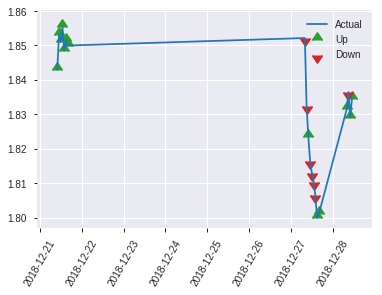


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1652808789878827
RMSE: 0.40654751135369493
LogLoss: 0.4984279514250983
Mean Per-Class Error: 0.23783287419651056
AUC: 0.8414725770097671
pr_auc: 0.8050850096919094
Gini: 0.6829451540195342
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2871610224246979: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      66   55   0.4545   (55.0/121.0)
1      4    95   0.0404   (4.0/99.0)
Total  70   150  0.2682   (59.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.287161     0.763052  149
max f2                       0.287161     0.869963  149
max f0point5                 0.460392     0.729847  89
max accuracy                 0.435572     0.754545  102
max precision                0.911642     1         0
max recall                   0.0994236    1         213
max specificity              0.911642     1         0
max absolute_mcc             0.287161     0.539449  149
max min_per_class_accuracy   0.435572     0.747475  102
max mean_per_class_accuracy  0.40456      0.762167  120

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 43.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.908976           2.22222   2.22222            1                0.910953  1                           0.910953            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.901026           2.22222   2.22222            1                0.902861  1                           0.907716            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.891001           2.22222   2.22222            1                0.896221  1                           0.904432            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.882733           2.22222   2.22222            1                0.886929  1                           0.900543            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.870682           2.22222   2.22222            1                0.876641  1                           0.896197            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.782029           1.81818   2.0202             0.818182         0.824778  0.909091                    0.860487            0.0909091       0.20202                    81.8182   102.02
    7        0.15                        0.709928           2.22222   2.08754            1                0.745785  0.939394                    0.822253            0.111111        0.313131                   122.222   108.754
    8        0.2                         0.647316           1.41414   1.91919            0.636364         0.684412  0.863636                    0.787793            0.0707071       0.383838                   41.4141   91.9192
    9        0.3                         0.547065           1.41414   1.75084            0.636364         0.59507   0.787879                    0.723552            0.141414        0.525253                   41.4141   75.0842
    10       0.4                         0.46087            1.31313   1.64141            0.590909         0.503629  0.738636                    0.668571            0.131313        0.656566                   31.3131   64.1414
    11       0.5                         0.430324           1.11111   1.53535            0.5              0.44442   0.690909                    0.623741            0.111111        0.767677                   11.1111   53.5354
    12       0.6                         0.354823           1.11111   1.46465            0.5              0.399645  0.659091                    0.586392            0.111111        0.878788                   11.1111   46.4646
    13       0.7                         0.273022           0.808081  1.37085            0.363636         0.315631  0.616883                    0.547712            0.0808081       0.959596                   -19.1919  37.0851
    14       0.8                         0.187841           0.30303   1.23737            0.136364         0.22207   0.556818                    0.507007            0.030303        0.989899                   -69.697   23.7374
    15       0.9                         0.125909           0         1.09989            0                0.153686  0.494949                    0.467749            0               0.989899                   -100      9.98878
    16       1                           0.0516844          0.10101   1                  0.0454545        0.103617  0.45                        0.431335          

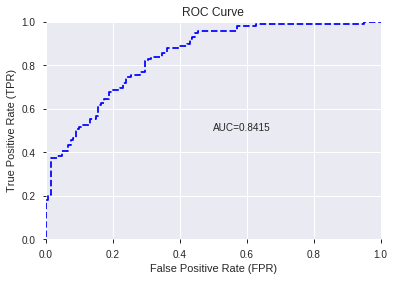

This function is available for GLM models only


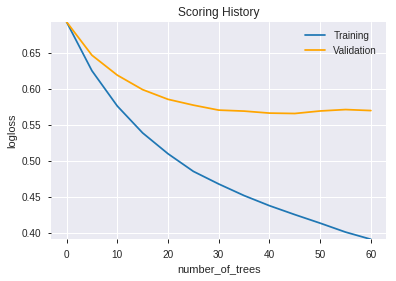

--2019-08-28 13:25:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_132522_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_132522_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CCI_8',
 'TRANGE',
 'ULTOSC',
 'hour',
 'HT_PHASOR_quadrature',
 'BETA_30',
 'SAREXT',
 'WILLR_8',
 'CORREL_14',
 'PLUS_DM_8',
 'aroonup_8',
 'ROCR100_20',
 'PLUS_DI_8',
 'Volume',
 'CDLCLOSINGMARUBOZU',
 'CMO_8',
 'WILLR_12',
 'aroonup_12',
 'WILLR_30',
 'MOM_8',
 'CDLLONGLINE',
 'PLUS_DI_12',
 'WILLR_14',
 'STOCHRSI_fastk',
 'aroonup_24',
 'SUB',
 'WILLR_20',
 'ROC_8',
 'CMO_14',
 'days_in_month',
 'WILLR_24',
 'HT_TRENDMODE',
 'RSI_12',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLSHORTLINE',
 'ROCP_8',
 'CDLTAKURI',
 'ROCR_8',
 'CDLRICKSHAWMAN',
 'CDLENGULFING',
 'CDLMARUBOZU']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 891 926] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


58

['Volume',
 'hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'MFI_8',
 'MINUS_DI_8',
 'MINUS_DM_8',
 'MOM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'MOM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'CCI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CCI_24',
 'CMO_24',
 'RSI_24',
 'WILLR_24',
 'CMO_30',
 'RSI_30',
 'WILLR_30',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLHANGINGMAN',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_132551_model_6  0.836213  0.496398              0.261708  0.407629  0.166162
1  DeepLearning_grid_1_AutoML_20190828_132551_model_5  0.833626  0.510960              0.224977  0.415286  0.172463
2  DeepLearning_grid_1_AutoML_20190828_132551_model_9  0.833542  0.501237              0.238292  0.408265  0.166680
3  DeepLearning_grid_1_AutoML_20190828_132551_model_8  0.826112  0.504171              0.241047  0.415858  0.172938
4  DeepLearning_grid_1_AutoML_20190828_132551_model_3  0.803990  0.531845              0.307163  0.427274  0.182563
5  DeepLearning_grid_1_AutoML_20190828_132551_model_4  0.792387  0.576302              0.297521  0.444954  0.197984
6  DeepLearning_grid_1_AutoML_20190828_132551_model_2  0.779614  0.567930              0.302112  0.439883  0.193497
7  DeepLearning_grid_1_AutoML_20190828_132551_model_7  0.778946  0.562890              0.301653  0.442681  0.195967
8               DeepLearning_1_AutoML_20190828_132551  0.762418  0.591749              0.304867  0.450417  0.202876
9  DeepLearning_grid_1_AutoML_20190828_132551_model_1  0.752567  0.736613              0.358586  0.477033  0.227560

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.028638
1   CDLCLOSINGMARUBOZU             0.754218           0.754218    0.021599
2                  SUB             0.740435           0.740435    0.021204
3          CDLLONGLINE             0.706863           0.706863    0.020243
4         STOCHF_fastk             0.691556           0.691556    0.019804
5               TRANGE             0.688544           0.688544    0.019718
6               ULTOSC             0.685705           0.685705    0.019637
7                  DIV             0.684174           0.684174    0.019593
8        CDLHANGINGMAN             0.662982           0.662982    0.018986
9         CDLSHORTLINE             0.640509           0.640509    0.018343
10              Volume             0.619046           0.619046    0.017728
11              RSI_14             0.613209           0.613209    0.017561
12                hour             0.607692           0.607692    0.017403
13            WILLR_12             0.602795           0.602795    0.017263
14         CDLBELTHOLD             0.600412           0.600412    0.017194
15            WILLR_30             0.600077           0.600077    0.017185
16           ROCR100_8             0.598277           0.598277    0.017133
17      STOCHRSI_fastd             0.596174           0.596174    0.017073
18             WILLR_8             0.594813           0.594813    0.017034
19              CCI_12             0.591857           0.591857    0.016949
20               MFI_8             0.591774           0.591774    0.016947
21               ADOSC             0.591309           0.591309    0.016934
22         STOCH_slowk             0.587323           0.587323    0.016819
23              ROCR_8             0.587240           0.587240    0.016817
24            WILLR_20             0.586670           0.586670    0.016801
25            WILLR_14             0.585420           0.585420    0.016765
26              CCI_20             0.584354           0.584354    0.016734
27      STOCHRSI_fastk             0.581799           0.581799    0.016661
28          MINUS_DM_8             0.580061           0.580061    0.016612
29        CDLENGULFING             0.578865           0.578865    0.016577
30              CCI_24             0.578480           0.578480    0.016566
31          ROCR100_14             0.578269           0.578269    0.016560
32              RSI_12             0.578129           0.578129    0.016556
33               MOM_8             0.577973           0.577973    0.016552
34              MOM_14             0.576465           0.576465    0.016509
35               ROC_8             0.575911           0.575911    0.016493
36        STOCHF_fastd             0.574523           0.574523    0.016453
37         CDLMARUBOZU             0.573167           0.573167    0.016414
38              CMO_30             0.572446           0.572446    0.016393
39              ROCP_8             0.572279           0.572279    0.016389
40              CMO_14             0.570868           0.570868    0.016348
41             ROCR_14             0.570689           0.570689    0.016343
42              ROC_14             0.570282           0.570282    0.016331
43          MINUS_DI_8             0.569746           0.569746    0.016316
44              RSI_24             0.569577           0.569577    0.016311
45   LINEARREG_ANGLE_8             0.569147           0.569147    0.016299
46               CMO_8             0.568425           0.568425    0.016278
47   LINEARREG_SLOPE_8             0.560614           0.560614    0.016055
48             ROCP_14             0.558488           0.558488    0.015994
49               CCI_8             0.556114           0.556114    0.015926
50              CCI_14             0.555732           0.555732    0.015915
51            WILLR_24             0.552094           0.552094    0.015811
52              CMO_20             0.55

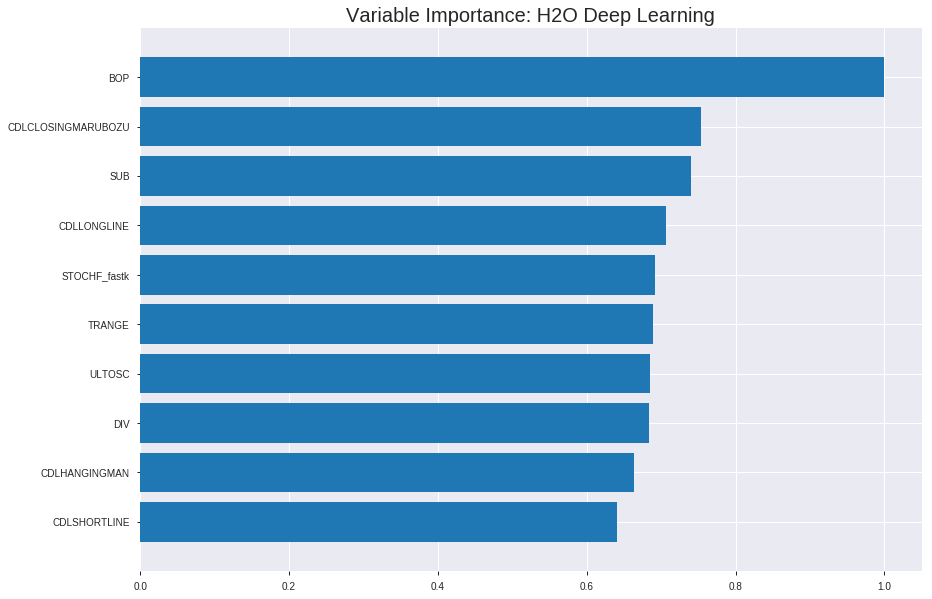

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_132551_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1805310217790238
RMSE: 0.4248894230020604
LogLoss: 0.5362504679954117
Mean Per-Class Error: 0.2682018505115581
AUC: 0.8075575014356245
pr_auc: 0.7921404286983857
Gini: 0.6151150028712491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4668241726772287: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      496  293  0.3714   (293.0/789.0)
1      126  620  0.1689   (126.0/746.0)
Total  622  913  0.273    (419.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466824     0.747438  222
max f2                       0.267034     0.842018  306
max f0point5                 0.59723      0.728963  153
max accuracy                 0.520269     0.730945  195
max precision                0.950375     0.955224  17
max recall                   0.0734346    1         377
max specificity              0.988679     0.998733  0
max absolute_mcc             0.466824     0.46805   222
max min_per_class_accuracy   0.524272     0.728771  192
max mean_per_class_accuracy  0.493084     0.731798  208

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 51.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104235                   0.977265           1.80044   1.80044            0.875            0.980057   0.875                       0.980057            0.0187668       0.0187668                  80.0436    80.0436
    2        0.0201954                   0.970601           2.05764   1.92489            1                0.973627   0.935484                    0.976946            0.0201072       0.038874                   105.764    92.489
    3        0.0306189                   0.963587           1.92904   1.9263             0.9375           0.967833   0.93617                     0.973844            0.0201072       0.0589812                  92.9038    92.6302
    4        0.0403909                   0.954526           2.05764   1.95808            1                0.958924   0.951613                    0.970234            0.0201072       0.0790885                  105.764    95.8077
    5        0.0501629                   0.939237           1.78329   1.92403            0.866667         0.946794   0.935065                    0.965668            0.0174263       0.0965147                  78.3289    92.4028
    6        0.100326                    0.877439           1.97747   1.95075            0.961039         0.907092   0.948052                    0.93638             0.0991957       0.19571                    97.7473    95.075
    7        0.150489                    0.821965           1.71025   1.87058            0.831169         0.851702   0.909091                    0.908154            0.0857909       0.281501                   71.0247    87.0583
    8        0.2                         0.770351           1.54323   1.78954            0.75             0.795769   0.869707                    0.880332            0.0764075       0.357909                   54.3231    78.9544
    9        0.300326                    0.658254           1.45638   1.67825            0.707792         0.704871   0.815618                    0.821718            0.146113        0.504021                   45.6382    67.8249
    10       0.4                         0.576446           1.17003   1.55161            0.568627         0.617308   0.754072                    0.770782            0.116622        0.620643                   17.0031    55.1609
    11       0.500326                    0.520879           1.13571   1.46821            0.551948         0.546923   0.713542                    0.725894            0.113941        0.734584                   13.5711    46.8212
    12       0.6                         0.461555           0.995199  1.38963            0.48366          0.491697   0.675353                    0.686988            0.0991957       0.83378                    -0.480121  38.9634
    13       0.699674                    0.378795           0.645534  1.28363            0.313725         0.419136   0.623836                    0.64883             0.0643432       0.898123                   -35.4466   28.3631
    14       0.8                         0.277152           0.494368  1.18465            0.24026          0.331803   0.575733                    0.609073            0.0495979       0.947721                   -50.5632   18.4651
    15       0.899674                    0.141172           0.322767  1.08916            0.156863         0.201567   0.529327                    0.563926            0.0321716       0.979893                   -67.7233   8.91639
    16       1                           0.00541077         0.20042   1                  0.0974026        0.0798816  0.485993    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1858927001406638
RMSE: 0.43115275731539027
LogLoss: 0.5503429871508815
Mean Per-Class Error: 0.2750876607113041
AUC: 0.7886437635665386
pr_auc: 0.7753050395904602
Gini: 0.5772875271330773
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37376164734619494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  96   0.4528   (96.0/212.0)
1      22   204  0.0973   (22.0/226.0)
Total  138  300  0.2694   (118.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373762     0.775665  273
max f2                       0.155015     0.866511  344
max f0point5                 0.590301     0.726164  156
max accuracy                 0.373762     0.730594  273
max precision                0.984219     1         0
max recall                   0.0538279    1         384
max specificity              0.984219     1         0
max absolute_mcc             0.373762     0.483911  273
max min_per_class_accuracy   0.517804     0.70354   203
max mean_per_class_accuracy  0.373762     0.724912  273

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0114155                   0.975805           1.55044   1.55044            0.8              0.97964   0.8                         0.97964             0.0176991       0.0176991                  55.0442    55.0442
    2        0.0205479                   0.970351           1.93805   1.72271            1                0.972574  0.888889                    0.9765              0.0176991       0.0353982                  93.8053    72.2714
    3        0.0319635                   0.960085           1.55044   1.66119            0.8              0.966377  0.857143                    0.972884            0.0176991       0.0530973                  55.0442    66.1188
    4        0.0410959                   0.953612           1.93805   1.72271            1                0.95689   0.888889                    0.96933             0.0176991       0.0707965                  93.8053    72.2714
    5        0.0502283                   0.920981           1.93805   1.76187            1                0.940074  0.909091                    0.964011            0.0176991       0.0884956                  93.8053    76.1866
    6        0.100457                    0.876044           1.84996   1.80591            0.954545         0.89764   0.931818                    0.930825            0.0929204       0.181416                   84.996     80.5913
    7        0.150685                    0.830076           1.58568   1.7325             0.818182         0.853226  0.893939                    0.904959            0.079646        0.261062                   58.568     73.2502
    8        0.200913                    0.750266           1.23331   1.6077             0.636364         0.78903   0.829545                    0.875977            0.0619469       0.323009                   23.3307    60.7703
    9        0.30137                     0.646137           1.40949   1.54163            0.727273         0.696059  0.795455                    0.816004            0.141593        0.464602                   40.9493    54.1633
    10       0.399543                    0.57144            1.21692   1.46185            0.627907         0.612628  0.754286                    0.766032            0.119469        0.584071                   21.6917    46.1846
    11       0.5                         0.517928           1.14521   1.39823            0.590909         0.544739  0.721461                    0.721571            0.115044        0.699115                   14.5213    39.823
    12       0.600457                    0.460086           1.05712   1.34116            0.545455         0.493123  0.692015                    0.683352            0.106195        0.80531                    5.71199    34.1162
    13       0.69863                     0.359001           0.991562  1.29204            0.511628         0.413926  0.666667                    0.645491            0.0973451       0.902655                   -0.843795  29.2035
    14       0.799087                    0.225025           0.440467  1.18498            0.227273         0.285205  0.611429                    0.600198            0.0442478       0.946903                   -55.9533   18.4981
    15       0.899543                    0.109551           0.39642   1.09692            0.204545         0.169188  0.56599                     0.552065            0.039823        0.986726                   -60.358    9.69184
    16       1                           0.00942474         0.13214   1                  0.0681818        0.060379  0.515982                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:29:49  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:29:52  2 min 11.848 sec  838 obs/sec       1.56352   1             2400       0.441877         0.611995            0.218365       0.801451        0.767647           1.80044          0.284039                         0.450495           0.638716              0.187387         0.783457          0.772511             1.55044            0.280822
    2019-08-28 13:29:58  2 min 18.065 sec  1421 obs/sec      7.85798   5             12062      0.424889         0.53625             0.277309       0.807558        0.79214            1.80044          0.272964                         0.431153           0.550343              0.255669         0.788644          0.775305             1.55044            0.269406
    2019-08-28 13:30:04  2 min 24.304 sec  1873 obs/sec      17.245    11            26471      0.42379          0.533865            0.281045       0.809755        0.794769           1.80044          0.280782                         0.431413           0.552907              0.25477          0.792265          0.77662              1.55044            0.269406
    2019-08-28 13:30:10  2 min 30.335 sec  2093 obs/sec      26.6801   17            40954      0.421534         0.53336             0.288679       0.823123        0.808178           1.92904          0.283388                         0.431189           0.561968              0.255545         0.793089          0.772734             1.55044            0.271689
    2019-08-28 13:30:17  2 min 36.836 sec  2271 obs/sec      37.7042   24            57876      0.415283         0.518163            0.309617       0.824097        0.809547           1.80044          0.267752                         0.430256           0.558738              0.258761         0.796773          0.77683              1.16283            0.267123
    2019-08-28 13:30:23  2 min 43.438 sec  2379 obs/sec      48.7609   31            74848      0.412062         0.514284            0.320287       0.837189        0.820685           1.92904          0.248208                         0.431696           0.57083               0.253793         0.792484          0.765585             1.55044            0.276256
    2019-08-28 13:30:30  2 min 49.859 sec  2461 obs/sec      59.7733   38            91752      0.406417         0.50218             0.338782       0.840244        0.816542           1.92904          0.242997                         0.429408           0.56892               0.261682         0.796857          0.77483              1.55044            0.271689
    2019-08-28 13:30:30  2 min 50.530 sec  2459 obs/sec      59.7733   38            91752      0.424889         0.53625             0.277309       0.807558        0.79214            1.80044          0.272964                         0.431153           0.550343              0.255669         0.788644          0.775305             1.55044            0.269406

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.028637526249376436
CDLCLOSINGMARUBOZU  0.7542179822921753     0.7542179822921753   0.0215989372656439
SUB                 0.7404345273971558     0.7404345273971558   0.021204213214280686
CDLLONGLINE         0.7068629860877991     0.7068629860877991   0.02024280731880196
STOCHF_fastk        0.6915556192398071     0.6915556192398071   0.01980444219888375
---                 ---                    ---                  ---
RSI_8               0.5515565872192383     0.5515565872192383   0.015795216244507422
RSI_30              0.5474991202354431     0.5474991202354431   0.01567902042725301
CMO_12              0.5443119406700134     0.5443119406700134   0.01558774748878654
RSI_20              0.5428033471107483     0.5428033471107483   0.015544545101133444
CMO_24              0.5179063677787781     0.5179063677787781   0.014831557201983965


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7499999999999999)

('auc', 0.8362133734034561)

('logloss', 0.49639762320399594)

('mean_per_class_error', 0.24977043158861334)

('rmse', 0.4076291624842622)

('mse', 0.166161534107621)

deeplearning prediction progress: |███████████████████████████████████████| 100%


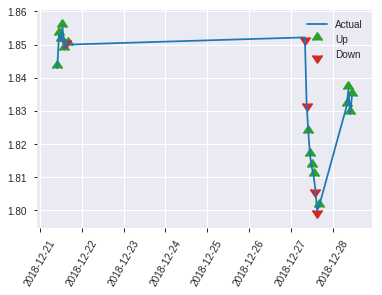


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.166161534107621
RMSE: 0.4076291624842622
LogLoss: 0.49639762320399594
Mean Per-Class Error: 0.24977043158861334
AUC: 0.8362133734034561
pr_auc: 0.8048367332011719
Gini: 0.6724267468069123
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3711106174976857: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      65   56   0.4628   (56.0/121.0)
1      6    93   0.0606   (6.0/99.0)
Total  71   149  0.2818   (62.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371111     0.75      148
max f2                       0.356631     0.857664  151
max f0point5                 0.652834     0.756014  47
max accuracy                 0.52503      0.754545  82
max precision                0.982399     1         0
max recall                   0.14917      1         191
max specificity              0.982399     1         0
max absolute_mcc             0.371111     0.50714   148
max min_per_class_accuracy   0.480721     0.735537  104
max mean_per_class_accuracy  0.458572     0.75023   114

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 47.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.979635           2.22222   2.22222            1                0.980762  1                           0.980762            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.975684           2.22222   2.22222            1                0.978881  1                           0.980009            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.966968           2.22222   2.22222            1                0.969957  1                           0.977137            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.932778           2.22222   2.22222            1                0.95542   1                           0.972311            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.916651           2.22222   2.22222            1                0.928509  1                           0.964347            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.828192           2.0202    2.12121            0.909091         0.87575   0.954545                    0.920048            0.10101         0.212121                   102.02    112.121
    7        0.15                        0.727367           1.81818   2.0202             0.818182         0.795485  0.909091                    0.878527            0.0909091       0.30303                    81.8182   102.02
    8        0.2                         0.677355           2.0202    2.0202             0.909091         0.70627   0.909091                    0.835463            0.10101         0.40404                    102.02    102.02
    9        0.3                         0.570741           1.31313   1.78451            0.590909         0.62272   0.80303                     0.764549            0.131313        0.535354                   31.3131   78.4512
    10       0.4                         0.516346           1.11111   1.61616            0.5              0.539435  0.727273                    0.70827             0.111111        0.646465                   11.1111   61.6162
    11       0.5                         0.466703           1.11111   1.51515            0.5              0.490752  0.681818                    0.664767            0.111111        0.757576                   11.1111   51.5152
    12       0.6                         0.420574           1.11111   1.44781            0.5              0.448514  0.651515                    0.628724            0.111111        0.868687                   11.1111   44.7811
    13       0.7                         0.341939           0.808081  1.35642            0.363636         0.386861  0.61039                     0.594172            0.0808081       0.949495                   -19.1919  35.6421
    14       0.8                         0.225805           0.20202   1.21212            0.0909091        0.293157  0.545455                    0.556546            0.020202        0.969697                   -79.798   21.2121
    15       0.9                         0.143213           0.30303   1.11111            0.136364         0.176007  0.5                         0.514263            0.030303        1                          -69.697   11.1111
    16       1                           0.0162922          0         1                  0                0.075745  0.45                        0.470412           

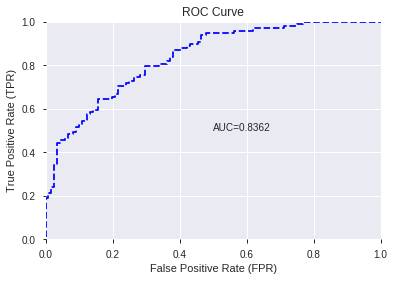

This function is available for GLM models only


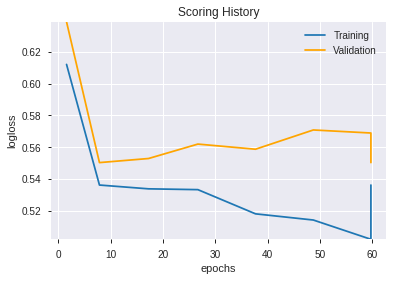

--2019-08-28 13:34:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.115.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.115.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_132551_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_132551_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'SUB',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'TRANGE',
 'ULTOSC',
 'DIV',
 'CDLHANGINGMAN',
 'CDLSHORTLINE',
 'Volume',
 'RSI_14',
 'hour',
 'WILLR_12',
 'CDLBELTHOLD',
 'WILLR_30',
 'ROCR100_8',
 'STOCHRSI_fastd',
 'WILLR_8',
 'CCI_12',
 'MFI_8',
 'ADOSC',
 'STOCH_slowk',
 'ROCR_8',
 'WILLR_20',
 'WILLR_14',
 'CCI_20',
 'STOCHRSI_fastk',
 'MINUS_DM_8',
 'CDLENGULFING',
 'CCI_24',
 'ROCR100_14',
 'RSI_12',
 'MOM_8',
 'MOM_14',
 'ROC_8',
 'STOCHF_fastd',
 'CDLMARUBOZU',
 'CMO_30',
 'ROCP_8',
 'CMO_14',
 'ROCR_14',
 'ROC_14',
 'MINUS_DI_8',
 'RSI_24',
 'LINEARREG_ANGLE_8',
 'CMO_8',
 'LINEARREG_SLOPE_8',
 'ROCP_14',
 'CCI_8',
 'CCI_14',
 'WILLR_24',
 'CMO_20',
 'RSI_8',
 'RSI_30',
 'CMO_12',
 'RSI_20',
 'CMO_24']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190828_133419_model_1  0.844144  0.49385              0.213499  0.402815  0.16226

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.847614           1.000000    0.121747
1         STOCHF_fastk             0.521745           0.615546    0.074941
2                  SUB             0.332949           0.392807    0.047823
3                CCI_8             0.331404           0.390984    0.047601
4               ULTOSC             0.328719           0.387817    0.047216
5        CDLHANGINGMAN             0.292869           0.345522    0.042066
6                  DIV             0.247725           0.292262    0.035582
7   CDLCLOSINGMARUBOZU             0.246636           0.290977    0.035426
8         STOCHF_fastd             0.239611           0.282689    0.034416
9          STOCH_slowk             0.239064           0.282043    0.034338
10          MINUS_DM_8             0.214601           0.253182    0.030824
11      STOCHRSI_fastd             0.203324           0.239877    0.029204
12              CCI_20             0.174965           0.206421    0.025131
13             WILLR_8             0.174257           0.205585    0.025029
14            WILLR_20             0.173013           0.204118    0.024851
15                hour             0.167084           0.197123    0.023999
16      STOCHRSI_fastk             0.165041           0.194713    0.023706
17              CCI_14             0.158618           0.187135    0.022783
18              CCI_12             0.135315           0.159642    0.019436
19            WILLR_14             0.119733           0.141259    0.017198
20               MFI_8             0.105700           0.124703    0.015182
21         CDLMARUBOZU             0.104352           0.123113    0.014989
22          MINUS_DI_8             0.103033           0.121556    0.014799
23         CDLBELTHOLD             0.090767           0.107085    0.013037
24            WILLR_30             0.088135           0.103980    0.012659
25            WILLR_12             0.085652           0.101051    0.012303
26        CDLENGULFING             0.084976           0.100253    0.012205
27              MOM_14             0.076598           0.090369    0.011002
28   LINEARREG_ANGLE_8             0.074794           0.088240    0.010743
29   LINEARREG_SLOPE_8             0.074256           0.087606    0.010666
30            WILLR_24             0.071561           0.084426    0.010279
31               CMO_8             0.068004           0.080229    0.009768
32               RSI_8             0.066613           0.078589    0.009568
33              CCI_24             0.057782           0.068170    0.008299
34              Volume             0.044514           0.052516    0.006394
35              ROCP_8             0.035364           0.041721    0.005079
36              ROCR_8             0.035182           0.041507    0.005053
37           ROCR100_8             0.034947           0.041230    0.005020
38               ROC_8             0.034936           0.041217    0.005018
39        CDLSHORTLINE             0.033499           0.039522    0.004812
40              CMO_12             0.033025           0.038962    0.004743
41              RSI_12             0.030093           0.035504    0.004322
42               ADOSC             0.027698           0.032677    0.003978
43              RSI_24             0.022357           0.026376    0.003211
44              CMO_24             0.018977           0.022388    0.002726
45              CMO_20             0.017367           0.020489    0.002495
46          ROCR100_14             0.017094           0.020167    0.002455
47             ROCR_14             0.016885           0.019921    0.002425
48              ROC_14             0.016714           0.019719    0.002401
49             ROCP_14             0.016542           0.019516    0.002376
50              RSI_14             0.013195           0.015567    0.001895
51              RSI_20             0.011872           0.014006    0.001705
52              CMO_14             0.01

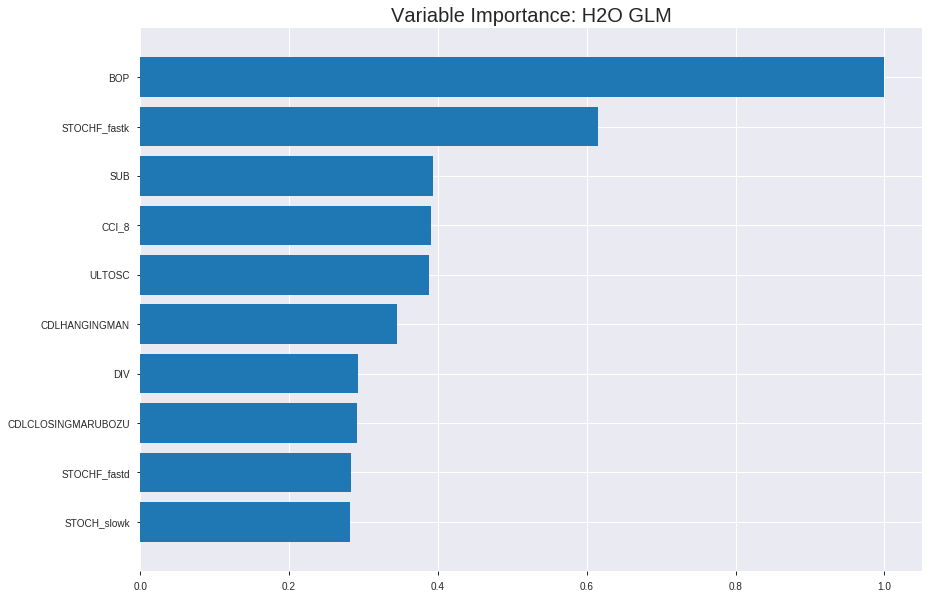

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_133419_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1754049221764266
RMSE: 0.418813708200229
LogLoss: 0.5266852665505729
Null degrees of freedom: 1534
Residual degrees of freedom: 1476
Null deviance: 2126.7571264665794
Residual deviance: 1616.9237683102588
AIC: 1734.9237683102588
AUC: 0.8154619313142846
pr_auc: 0.8027315836836112
Gini: 0.6309238626285691
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4111647891845161: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      498  291  0.3688   (291.0/789.0)
1      124  622  0.1662   (124.0/746.0)
Total  622  913  0.2704   (415.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411165     0.749849  239
max f2                       0.204167     0.841409  324
max f0point5                 0.613033     0.753131  151
max accuracy                 0.569237     0.743974  168
max precision                0.982566     1         0
max recall                   0.0526921    1         386
max specificity              0.982566     1         0
max absolute_mcc             0.569237     0.490369  168
max min_per_class_accuracy   0.494619     0.73891   201
max mean_per_class_accuracy  0.507144     0.743084  195

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.961886           1.92904   1.92904            0.9375           0.970212   0.9375                      0.970212            0.0201072       0.0201072                  92.9038   92.9038
    2        0.0201954                   0.927235           1.92046   1.92489            0.933333         0.944507   0.935484                    0.957774            0.0187668       0.038874                   92.0465   92.489
    3        0.0306189                   0.908463           1.92904   1.9263             0.9375           0.917935   0.93617                     0.944212            0.0201072       0.0589812                  92.9038   92.6302
    4        0.0403909                   0.896837           1.92046   1.92489            0.933333         0.902704   0.935484                    0.93417             0.0187668       0.077748                   92.0465   92.489
    5        0.0501629                   0.885562           2.05764   1.95075            1                0.891165   0.948052                    0.925792            0.0201072       0.0978552                  105.764   95.075
    6        0.100326                    0.834101           1.84386   1.89731            0.896104         0.857935   0.922078                    0.891864            0.0924933       0.190349                   84.386    89.7305
    7        0.150489                    0.785483           1.73697   1.84386            0.844156         0.8085     0.896104                    0.864076            0.0871314       0.27748                    73.6969   84.386
    8        0.2                         0.745881           1.5703    1.77614            0.763158         0.763975   0.863192                    0.839295            0.077748        0.355228                   57.0305   77.6139
    9        0.300326                    0.675458           1.46974   1.67379            0.714286         0.709533   0.813449                    0.795947            0.147453        0.502681                   46.9743   67.3786
    10       0.4                         0.582513           1.39866   1.60523            0.679739         0.631604   0.78013                     0.754995            0.13941         0.642091                   39.8658   60.5228
    11       0.500326                    0.489207           1.04218   1.49233            0.506494         0.53894    0.72526                     0.711672            0.104558        0.746649                   4.21817   49.2325
    12       0.6                         0.406607           0.88761   1.39187            0.431373         0.444055   0.676439                    0.667214            0.0884718       0.835121                   -11.239   39.1868
    13       0.699674                    0.313865           0.739675  1.29896            0.359477         0.355884   0.631285                    0.622863            0.0737265       0.908847                   -26.0325  29.8958
    14       0.8                         0.215346           0.387478  1.18465            0.188312         0.262998   0.575733                    0.577733            0.038874        0.947721                   -61.2522  18.4651
    15       0.899674                    0.121966           0.282421  1.08469            0.137255         0.164293   0.527154                    0.531928            0.0281501       0.975871                   -71.7579  8.4694
    16       1                           0.000843724        0.240503  1                  0.116883         0.0740713  0.485993                    0.48



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.18296269810909746
RMSE: 0.42774139162477304
LogLoss: 0.5474347982442681
Null degrees of freedom: 437
Residual degrees of freedom: 379
Null deviance: 608.3253468479048
Residual deviance: 479.5528832619788
AIC: 597.5528832619789
AUC: 0.7990899983302722
pr_auc: 0.7846622370643864
Gini: 0.5981799966605443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40174475055087844: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      131  81   0.3821   (81.0/212.0)
1      35   191  0.1549   (35.0/226.0)
Total  166  272  0.2648   (116.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401745     0.767068  248
max f2                       0.181683     0.86166   327
max f0point5                 0.617179     0.747191  148
max accuracy                 0.448592     0.737443  230
max precision                0.975572     1         0
max recall                   0.0465496    1         385
max specificity              0.975572     1         0
max absolute_mcc             0.401745     0.477     248
max min_per_class_accuracy   0.5103       0.726415  202
max mean_per_class_accuracy  0.448592     0.735202  230

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.936941           1.55044   1.55044            0.8              0.960038   0.8                         0.960038            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.901209           1.45354   1.50737            0.75             0.918589   0.777778                    0.941616            0.0132743       0.0309735                  45.354    50.7375
    3        0.0319635                   0.888025           1.93805   1.66119            1                0.89288    0.857143                    0.92421             0.0221239       0.0530973                  93.8053   66.1188
    4        0.0410959                   0.871533           1.93805   1.72271            1                0.87961    0.888889                    0.914299            0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.863597           1.93805   1.76187            1                0.866605   0.909091                    0.905627            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.829125           1.67377   1.71782            0.863636         0.849125   0.886364                    0.877376            0.0840708       0.172566                   67.3773   71.782
    7        0.150685                    0.781123           1.67377   1.70314            0.863636         0.805613   0.878788                    0.853455            0.0840708       0.256637                   67.3773   70.3138
    8        0.200913                    0.735875           1.58568   1.67377            0.818182         0.75703    0.863636                    0.829349            0.079646        0.336283                   58.568    67.3773
    9        0.30137                     0.669247           1.36545   1.571              0.704545         0.707023   0.810606                    0.788574            0.137168        0.473451                   36.5447   57.0998
    10       0.399543                    0.5986             1.26199   1.49507            0.651163         0.635569   0.771429                    0.750978            0.123894        0.597345                   26.1988   49.507
    11       0.5                         0.524921           1.18926   1.43363            0.613636         0.561541   0.739726                    0.712918            0.119469        0.716814                   18.926    43.3628
    12       0.600457                    0.419464           1.01307   1.36327            0.522727         0.471006   0.703422                    0.672446            0.10177         0.818584                   1.30732   36.3269
    13       0.69863                     0.315136           0.721136  1.27303            0.372093         0.367337   0.656863                    0.629571            0.0707965       0.889381                   -27.8864  27.3035
    14       0.799087                    0.202263           0.572607  1.18498            0.295455         0.250178   0.611429                    0.581876            0.0575221       0.946903                   -42.7393  18.4981
    15       0.899543                    0.109098           0.26428   1.08216            0.136364         0.15437    0.558376                    0.534134            0.0265487       0.973451                   -73.572   8.21616
    16       1                           0.0072527          0.26428   1                  0.136364         0.0642086  0.515982                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:34:19  0.000 sec   2            .22E2     59            1.3566146368637109  1.366277002466592
     2019-08-28 13:34:19  0.013 sec   4            .14E2     59            1.3446581494584833  1.3562598431813722
     2019-08-28 13:34:19  0.027 sec   6            .85E1     59            1.329567909952702   1.3429211440377986
     2019-08-28 13:34:19  0.040 sec   8            .53E1     59            1.3109328598734349  1.3254869130655806
     2019-08-28 13:34:20  0.065 sec   10           .33E1     59            1.2883591885069652  1.3032291942314718
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:34:20  0.287 sec   38           .42E-2    59            1.051122868586819   1.0951655831473763
     2019-08-28 13:34:20  0.302 sec   40           .26E-2    59            1.0496827797919297  1.0956731975912315
     2019-08-28 13:34:20  0.317 sec   42           .16E-2    59            1.0488065970810498  1.0962298290274926
     2019-08-28 13:34:20  0.334 sec   44           .1E-2     59            1.0482905383480359  1.0967654781175302
     2019-08-28 13:34:20  0.343 sec   45           .62E-3    59            1.047978881271561   1.0972315360182365


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7863636363636364)

('F1', 0.7684729064039408)

('auc', 0.8441439185240839)

('logloss', 0.49384963889020667)

('mean_per_class_error', 0.21349862258953167)

('rmse', 0.40281518549112166)

('mse', 0.16226007366224676)

glm prediction progress: |████████████████████████████████████████████████| 100%


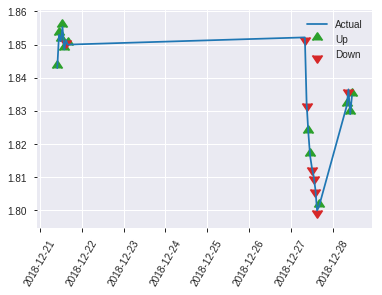


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16226007366224676
RMSE: 0.40281518549112166
LogLoss: 0.49384963889020667
Null degrees of freedom: 219
Residual degrees of freedom: 161
Null deviance: 303.92457192432397
Residual deviance: 217.29384111169097
AIC: 335.293841111691
AUC: 0.8441439185240839
pr_auc: 0.8161316974472929
Gini: 0.6882878370481678
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4927864855131088: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      95   26   0.2149   (26.0/121.0)
1      21   78   0.2121   (21.0/99.0)
Total  116  104  0.2136   (47.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492786     0.768473  103
max f2                       0.225319     0.854093  165
max f0point5                 0.499067     0.757576  98
max accuracy                 0.492786     0.786364  103
max precision                0.941225     1         0
max recall                   0.0556509    1         208
max specificity              0.941225     1         0
max absolute_mcc             0.492786     0.570981  103
max min_per_class_accuracy   0.492786     0.785124  103
max mean_per_class_accuracy  0.492786     0.786501  103

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 44.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.912879           2.22222   2.22222            1                0.925765   1                           0.925765            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.898259           2.22222   2.22222            1                0.903279   1                           0.916771            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.895791           2.22222   2.22222            1                0.896686   1                           0.911032            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.880017           2.22222   2.22222            1                0.891728   1                           0.906742            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.872654           2.22222   2.22222            1                0.875651   1                           0.901089            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.783722           2.22222   2.22222            1                0.825218   1                           0.863153            0.111111        0.222222                   122.222   122.222
    7        0.15                        0.734775           1.81818   2.08754            0.818182         0.757774   0.939394                    0.828027            0.0909091       0.313131                   81.8182   108.754
    8        0.2                         0.671302           1.61616   1.9697             0.727273         0.702048   0.886364                    0.796532            0.0808081       0.393939                   61.6162   96.9697
    9        0.3                         0.595024           1.41414   1.78451            0.636364         0.633136   0.80303                     0.742067            0.141414        0.535354                   41.4141   78.4512
    10       0.4                         0.543777           1.41414   1.69192            0.636364         0.569159   0.761364                    0.69884             0.141414        0.676768                   41.4141   69.1919
    11       0.5                         0.458681           1.21212   1.59596            0.545455         0.500787   0.718182                    0.659229            0.121212        0.79798                    21.2121   59.596
    12       0.6                         0.384779           0.808081  1.46465            0.363636         0.418477   0.659091                    0.619104            0.0808081       0.878788                   -19.1919  46.4646
    13       0.7                         0.282635           0.505051  1.32756            0.227273         0.332227   0.597403                    0.578121            0.0505051       0.929293                   -49.4949  32.7561
    14       0.8                         0.191216           0.40404   1.21212            0.181818         0.232467   0.545455                    0.534915            0.040404        0.969697                   -59.596   21.2121
    15       0.9                         0.0945094          0.10101   1.08866            0.0454545        0.14781    0.489899                    0.491903            0.010101        0.979798                   -89.899   8.86644
    16       1                           0.00937252         0.20202   1                  0.0909091        0.0511601  0.45                        

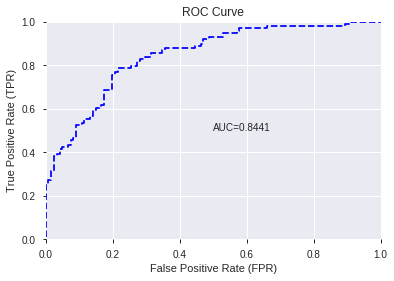

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


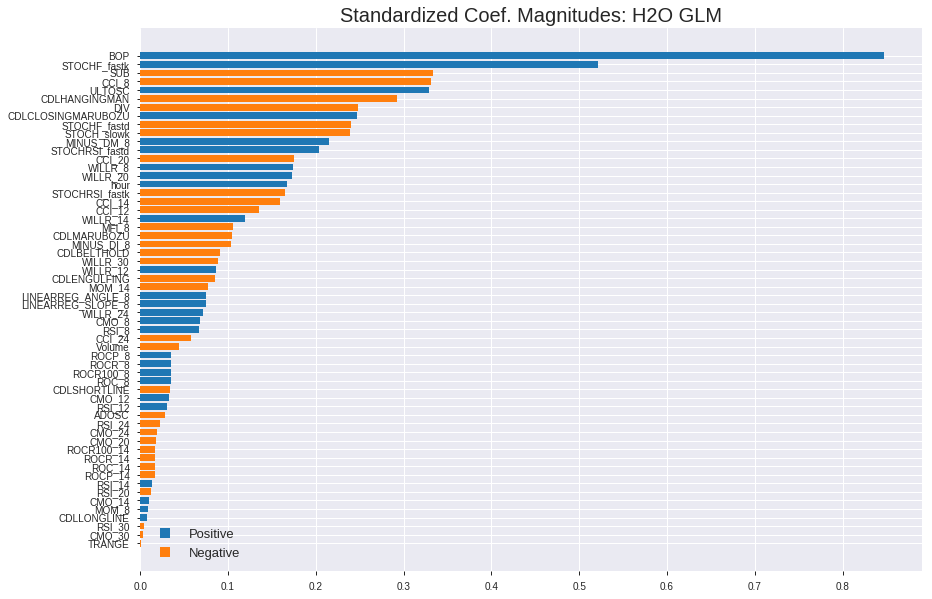

'log_likelihood'
--2019-08-28 13:34:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_133419_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_133419_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'ULTOSC',
 'CDLHANGINGMAN',
 'DIV',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MINUS_DM_8',
 'STOCHRSI_fastd',
 'CCI_20',
 'WILLR_8',
 'WILLR_20',
 'hour',
 'STOCHRSI_fastk',
 'CCI_14',
 'CCI_12',
 'WILLR_14',
 'MFI_8',
 'CDLMARUBOZU',
 'MINUS_DI_8',
 'CDLBELTHOLD',
 'WILLR_30',
 'WILLR_12',
 'CDLENGULFING',
 'MOM_14',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'WILLR_24',
 'CMO_8',
 'RSI_8',
 'CCI_24',
 'Volume',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'ROC_8',
 'CDLSHORTLINE',
 'CMO_12',
 'RSI_12',
 'ADOSC',
 'RSI_24',
 'CMO_24',
 'CMO_20',
 'ROCR100_14',
 'ROCR_14',
 'ROC_14',
 'ROCP_14',
 'RSI_14',
 'RSI_20',
 'CMO_14',
 'MOM_8',
 'CDLLONGLINE',
 'RSI_30',
 'CMO_30',
 'TRANGE']

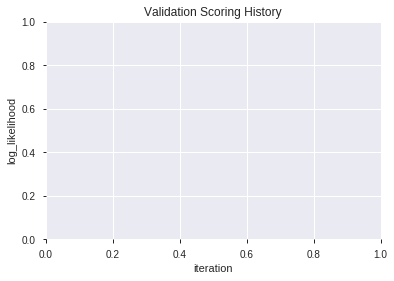

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_133431_model_6  0.844478  0.492097              0.229568  0.404010  0.163224
1               XGBoost_3_AutoML_20190828_133431  0.841389  0.495972              0.256657  0.406236  0.165028
2  XGBoost_grid_1_AutoML_20190828_133431_model_2  0.841139  0.505037              0.213958  0.409290  0.167519
3  XGBoost_grid_1_AutoML_20190828_133431_model_1  0.841055  0.493700              0.226814  0.405321  0.164285
4  XGBoost_grid_1_AutoML_20190828_133431_model_3  0.835796  0.502345              0.234619  0.409110  0.167371
5  XGBoost_grid_1_AutoML_20190828_133431_model_4  0.834126  0.512728              0.221304  0.412889  0.170478
6               XGBoost_2_AutoML_20190828_133431  0.832624  0.507081              0.223600  0.411188  0.169076
7               XGBoost_1_AutoML_20190828_133431  0.826530  0.509453              0.247016  0.413532  0.171009
8  XGBoost_grid_1_AutoML_20190828_133431_model_7  0.824025  0.507411              0.245179  0.413403  0.170902
9  XGBoost_grid_1_AutoML_20190828_133431_model_5  0.820436  0.514518              0.250689  0.415928  0.172996

variable  relative_importance  scaled_importance  percentage
0                  BOP          2155.227783           1.000000    0.217860
1         STOCHF_fastk           798.944397           0.370701    0.080761
2                  DIV           628.855530           0.291781    0.063568
3                CCI_8           535.327759           0.248386    0.054113
4              WILLR_8           390.090302           0.180997    0.039432
5               TRANGE           376.954803           0.174903    0.038104
6               ULTOSC           352.317291           0.163471    0.035614
7                 hour           283.568817           0.131573    0.028664
8                MFI_8           251.224365           0.116565    0.025395
9          STOCH_slowk           215.633621           0.100051    0.021797
10              Volume           214.896820           0.099710    0.021723
11                 SUB           187.360352           0.086933    0.018939
12              CCI_24           173.201355           0.080363    0.017508
13  CDLCLOSINGMARUBOZU           172.130966           0.079867    0.017400
14              CCI_20           171.165283           0.079419    0.017302
15      STOCHRSI_fastd           170.228317           0.078984    0.017207
16               ADOSC           141.033783           0.065438    0.014256
17          MINUS_DI_8           139.701080           0.064820    0.014122
18              CCI_12           138.866241           0.064432    0.014037
19            WILLR_20           136.410828           0.063293    0.013789
20               MOM_8           127.281471           0.059057    0.012866
21            WILLR_24           124.957565           0.057979    0.012631
22              MOM_14           122.211807           0.056705    0.012354
23          MINUS_DM_8           120.915123           0.056103    0.012223
24              CMO_20           120.297279           0.055817    0.012160
25   LINEARREG_ANGLE_8           117.077240           0.054322    0.011835
26              ROC_14           117.060555           0.054315    0.011833
27      STOCHRSI_fastk           113.302444           0.052571    0.011453
28              CCI_14           109.372246           0.050747    0.011056
29            WILLR_12           105.667618           0.049029    0.010681
30            WILLR_30           101.181793           0.046947    0.010228
31               CMO_8           100.609283           0.046682    0.010170
32         CDLLONGLINE            98.403152           0.045658    0.009947
33              CMO_30            95.625320           0.044369    0.009666
34            WILLR_14            95.386490           0.044258    0.009642
35              CMO_24            69.420769           0.032210    0.007017
36              CMO_14            60.225182           0.027944    0.006088
37               ROC_8            58.680832           0.027227    0.005932
38              CMO_12            53.643375           0.024890    0.005423
39       CDLHANGINGMAN            52.453857           0.024338    0.005302
40             ROCP_14            44.691563           0.020736    0.004518
41              RSI_30            37.474777           0.017388    0.003788
42   LINEARREG_SLOPE_8            33.755730           0.015662    0.003412
43        STOCHF_fastd            32.831936           0.015234    0.003319
44               RSI_8            30.183601           0.014005    0.003051
45              RSI_14            26.773256           0.012422    0.002706
46         CDLBELTHOLD            26.399668           0.012249    0.002669
47        CDLSHORTLINE            19.911596           0.009239    0.002013
48              ROCP_8            14.173851           0.006576    0.001433
49        CDLENGULFING            14.120926           0.006552    0.001427
50              RSI_24             9.777129           0.004536    0.000988
51              RSI_20             3.539370           0.001642    0.000358
52         CDLMARUBOZU             2.16

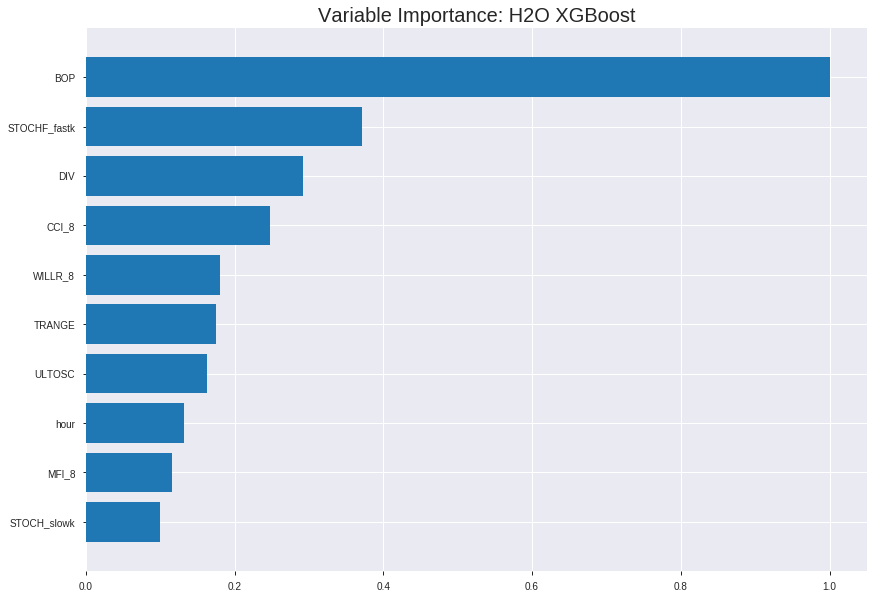

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_133431_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12063471507542012
RMSE: 0.34732508558326175
LogLoss: 0.3951242067748165
Mean Per-Class Error: 0.15442733021403554
AUC: 0.9306007196811384
pr_auc: 0.9306145541899818
Gini: 0.8612014393622769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46395836273829144: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      638  151  0.1914   (151.0/789.0)
1      89   657  0.1193   (89.0/746.0)
Total  727  808  0.1564   (240.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463958     0.84556   217
max f2                       0.301119     0.899379  282
max f0point5                 0.640254     0.865718  144
max accuracy                 0.507083     0.845603  200
max precision                0.962035     1         0
max recall                   0.15208      1         348
max specificity              0.962035     1         0
max absolute_mcc             0.507083     0.691034  200
max min_per_class_accuracy   0.507083     0.844504  200
max mean_per_class_accuracy  0.507083     0.845573  200

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.942714           2.05764    2.05764            1                0.949725  1                           0.949725            0.0214477       0.0214477                  105.764   105.764
    2        0.0201954                   0.929707           2.05764    2.05764            1                0.936697  1                           0.943421            0.0201072       0.041555                   105.764   105.764
    3        0.0306189                   0.917096           2.05764    2.05764            1                0.92271   1                           0.93637             0.0214477       0.0630027                  105.764   105.764
    4        0.0403909                   0.909933           2.05764    2.05764            1                0.912431  1                           0.930579            0.0201072       0.0831099                  105.764   105.764
    5        0.0501629                   0.904713           2.05764    2.05764            1                0.907188  1                           0.926022            0.0201072       0.103217                   105.764   105.764
    6        0.100326                    0.854988           2.05764    2.05764            1                0.879036  1                           0.902529            0.103217        0.206434                   105.764   105.764
    7        0.150489                    0.811207           2.03092    2.04873            0.987013         0.833802  0.995671                    0.87962             0.101877        0.308311                   103.092   104.873
    8        0.2                         0.765138           2.03057    2.04424            0.986842         0.786914  0.993485                    0.85667             0.100536        0.408847                   103.057   104.424
    9        0.300326                    0.677864           1.80378    1.96391            0.876623         0.720748  0.954447                    0.811264            0.180965        0.589812                   80.3776   96.3909
    10       0.4                         0.589193           1.50625    1.84987            0.732026         0.635255  0.899023                    0.767405            0.150134        0.739946                   50.6247   84.9866
    11       0.500326                    0.494918           1.13571    1.70666            0.551948         0.544313  0.829427                    0.722671            0.113941        0.853887                   13.5711   70.6663
    12       0.6                         0.369401           0.699329   1.53932            0.339869         0.430824  0.7481                      0.674188            0.0697051       0.923592                   -30.0671  53.9321
    13       0.699674                    0.278009           0.524497   1.39475            0.254902         0.325167  0.67784                     0.624467            0.0522788       0.975871                   -47.5503  39.4751
    14       0.8                         0.1944             0.213781   1.24665            0.103896         0.235129  0.605863                    0.575641            0.0214477       0.997319                   -78.6219  24.6649
    15       0.899674                    0.120874           0.0268973  1.11151            0.0130719        0.156955  0.540188                    0.529255            0.00268097      1                          -97.3103  11.1513
    16       1                           0.046654           0          1                  0                0.092039  0.485993                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1887787606084315
RMSE: 0.43448677840462707
LogLoss: 0.553990122266494
Mean Per-Class Error: 0.2680330606111204
AUC: 0.7881950242110536
pr_auc: 0.7695160358917659
Gini: 0.5763900484221072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26611167192459106: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  106  0.5      (106.0/212.0)
1      18   208  0.0796   (18.0/226.0)
Total  124  314  0.2831   (124.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.266112     0.77037   285
max f2                       0.14894      0.873328  334
max f0point5                 0.387353     0.728682  241
max accuracy                 0.387353     0.73516   241
max precision                0.951887     1         0
max recall                   0.107354     1         362
max specificity              0.951887     1         0
max absolute_mcc             0.379661     0.477     247
max min_per_class_accuracy   0.493764     0.698113  199
max mean_per_class_accuracy  0.387353     0.731967  241

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.935167           1.93805    1.93805            1                0.944801   1                           0.944801            0.0221239       0.0221239                  93.8053   93.8053
    2        0.0205479                   0.917704           0.969027   1.50737            0.5              0.928629   0.777778                    0.937614            0.00884956      0.0309735                  -3.09735  50.7375
    3        0.0319635                   0.909773           1.93805    1.66119            1                0.913376   0.857143                    0.928957            0.0221239       0.0530973                  93.8053   66.1188
    4        0.0410959                   0.904966           1.45354    1.61504            0.75             0.906136   0.833333                    0.923886            0.0132743       0.0663717                  45.354    61.5044
    5        0.0502283                   0.883451           1.93805    1.67377            1                0.892248   0.863636                    0.918133            0.0176991       0.0840708                  93.8053   67.3773
    6        0.100457                    0.836356           1.93805    1.80591            1                0.857495   0.931818                    0.887814            0.0973451       0.181416                   93.8053   80.5913
    7        0.150685                    0.802965           1.3214     1.64441            0.681818         0.818585   0.848485                    0.864738            0.0663717       0.247788                   32.14     64.4409
    8        0.200913                    0.753038           1.58568    1.62973            0.818182         0.773665   0.840909                    0.84197             0.079646        0.327434                   58.568    62.9726
    9        0.30137                     0.66439            1.23331    1.49759            0.636364         0.706903   0.772727                    0.796947            0.123894        0.451327                   23.3307   49.7586
    10       0.399543                    0.584866           1.17185    1.41755            0.604651         0.626356   0.731429                    0.755031            0.115044        0.566372                   17.1846   41.7547
    11       0.5                         0.499435           1.18926    1.37168            0.613636         0.539951   0.707763                    0.711818            0.119469        0.685841                   18.926    37.1681
    12       0.600457                    0.394062           1.3214     1.36327            0.681818         0.45222    0.703422                    0.668387            0.132743        0.818584                   32.14     36.3269
    13       0.69863                     0.281851           0.856349   1.29204            0.44186          0.337583   0.666667                    0.621902            0.0840708       0.902655                   -14.3651  29.2035
    14       0.799087                    0.187667           0.616653   1.20713            0.318182         0.239617   0.622857                    0.573843            0.0619469       0.964602                   -38.3347  20.713
    15       0.899543                    0.11338            0.308327   1.10676            0.159091         0.145087   0.571066                    0.525962            0.0309735       0.995575                   -69.1673  10.6756
    16       1                           0.0549807          0.0440467  1                  0.0227273        0.0849461  0.515982  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:34:44  8.526 sec   0                  0.5              0.693147            0.5             0                  1                0.514007                         0.5                0.693147              0.5               0                    1                  0.484018
    2019-08-28 13:34:44  8.647 sec   5                  0.465818         0.626588            0.864614        0.842705           2.05764          0.238436                         0.476377           0.646604              0.761876          0.707317             1.61504            0.292237
    2019-08-28 13:34:44  8.709 sec   10                 0.442009         0.581252            0.872747        0.868775           2.05764          0.209121                         0.460219           0.614694              0.774096          0.746331             1.55044            0.305936
    2019-08-28 13:34:44  8.772 sec   15                 0.423162         0.545249            0.883603        0.883732           2.05764          0.201303                         0.450501           0.594756              0.778198          0.748705             1.55044            0.294521
    2019-08-28 13:34:44  8.836 sec   20                 0.407951         0.515836            0.893692        0.895119           2.05764          0.197394                         0.444631           0.581998              0.777644          0.748951             1.93805            0.278539
    2019-08-28 13:34:44  8.902 sec   25                 0.395791         0.491928            0.899809        0.899878           2.05764          0.180456                         0.439985           0.571322              0.780389          0.756759             1.93805            0.283105
    2019-08-28 13:34:44  8.972 sec   30                 0.385972         0.472515            0.904836        0.904895           2.05764          0.185668                         0.438283           0.566766              0.780525          0.755556             1.93805            0.285388
    2019-08-28 13:34:44  9.059 sec   35                 0.37902          0.458001            0.906882        0.906927           2.05764          0.183713                         0.436734           0.562802              0.782476          0.757673             1.55044            0.280822
    2019-08-28 13:34:44  9.142 sec   40                 0.372502         0.444625            0.910522        0.907801           2.05764          0.178502                         0.435847           0.559923              0.784428          0.760598             1.55044            0.289954
    2019-08-28 13:34:45  9.224 sec   45                 0.366293         0.432184            0.915183        0.91449            2.05764          0.166775                         0.43603            0.558952              0.783822          0.761954             1.93805            0.276256
    2019-08-28 13:34:45  9.298 sec   50                 0.360748         0.421418            0.919828        0.920556           2.05764          0.160261                         0.436012           0.558539              0.783269          0.762044             1.93805            0.271689
    2019-08-28 13:34:45  9.365 sec   55                 0.355939         0.412164            0.924095        0.924375           2.05764          0.154397                         0.435043           0.555983              0.78567           0

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2155.227783203125      1.0                    0.2178602047361094
STOCHF_fastk  798.9443969726562      0.3707006763736386     0.08076092525057514
DIV           628.8555297851562      0.2917814695440422     0.06356757069306791
CCI_8         535.3277587890625      0.248385698700233      0.054113359172354346
WILLR_8       390.0903015136719      0.18099724982846827    0.03943209790430284
---           ---                    ---                    ---
ROCP_8        14.173851013183594     0.006576497910637663   0.001432757181258117
CDLENGULFING  14.120925903320312     0.0065519412905552035  0.0014274072709793255
RSI_24        9.777129173278809      0.004536471388071995   0.000988316585384867
RSI_20        3.539369583129883      0.001642225295495045   0.00035777553909936824
CDLMARUBOZU   2.1633033752441406     0.001003746978441886   0.00021867652222660043


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.7731092436974789)

('auc', 0.8444778362133735)

('logloss', 0.49209720602055257)

('mean_per_class_error', 0.22956841138659323)

('rmse', 0.4040103590010717)

('mse', 0.16322437018017483)

xgboost prediction progress: |████████████████████████████████████████████| 100%


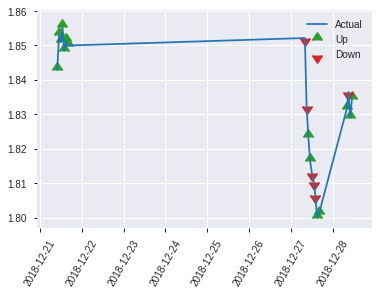


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16322437018017483
RMSE: 0.4040103590010717
LogLoss: 0.49209720602055257
Mean Per-Class Error: 0.22956841138659323
AUC: 0.8444778362133735
pr_auc: 0.8052842418908135
Gini: 0.6889556724267469
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33858832716941833: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   47   0.3884   (47.0/121.0)
1      7    92   0.0707   (7.0/99.0)
Total  81   139  0.2455   (54.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338588     0.773109  138
max f2                       0.261297     0.877034  156
max f0point5                 0.619422     0.762712  48
max accuracy                 0.338588     0.754545  138
max precision                0.927495     1         0
max recall                   0.113507     1         198
max specificity              0.927495     1         0
max absolute_mcc             0.338588     0.557889  138
max min_per_class_accuracy   0.436783     0.747475  103
max mean_per_class_accuracy  0.338588     0.770432  138

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 43.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.918893           2.22222   2.22222            1                0.921983   1                           0.921983            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.916436           2.22222   2.22222            1                0.917723   1                           0.920279            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.906003           2.22222   2.22222            1                0.912161   1                           0.917959            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.899245           2.22222   2.22222            1                0.90373    1                           0.914797            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.883779           2.22222   2.22222            1                0.896743   1                           0.911515            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.755711           2.0202    2.12121            0.909091         0.827504   0.954545                    0.869509            0.10101         0.212121                   102.02    112.121
    7        0.15                        0.700924           1.61616   1.95286            0.727273         0.728705   0.878788                    0.822575            0.0808081       0.292929                   61.6162   95.2862
    8        0.2                         0.640341           2.22222   2.0202             1                0.677372   0.909091                    0.786274            0.111111        0.40404                    122.222   102.02
    9        0.3                         0.565567           1.11111   1.71717            0.5              0.601508   0.772727                    0.724685            0.111111        0.515152                   11.1111   71.7172
    10       0.4                         0.480559           1.31313   1.61616            0.590909         0.52605    0.727273                    0.675027            0.131313        0.646465                   31.3131   61.6162
    11       0.5                         0.423626           1.31313   1.55556            0.590909         0.444265   0.7                         0.628874            0.131313        0.777778                   31.3131   55.5556
    12       0.6                         0.349147           1.11111   1.48148            0.5              0.383717   0.666667                    0.588015            0.111111        0.888889                   11.1111   48.1481
    13       0.7                         0.268289           0.707071  1.37085            0.318182         0.315555   0.616883                    0.549092            0.0707071       0.959596                   -29.2929  37.0851
    14       0.8                         0.178151           0.20202   1.22475            0.0909091        0.216037   0.551136                    0.50746             0.020202        0.979798                   -79.798   22.4747
    15       0.9                         0.125752           0.10101   1.09989            0.0454545        0.151137   0.494949                    0.467869            0.010101        0.989899                   -89.899   9.98878
    16       1                           0.0626917          0.10101   1                  0.0454545        0.0964211  0.45                        

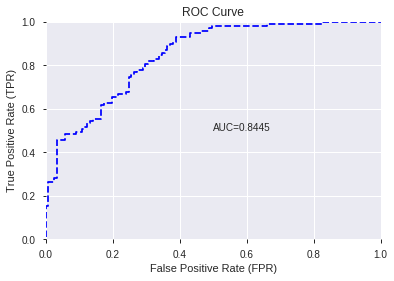

This function is available for GLM models only


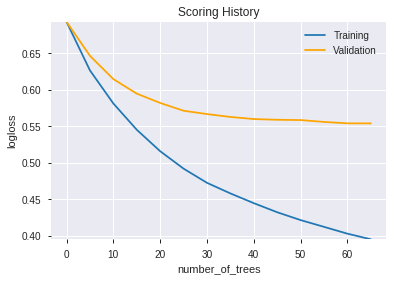

--2019-08-28 13:34:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_133431_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_133431_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'DIV',
 'CCI_8',
 'WILLR_8',
 'TRANGE',
 'ULTOSC',
 'hour',
 'MFI_8',
 'STOCH_slowk',
 'Volume',
 'SUB',
 'CCI_24',
 'CDLCLOSINGMARUBOZU',
 'CCI_20',
 'STOCHRSI_fastd',
 'ADOSC',
 'MINUS_DI_8',
 'CCI_12',
 'WILLR_20',
 'MOM_8',
 'WILLR_24',
 'MOM_14',
 'MINUS_DM_8',
 'CMO_20',
 'LINEARREG_ANGLE_8',
 'ROC_14',
 'STOCHRSI_fastk',
 'CCI_14',
 'WILLR_12',
 'WILLR_30',
 'CMO_8',
 'CDLLONGLINE',
 'CMO_30',
 'WILLR_14',
 'CMO_24',
 'CMO_14',
 'ROC_8',
 'CMO_12',
 'CDLHANGINGMAN',
 'ROCP_14',
 'RSI_30',
 'LINEARREG_SLOPE_8',
 'STOCHF_fastd',
 'RSI_8',
 'RSI_14',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'ROCP_8',
 'CDLENGULFING',
 'RSI_24',
 'RSI_20',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

61

['BBANDS_upperband_20_2_3',
 'BBANDS_middleband_20_5_2',
 'BBANDS_upperband_20_6_2',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_middleband_20_7_5',
 'BBANDS_lowerband_24_0_4',
 'MA_30_5',
 'BBANDS_upperband_30_6_5',
 'BOP',
 'AROONOSC_8',
 'CCI_8',
 'DX_8',
 'PLUS_DM_8',
 'ROCR_8',
 'RSI_8',
 'WILLR_8',
 'ADXR_12',
 'aroonup_12',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'AROONOSC_14',
 'ROCR_14',
 'WILLR_14',
 'aroonup_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROCR_20',
 'RSI_20',
 'aroonup_24',
 'AROONOSC_24',
 'CCI_24',
 'MFI_24',
 'MINUS_DI_24',
 'MINUS_DM_24',
 'WILLR_24',
 'DX_30',
 'RSI_30',
 'WILLR_30',
 'MACDEXT_signal',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'ATR_8',
 'NATR_12',
 'ATR_24',
 'ATR_30',
 'TRANGE',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'BETA_8',
 'LINEARREG_SLOPE_8',
 'BETA_14',
 'LINEARREG_INTERCEPT_14',
 'LINEARREG_SLOPE_14']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_133645_model_5  0.827031  0.500258              0.256198  0.411691  0.169490
1  DeepLearning_grid_1_AutoML_20190828_133645_model_8  0.825027  0.523016              0.255739  0.420073  0.176461
2  DeepLearning_grid_1_AutoML_20190828_133645_model_6  0.824693  0.504961              0.269054  0.412406  0.170078
3  DeepLearning_grid_1_AutoML_20190828_133645_model_3  0.817931  0.550519              0.255739  0.426112  0.181572
4  DeepLearning_grid_1_AutoML_20190828_133645_model_9  0.806745  0.531036              0.265840  0.422551  0.178549
5               DeepLearning_1_AutoML_20190828_133645  0.803072  0.536541              0.260790  0.426550  0.181945
6  DeepLearning_grid_1_AutoML_20190828_133645_model_7  0.802738  0.556526              0.240129  0.426712  0.182083
7  DeepLearning_grid_1_AutoML_20190828_133645_model_2  0.792721  0.563751              0.285124  0.437082  0.191040
8  DeepLearning_grid_1_AutoML_20190828_133645_model_4  0.760414  0.655313              0.306244  0.467940  0.218968
9  DeepLearning_grid_1_AutoML_20190828_133645_model_1  0.756240  0.707254              0.293848  0.477260  0.227777

variable  relative_importance  scaled_importance  percentage
0         TRANGE             1.000000           1.000000    0.037194
1            BOP             0.958496           0.958496    0.035650
2    CDLLONGLINE             0.668938           0.668938    0.024880
3   STOCHF_fastk             0.545181           0.545181    0.020277
4          CCI_8             0.542097           0.542097    0.020163
..           ...                  ...                ...         ...
56        RSI_12             0.377471           0.377471    0.014040
57      WILLR_30             0.377423           0.377423    0.014038
58       ROCR_14             0.374614           0.374614    0.013933
59        RSI_20             0.372480           0.372480    0.013854
60        CMO_12             0.366634           0.366634    0.013636

[61 rows x 4 columns]

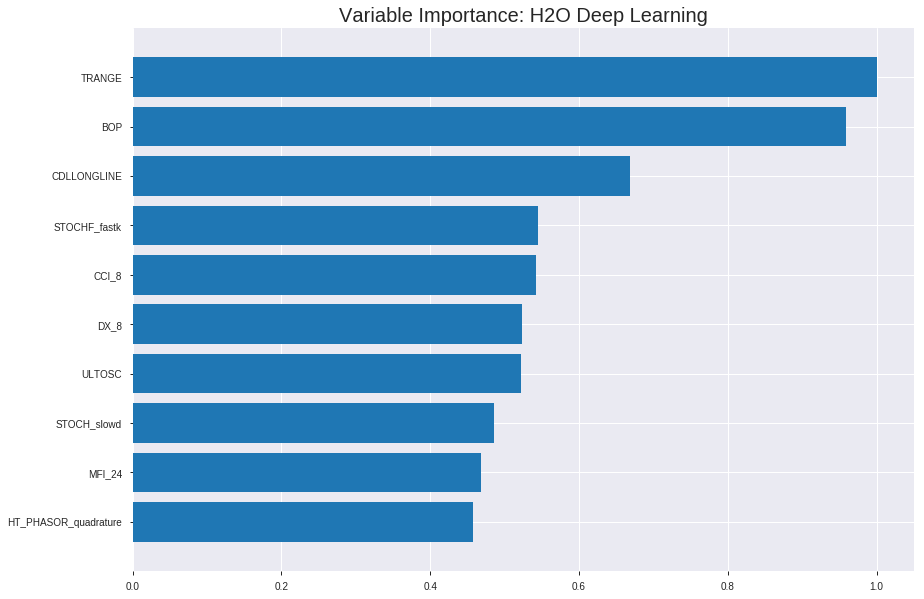

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_133645_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17636569862379986
RMSE: 0.41995916304302716
LogLoss: 0.5256737098227842
Mean Per-Class Error: 0.2565868833185523
AUC: 0.8211262771961658
pr_auc: 0.7992648312816091
Gini: 0.6422525543923316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43322340417357935: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      428  361   0.4575   (361.0/789.0)
1      78   668   0.1046   (78.0/746.0)
Total  506  1029  0.286    (439.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433223     0.752676  244
max f2                       0.268612     0.854122  303
max f0point5                 0.656301     0.751166  140
max accuracy                 0.571662     0.743322  181
max precision                0.988539     1         0
max recall                   0.0365784    1         388
max specificity              0.988539     1         0
max absolute_mcc             0.571662     0.486648  181
max min_per_class_accuracy   0.573597     0.740177  180
max mean_per_class_accuracy  0.571662     0.743413  181

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 53.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.97716            2.05764   2.05764            1                0.983256   1                           0.983256            0.0214477       0.0214477                  105.764   105.764
    2        0.0201954                   0.966321           1.92046   1.99127            0.933333         0.971379   0.967742                    0.977509            0.0187668       0.0402145                  92.0465   99.1265
    3        0.0306189                   0.957314           2.05764   2.01386            1                0.961847   0.978723                    0.972177            0.0214477       0.0616622                  105.764   101.386
    4        0.0403909                   0.947208           1.50894   1.8917             0.733333         0.952355   0.919355                    0.967382            0.0147453       0.0764075                  50.8937   89.1702
    5        0.0501629                   0.940272           1.92046   1.89731            0.933333         0.94351    0.922078                    0.962731            0.0187668       0.0951743                  92.0465   89.7305
    6        0.100326                    0.89772            1.89731   1.89731            0.922078         0.920295   0.922078                    0.941513            0.0951743       0.190349                   89.7305   89.7305
    7        0.150489                    0.837303           1.79041   1.86167            0.87013          0.868537   0.904762                    0.917188            0.0898123       0.280161                   79.0415   86.1675
    8        0.2                         0.787603           1.5703    1.78954            0.763158         0.811734   0.869707                    0.891082            0.077748        0.357909                   57.0305   78.9544
    9        0.300326                    0.699679           1.45638   1.67825            0.707792         0.742295   0.815618                    0.841379            0.146113        0.504021                   45.6382   67.8249
    10       0.4                         0.633423           1.34486   1.59517            0.653595         0.667045   0.775244                    0.797937            0.134048        0.63807                    34.4863   59.5174
    11       0.500326                    0.567128           1.09563   1.495              0.532468         0.601853   0.726562                    0.758618            0.10992         0.747989                   9.56269   49.5005
    12       0.6                         0.496491           0.914507  1.39857            0.444444         0.532809   0.679696                    0.721106            0.0911528       0.839142                   -8.5493   39.857
    13       0.699674                    0.399078           0.753123  1.30662            0.366013         0.453962   0.635009                    0.683049            0.075067        0.914209                   -24.6877  30.6621
    14       0.8                         0.265858           0.494368  1.20476            0.24026          0.336437   0.585505                    0.639582            0.0495979       0.963807                   -50.5632  20.4759
    15       0.899674                    0.128746           0.215178  1.09512            0.104575         0.196454   0.532223                    0.590488            0.0214477       0.985255                   -78.4822  9.51238
    16       1                           0.00165522         0.146974  1                  0.0714286        0.0655056  0.485993                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.1857291435797968
RMSE: 0.43096304201148944
LogLoss: 0.549817290252904
Mean Per-Class Error: 0.264213558190015
AUC: 0.7942790950075138
pr_auc: 0.7898354097614019
Gini: 0.5885581900150276
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2916499494478114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  110  0.5189   (110.0/212.0)
1      20   206  0.0885   (20.0/226.0)
Total  122  316  0.2968   (130.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29165      0.760148  288
max f2                       0.0723875    0.858896  366
max f0point5                 0.501892     0.737977  220
max accuracy                 0.501892     0.737443  220
max precision                0.984856     1         0
max recall                   0.0481567    1         379
max specificity              0.984856     1         0
max absolute_mcc             0.501892     0.474689  220
max min_per_class_accuracy   0.551099     0.721698  200
max mean_per_class_accuracy  0.501892     0.735786  220

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 51.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.977196           1.93805   1.93805            1                0.982549   1                           0.982549            0.0221239       0.0221239                  93.8053   93.8053
    2        0.0205479                   0.973099           1.93805   1.93805            1                0.975083   1                           0.979231            0.0176991       0.039823                   93.8053   93.8053
    3        0.0319635                   0.961721           1.93805   1.93805            1                0.966597   1                           0.974719            0.0221239       0.0619469                  93.8053   93.8053
    4        0.0410959                   0.958936           1.45354   1.83038            0.75             0.960105   0.944444                    0.971471            0.0132743       0.0752212                  45.354    83.0383
    5        0.0502283                   0.945865           1.93805   1.84996            1                0.951108   0.954545                    0.967769            0.0176991       0.0929204                  93.8053   84.996
    6        0.100457                    0.897499           1.84996   1.84996            0.954545         0.923739   0.954545                    0.945754            0.0929204       0.185841                   84.996    84.996
    7        0.150685                    0.843997           1.3214    1.67377            0.681818         0.874552   0.863636                    0.92202             0.0663717       0.252212                   32.14     67.3773
    8        0.200913                    0.798676           1.40949   1.6077             0.727273         0.821959   0.829545                    0.897005            0.0707965       0.323009                   40.9493   60.7703
    9        0.30137                     0.712809           1.40949   1.54163            0.727273         0.753295   0.795455                    0.849101            0.141593        0.464602                   40.9493   54.1633
    10       0.399543                    0.631608           1.30706   1.48399            0.674419         0.668409   0.765714                    0.804703            0.128319        0.59292                    30.7059   48.3995
    11       0.5                         0.555949           1.18926   1.42478            0.613636         0.597934   0.73516                     0.76316             0.119469        0.712389                   18.926    42.4779
    12       0.600457                    0.462092           0.969027  1.34853            0.5              0.509379   0.695817                    0.720702            0.0973451       0.809735                   -3.09735  34.8531
    13       0.69863                     0.323483           0.811278  1.27303            0.418605         0.404756   0.656863                    0.676305            0.079646        0.889381                   -18.8722  27.3035
    14       0.799087                    0.181499           0.572607  1.18498            0.295455         0.247771   0.611429                    0.622432            0.0575221       0.946903                   -42.7393  18.4981
    15       0.899543                    0.0856777          0.352373  1.092              0.181818         0.142095   0.563452                    0.56879             0.0353982       0.982301                   -64.7627  9.19995
    16       1                           0.00428458         0.176187  1                  0.0909091        0.0443454  0.515982                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:40:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:40:11  1 min 39.670 sec  1178 obs/sec      1.4899    1             2287       0.433114         0.560377            0.24906        0.789799        0.75357            1.54323          0.286645                         0.445487           0.589376              0.205354         0.768117          0.757701             1.93805            0.287671
    2019-08-28 13:40:18  1 min 47.000 sec  1846 obs/sec      10.4651   7             16064      0.419959         0.525674            0.293983       0.821126        0.799265           2.05764          0.285993                         0.430963           0.549817              0.256324         0.794279          0.789835             1.93805            0.296804
    2019-08-28 13:40:24  1 min 53.329 sec  2068 obs/sec      19.4749   13            29894      0.407425         0.497034            0.335499       0.841597        0.827443           2.05764          0.276873                         0.432551           0.550943              0.250835         0.78616           0.778639             1.93805            0.283105
    2019-08-28 13:40:31  1 min 59.556 sec  2174 obs/sec      28.443    19            43660      0.408246         0.497353            0.332818       0.857049        0.839029           2.05764          0.250163                         0.446395           0.604307              0.202112         0.781694          0.769124             1.93805            0.278539
    2019-08-28 13:40:37  2 min  5.737 sec  2239 obs/sec      37.4508   25            57487      0.383298         0.444556            0.411871       0.872936        0.862334           2.05764          0.228664                         0.442432           0.575989              0.216214         0.774806          0.7602               1.93805            0.278539
    2019-08-28 13:40:43  2 min 11.766 sec  2292 obs/sec      46.4085   31            71237      0.380503         0.440518            0.420415       0.897636        0.85754            2.05764          0.208469                         0.449718           0.614769              0.190188         0.77011           0.754701             1.55044            0.310502
    2019-08-28 13:40:44  2 min 12.394 sec  2290 obs/sec      46.4085   31            71237      0.419959         0.525674            0.293983       0.821126        0.799265           2.05764          0.285993                         0.430963           0.549817              0.256324         0.794279          0.789835             1.93805            0.296804

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
TRANGE        1.0                    1.0                  0.037193784117020755
BOP           0.9584957361221313     0.9584957361221313   0.035650083486411445
CDLLONGLINE   0.6689376831054688     0.6689376831054688   0.024880323773164847
STOCHF_fastk  0.5451809763908386     0.5451809763908386   0.020277343540587443
CCI_8         0.542096734046936      0.542096734046936    0.020162628896683753
---           ---                    ---                  ---
RSI_12        0.3774711489677429     0.3774711489677429   0.014039580425110013
WILLR_30      0.377422958612442      0.377422958612442    0.014037788043438429
ROCR_14       0.3746139407157898     0.3746139407157898   0.013933310038209499
RSI_20        0.3724801242351532     0.3724801242351532   0.01385394532868336
CMO_12        0.36663350462913513    0.36663350462913513  0.013636487421242783


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7545454545454545)

('F1', 0.75)

('auc', 0.8270306369479923)

('logloss', 0.5002583130098739)

('mean_per_class_error', 0.2520661157024793)

('rmse', 0.41169115689082925)

('mse', 0.16948960866210938)

deeplearning prediction progress: |███████████████████████████████████████| 100%


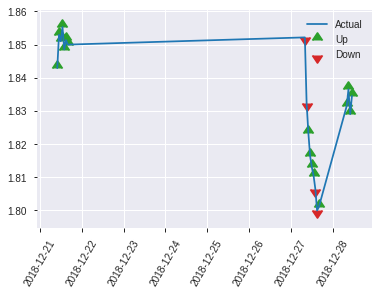


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16948960866210938
RMSE: 0.41169115689082925
LogLoss: 0.5002583130098739
Mean Per-Class Error: 0.2520661157024793
AUC: 0.8270306369479923
pr_auc: 0.7892995246082656
Gini: 0.6540612738959846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3817149604440471: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   51   0.4215   (51.0/121.0)
1      9    90   0.0909   (9.0/99.0)
Total  79   141  0.2727   (60.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381715     0.75      140
max f2                       0.163271     0.847902  175
max f0point5                 0.578533     0.742459  82
max accuracy                 0.578533     0.754545  82
max precision                0.991961     1         0
max recall                   0.108364     1         189
max specificity              0.991961     1         0
max absolute_mcc             0.381715     0.505654  140
max min_per_class_accuracy   0.533246     0.727273  100
max mean_per_class_accuracy  0.501206     0.747934  119

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.969636           2.22222   2.22222            1                0.98303    1                           0.98303             0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.965206           2.22222   2.22222            1                0.966849   1                           0.976558            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.957142           2.22222   2.22222            1                0.962169   1                           0.972447            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.95026            2.22222   2.22222            1                0.95248    1                           0.96801             0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.94655            2.22222   2.22222            1                0.950062   1                           0.964746            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.851214           1.81818   2.0202             0.818182         0.896787   0.909091                    0.930767            0.0909091       0.20202                    81.8182   102.02
    7        0.15                        0.824792           2.22222   2.08754            1                0.835917   0.939394                    0.89915             0.111111        0.313131                   122.222   108.754
    8        0.2                         0.770443           1.81818   2.0202             0.818182         0.803095   0.909091                    0.875136            0.0909091       0.40404                    81.8182   102.02
    9        0.3                         0.63055            1.0101    1.6835             0.454545         0.693853   0.757576                    0.814709            0.10101         0.505051                   1.0101    68.3502
    10       0.4                         0.560396           1.51515   1.64141            0.681818         0.604292   0.738636                    0.762104            0.151515        0.656566                   51.5152   64.1414
    11       0.5                         0.512535           1.0101    1.51515            0.454545         0.535938   0.681818                    0.716871            0.10101         0.757576                   1.0101    51.5152
    12       0.6                         0.418929           1.0101    1.43098            0.454545         0.480995   0.643939                    0.677559            0.10101         0.858586                   1.0101    43.0976
    13       0.7                         0.297673           0.606061  1.31313            0.272727         0.369609   0.590909                    0.633566            0.0606061       0.919192                   -39.3939  31.3131
    14       0.8                         0.162227           0.606061  1.22475            0.272727         0.216171   0.551136                    0.581391            0.0606061       0.979798                   -39.3939  22.4747
    15       0.9                         0.0819045          0.20202   1.11111            0.0909091        0.113888   0.5                         0.529447            0.020202        1                          -79.798   11.1111
    16       1                           0.00328515         0         1                  0                0.0422944  0.45                        0

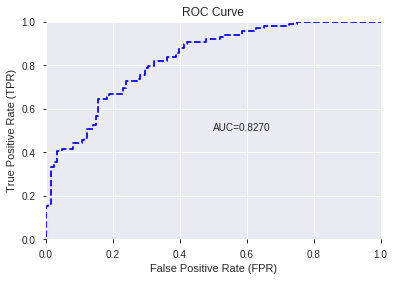

This function is available for GLM models only


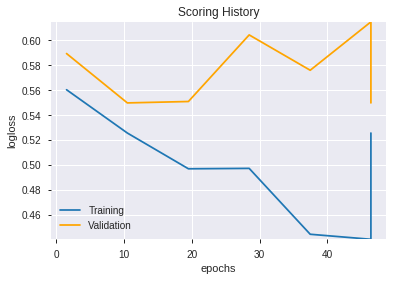

--2019-08-28 13:45:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_133645_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_133645_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'CCI_8',
 'DX_8',
 'ULTOSC',
 'STOCH_slowd',
 'MFI_24',
 'HT_PHASOR_quadrature',
 'PLUS_DM_8',
 'AROONOSC_8',
 'ADXR_12',
 'CCI_12',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'DX_30',
 'aroonup_12',
 'aroonup_24',
 'aroonup_20',
 'STOCHRSI_fastd',
 'BETA_14',
 'AROONOSC_14',
 'ROCR_20',
 'ADOSC',
 'ROCR_8',
 'BETA_8',
 'ATR_24',
 'BBANDS_middleband_20_5_2',
 'CDLBELTHOLD',
 'WILLR_8',
 'AROONOSC_24',
 'ATR_30',
 'NATR_12',
 'BBANDS_lowerband_24_0_4',
 'MINUS_DM_24',
 'ATR_8',
 'WILLR_12',
 'MINUS_DI_24',
 'MA_30_5',
 'BBANDS_upperband_30_6_5',
 'CCI_24',
 'LINEARREG_SLOPE_8',
 'WILLR_14',
 'RSI_8',
 'LINEARREG_INTERCEPT_14',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_middleband_20_7_5',
 'BBANDS_upperband_20_6_2',
 'LINEARREG_SLOPE_14',
 'PLUS_DI_20',
 'WILLR_24',
 'PLUS_DM_20',
 'MACDEXT_signal',
 'BBANDS_upperband_20_2_3',
 'RSI_30',
 'RSI_12',
 'WILLR_30',
 'ROCR_14',
 'RSI_20',
 'CMO_12']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190828_134525_model_1  0.837048  0.504212                0.2236  0.40789  0.166375

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.865616           1.000000    0.110797
1                    TRANGE             0.660395           0.762919    0.084529
2                     CCI_8             0.423616           0.489381    0.054222
3              STOCHF_fastk             0.369199           0.426515    0.047257
4               STOCH_slowd             0.319845           0.369500    0.040939
..                      ...                  ...                ...         ...
56  BBANDS_upperband_30_6_5             0.015295           0.017670    0.001958
57               aroonup_20             0.008815           0.010184    0.001128
58               PLUS_DM_20             0.005108           0.005901    0.000654
59                   RSI_30             0.001356           0.001567    0.000174
60                  ROCR_14             0.000138           0.000160    0.000018

[61 rows x 4 columns]

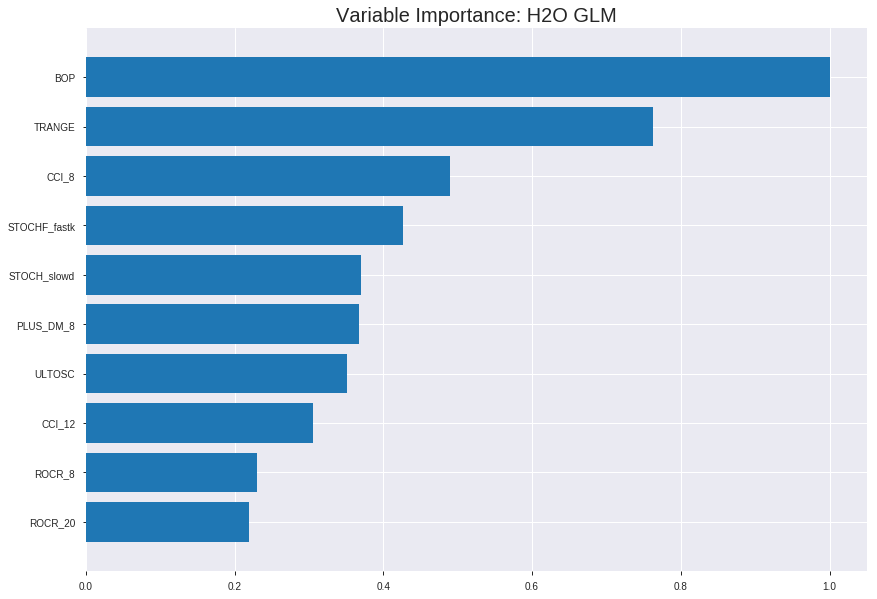

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_134525_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17796368369482296
RMSE: 0.42185742104984114
LogLoss: 0.5338792524888424
Null degrees of freedom: 1534
Residual degrees of freedom: 1473
Null deviance: 2126.7571264665794
Residual deviance: 1639.0093051407462
AIC: 1763.0093051407462
AUC: 0.8098477048695705
pr_auc: 0.7878245623705595
Gini: 0.619695409739141
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3930046379460888: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      480  309  0.3916   (309.0/789.0)
1      107  639  0.1434   (107.0/746.0)
Total  587  948  0.271    (416.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393005     0.754427  241
max f2                       0.277106     0.840224  288
max f0point5                 0.60112      0.744409  150
max accuracy                 0.524655     0.743322  185
max precision                0.974605     1         0
max recall                   0.055036     1         384
max specificity              0.974605     1         0
max absolute_mcc             0.522122     0.486076  186
max min_per_class_accuracy   0.511275     0.735925  190
max mean_per_class_accuracy  0.522122     0.742902  186

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.902207           1.92904   1.92904            0.9375           0.924062   0.9375                      0.924062            0.0201072       0.0201072                  92.9038   92.9038
    2        0.0201954                   0.887246           1.92046   1.92489            0.933333         0.895764   0.935484                    0.910369            0.0187668       0.038874                   92.0465   92.489
    3        0.0306189                   0.872605           2.05764   1.97008            1                0.880948   0.957447                    0.900354            0.0214477       0.0603217                  105.764   97.0082
    4        0.0403909                   0.860077           1.50894   1.85851            0.733333         0.866224   0.903226                    0.892096            0.0147453       0.075067                   50.8937   85.8514
    5        0.0501629                   0.854646           1.92046   1.87058            0.933333         0.857104   0.909091                    0.88528             0.0187668       0.0938338                  92.0465   87.0583
    6        0.100326                    0.81697            1.76369   1.81714            0.857143         0.834968   0.883117                    0.860124            0.0884718       0.182306                   76.3692   81.7137
    7        0.150489                    0.786155           1.81714   1.81714            0.883117         0.801455   0.883117                    0.840568            0.0911528       0.273458                   81.7137   81.7137
    8        0.2                         0.747776           1.43493   1.72252            0.697368         0.766002   0.837134                    0.822108            0.0710456       0.344504                   43.4934   72.252
    9        0.300326                    0.670576           1.53655   1.6604             0.746753         0.711044   0.806941                    0.785007            0.154155        0.49866                    53.655    66.0396
    10       0.4                         0.590763           1.34486   1.58177            0.653595         0.633564   0.76873                     0.747269            0.134048        0.632708                   34.4863   58.1769
    11       0.500326                    0.498933           1.13571   1.49233            0.551948         0.54741    0.72526                     0.707193            0.113941        0.746649                   13.5711   49.2325
    12       0.6                         0.404453           0.914507  1.39634            0.444444         0.453017   0.67861                     0.664969            0.0911528       0.837802                   -8.5493   39.6336
    13       0.699674                    0.307517           0.726226  1.30087            0.352941         0.35848    0.632216                    0.621307            0.0723861       0.910188                   -27.3774  30.0873
    14       0.8                         0.211432           0.334033  1.17962            0.162338         0.263619   0.57329                     0.57645             0.0335121       0.9437                     -66.5967  17.9625
    15       0.899674                    0.125684           0.363113  1.08916            0.176471         0.168513   0.529327                    0.531255            0.036193        0.979893                   -63.6887  8.91639
    16       1                           2.19568e-06        0.20042   1                  0.0974026        0.0801087  0.485993                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1849295340088812
RMSE: 0.43003434049954803
LogLoss: 0.553949754359467
Null degrees of freedom: 437
Residual degrees of freedom: 376
Null deviance: 608.3253468479048
Residual deviance: 485.25998481889314
AIC: 609.2599848188931
AUC: 0.7949574219402238
pr_auc: 0.7796007275252739
Gini: 0.5899148438804476
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2993032892462383: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      106  106  0.5      (106.0/212.0)
1      20   206  0.0885   (20.0/226.0)
Total  126  312  0.2877   (126.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.299303     0.765799  282
max f2                       0.223736     0.852682  315
max f0point5                 0.573933     0.74856   180
max accuracy                 0.507531     0.742009  208
max precision                0.934876     1         0
max recall                   0.0560923    1         388
max specificity              0.934876     1         0
max absolute_mcc             0.502565     0.483272  211
max min_per_class_accuracy   0.531275     0.726415  198
max mean_per_class_accuracy  0.507531     0.741234  208

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.887949           1.55044   1.55044            0.8              0.912922   0.8                         0.912922            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.879688           1.93805   1.72271            1                0.883499   0.888889                    0.899845            0.0176991       0.0353982                  93.8053   72.2714
    3        0.0319635                   0.869023           1.55044   1.66119            0.8              0.874262   0.857143                    0.890708            0.0176991       0.0530973                  55.0442   66.1188
    4        0.0410959                   0.862835           1.45354   1.61504            0.75             0.865347   0.833333                    0.885073            0.0132743       0.0663717                  45.354    61.5044
    5        0.0502283                   0.853229           1.93805   1.67377            1                0.85668    0.863636                    0.87991             0.0176991       0.0840708                  93.8053   67.3773
    6        0.100457                    0.81749            1.76187   1.71782            0.909091         0.833      0.886364                    0.856455            0.0884956       0.172566                   76.1866   71.782
    7        0.150685                    0.77545            1.58568   1.67377            0.818182         0.798667   0.863636                    0.837192            0.079646        0.252212                   58.568    67.3773
    8        0.200913                    0.750937           1.58568   1.65175            0.818182         0.76218    0.852273                    0.818439            0.079646        0.331858                   58.568    65.175
    9        0.30137                     0.675949           1.45354   1.58568            0.75             0.712874   0.818182                    0.783251            0.146018        0.477876                   45.354    58.568
    10       0.399543                    0.613535           1.17185   1.48399            0.604651         0.645759   0.765714                    0.749467            0.115044        0.59292                    17.1846   48.3995
    11       0.5                         0.53497            1.23331   1.43363            0.636364         0.57759    0.739726                    0.714935            0.123894        0.716814                   23.3307   43.3628
    12       0.600457                    0.430134           0.969027  1.3559             0.5              0.491496   0.69962                     0.677553            0.0973451       0.814159                   -3.09735  35.59
    13       0.69863                     0.309687           0.811278  1.27937            0.418605         0.378328   0.660131                    0.635505            0.079646        0.893805                   -18.8722  27.9368
    14       0.799087                    0.220345           0.484513  1.17944            0.25             0.265641   0.608571                    0.589008            0.0486726       0.942478                   -51.5487  17.9444
    15       0.899543                    0.12639            0.308327  1.08216            0.159091         0.171705   0.558376                    0.542406            0.0309735       0.973451                   -69.1673  8.21616
    16       1                           0.0132513          0.26428   1                  0.136364         0.0748519  0.515982                    0.49


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-28 13:45:26  0.000 sec   2            .22E2     62            1.3643891548704692  1.3721648087729914
     2019-08-28 13:45:26  0.015 sec   4            .14E2     62            1.3544610977892535  1.3639919125763207
     2019-08-28 13:45:26  0.030 sec   6            .85E1     62            1.341265631261397   1.352792286336295
     2019-08-28 13:45:26  0.044 sec   8            .53E1     62            1.3244851147443764  1.337997644933157
     2019-08-28 13:45:26  0.058 sec   10           .33E1     62            1.3040199533230732  1.319257389608277
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-28 13:45:26  0.275 sec   38           .42E-2    62            1.064964932840084   1.1083657139335341
     2019-08-28 13:45:26  0.291 sec   40           .26E-2    62            1.0627286651533137  1.1096085154692568
     2019-08-28 13:45:26  0.312 sec   42           .16E-2    62            1.0608933335722406  1.1110763191411184
     2019-08-28 13:45:26  0.327 sec   44           .1E-2     62            1.0592665718454388  1.1129478726048345
     2019-08-28 13:45:26  0.342 sec   46           .62E-3    62            1.0578118921464585  1.1151012765825583


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7818181818181819)

('F1', 0.7692307692307692)

('auc', 0.83704816762668)

('logloss', 0.5042123046895702)

('mean_per_class_error', 0.21763085399449045)

('rmse', 0.40789047823638963)

('mse', 0.16637464223591064)

glm prediction progress: |████████████████████████████████████████████████| 100%


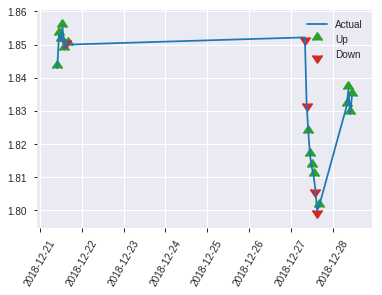


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16637464223591064
RMSE: 0.40789047823638963
LogLoss: 0.5042123046895702
Null degrees of freedom: 219
Residual degrees of freedom: 158
Null deviance: 303.92457192432397
Residual deviance: 221.85341406341092
AIC: 345.8534140634109
AUC: 0.83704816762668
pr_auc: 0.805160559660522
Gini: 0.67409633525336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.426051904564482: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      84   37   0.3058   (37.0/121.0)
1      14   85   0.1414   (14.0/99.0)
Total  98   122  0.2318   (51.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426052     0.769231  121
max f2                       0.243832     0.851254  161
max f0point5                 0.49275      0.751445  104
max accuracy                 0.49275      0.781818  104
max precision                0.915244     1         0
max recall                   0.0872929    1         206
max specificity              0.915244     1         0
max absolute_mcc             0.49275      0.562489  104
max min_per_class_accuracy   0.497757     0.77686   103
max mean_per_class_accuracy  0.49275      0.782369  104

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 44.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.890156           2.22222   2.22222            1                0.902127   1                           0.902127            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.867657           2.22222   2.22222            1                0.879712   1                           0.893161            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.84517            2.22222   2.22222            1                0.854146   1                           0.882014            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.839385           2.22222   2.22222            1                0.840385   1                           0.872763            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.831516           2.22222   2.22222            1                0.836952   1                           0.866252            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.773617           2.0202    2.12121            0.909091         0.805333   0.954545                    0.835792            0.10101         0.212121                   102.02    112.121
    7        0.15                        0.731383           1.81818   2.0202             0.818182         0.748574   0.909091                    0.806719            0.0909091       0.30303                    81.8182   102.02
    8        0.2                         0.685002           1.61616   1.91919            0.727273         0.709057   0.863636                    0.782304            0.0808081       0.383838                   61.6162   91.9192
    9        0.3                         0.606674           1.31313   1.71717            0.590909         0.641717   0.772727                    0.735441            0.131313        0.515152                   31.3131   71.7172
    10       0.4                         0.530253           1.61616   1.69192            0.727273         0.559208   0.761364                    0.691383            0.161616        0.676768                   61.6162   69.1919
    11       0.5                         0.46775            1.11111   1.57576            0.5              0.502901   0.709091                    0.653687            0.111111        0.787879                   11.1111   57.5758
    12       0.6                         0.382363           0.808081  1.44781            0.363636         0.42601    0.651515                    0.615741            0.0808081       0.868687                   -19.1919  44.7811
    13       0.7                         0.276192           0.505051  1.31313            0.227273         0.327607   0.590909                    0.574579            0.0505051       0.919192                   -49.4949  31.3131
    14       0.8                         0.190448           0.40404   1.19949            0.181818         0.233849   0.539773                    0.531988            0.040404        0.959596                   -59.596   19.9495
    15       0.9                         0.117063           0.20202   1.08866            0.0909091        0.15016    0.489899                    0.489562            0.020202        0.979798                   -79.798   8.86644
    16       1                           0.00625056         0.20202   1                  0.0909091        0.0706708  0.45                        

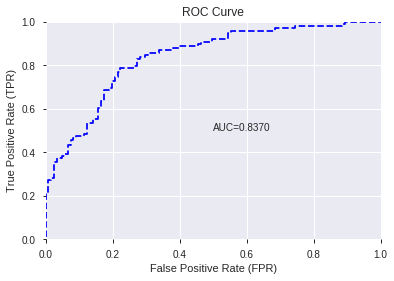

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


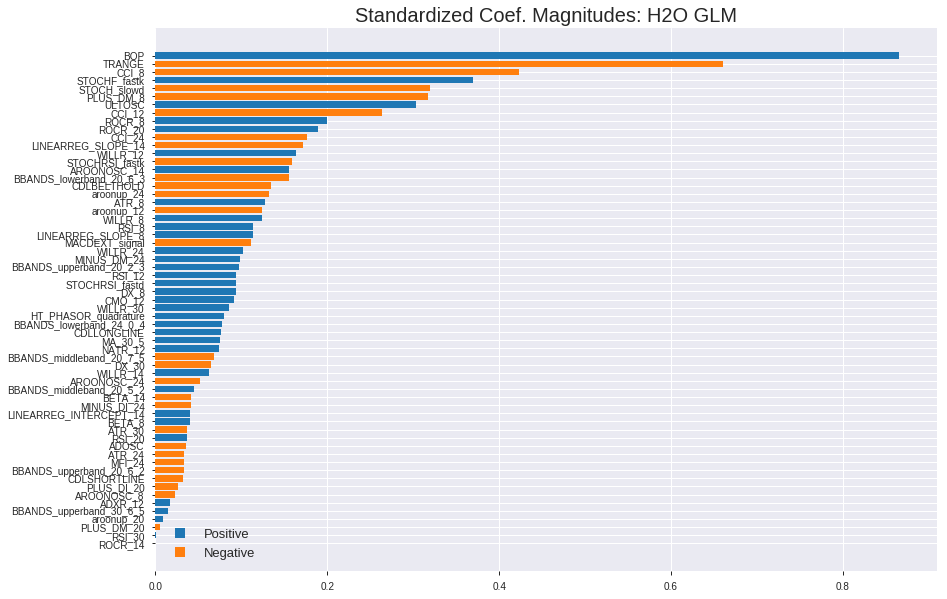

'log_likelihood'
--2019-08-28 13:45:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.33.20
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.33.20|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_134525_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_134525_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CCI_8',
 'STOCHF_fastk',
 'STOCH_slowd',
 'PLUS_DM_8',
 'ULTOSC',
 'CCI_12',
 'ROCR_8',
 'ROCR_20',
 'CCI_24',
 'LINEARREG_SLOPE_14',
 'WILLR_12',
 'STOCHRSI_fastk',
 'AROONOSC_14',
 'BBANDS_lowerband_20_6_3',
 'CDLBELTHOLD',
 'aroonup_24',
 'ATR_8',
 'aroonup_12',
 'WILLR_8',
 'RSI_8',
 'LINEARREG_SLOPE_8',
 'MACDEXT_signal',
 'WILLR_24',
 'MINUS_DM_24',
 'BBANDS_upperband_20_2_3',
 'RSI_12',
 'STOCHRSI_fastd',
 'DX_8',
 'CMO_12',
 'WILLR_30',
 'HT_PHASOR_quadrature',
 'BBANDS_lowerband_24_0_4',
 'CDLLONGLINE',
 'MA_30_5',
 'NATR_12',
 'BBANDS_middleband_20_7_5',
 'DX_30',
 'WILLR_14',
 'AROONOSC_24',
 'BBANDS_middleband_20_5_2',
 'BETA_14',
 'MINUS_DI_24',
 'LINEARREG_INTERCEPT_14',
 'BETA_8',
 'ATR_30',
 'RSI_20',
 'ADOSC',
 'ATR_24',
 'MFI_24',
 'BBANDS_upperband_20_6_2',
 'CDLSHORTLINE',
 'PLUS_DI_20',
 'AROONOSC_8',
 'ADXR_12',
 'BBANDS_upperband_30_6_5',
 'aroonup_20',
 'PLUS_DM_20',
 'RSI_30',
 'ROCR_14']

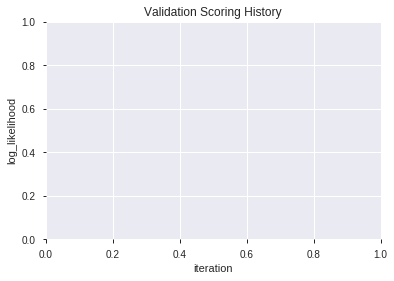

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_134538_model_4  0.842892  0.508033              0.234619  0.409088  0.167353
1  XGBoost_grid_1_AutoML_20190828_134538_model_2  0.840304  0.509976              0.220386  0.410150  0.168223
2  XGBoost_grid_1_AutoML_20190828_134538_model_3  0.838551  0.502514              0.241047  0.407305  0.165897
3               XGBoost_1_AutoML_20190828_134538  0.837633  0.500879              0.222222  0.407569  0.166112
4  XGBoost_grid_1_AutoML_20190828_134538_model_6  0.833792  0.509456              0.231864  0.411568  0.169388
5               XGBoost_3_AutoML_20190828_134538  0.829785  0.507930              0.238292  0.410967  0.168894
6  XGBoost_grid_1_AutoML_20190828_134538_model_1  0.826196  0.509761              0.266299  0.412800  0.170404
7               XGBoost_2_AutoML_20190828_134538  0.818766  0.518918              0.252525  0.417109  0.173980
8  XGBoost_grid_1_AutoML_20190828_134538_model_7  0.818098  0.520686              0.246556  0.417608  0.174397
9  XGBoost_grid_1_AutoML_20190828_134538_model_5  0.808832  0.529817              0.278696  0.423551  0.179395

variable  relative_importance  scaled_importance  percentage
0                       BOP          2195.629395           1.000000    0.409459
1                    TRANGE           804.723511           0.366512    0.150071
2              STOCHF_fastk           480.910645           0.219031    0.089684
3                    ULTOSC           205.064224           0.093397    0.038242
4                     CCI_8           165.244186           0.075261    0.030816
5                   WILLR_8           140.183197           0.063846    0.026143
6                 PLUS_DM_8            94.100838           0.042858    0.017549
7      HT_PHASOR_quadrature            72.875572           0.033191    0.013590
8                aroonup_12            63.305271           0.028832    0.011806
9                     ADOSC            63.268986           0.028816    0.011799
10                  ROCR_20            61.735283           0.028117    0.011513
11              MINUS_DM_24            60.913364           0.027743    0.011360
12                   ATR_30            59.072647           0.026905    0.011016
13                    ATR_8            54.136875           0.024657    0.010096
14                 WILLR_24            52.450745           0.023889    0.009781
15  BBANDS_upperband_20_2_3            50.426781           0.022967    0.009404
16           STOCHRSI_fastd            50.075985           0.022807    0.009339
17  BBANDS_upperband_30_6_5            39.026291           0.017775    0.007278
18                 WILLR_12            37.710129           0.017175    0.007032
19                     DX_8            36.609978           0.016674    0.006827
20               aroonup_24            33.418587           0.015221    0.006232
21                   CCI_24            31.507624           0.014350    0.005876
22              STOCH_slowd            29.321697           0.013355    0.005468
23                  ADXR_12            28.078049           0.012788    0.005236
24           STOCHRSI_fastk            25.511999           0.011619    0.004758
25                  NATR_12            23.726366           0.010806    0.004425
26   LINEARREG_INTERCEPT_14            23.227798           0.010579    0.004332
27               AROONOSC_8            22.849773           0.010407    0.004261
28                   RSI_30            20.994762           0.009562    0.003915
29                    DX_30            19.257765           0.008771    0.003591
30  BBANDS_lowerband_20_6_3            19.163244           0.008728    0.003574
31                   RSI_20            18.459612           0.008407    0.003442
32                   CCI_12            18.276257           0.008324    0.003408
33              CDLLONGLINE            18.047197           0.008220    0.003366
34  BBANDS_upperband_20_6_2            17.693312           0.008058    0.003300
35                   ATR_24            17.356628           0.007905    0.003237
36           MACDEXT_signal            16.390688           0.007465    0.003057
37                   MFI_24            15.872103           0.007229    0.002960
38       LINEARREG_SLOPE_14            15.392308           0.007010    0.002870
39                   BETA_8            14.486937           0.006598    0.002702
40                   ROCR_8            14.270609           0.006500    0.002661
41              AROONOSC_24            14.122207           0.006432    0.002634
42        LINEARREG_SLOPE_8            12.903860           0.005877    0.002406
43               PLUS_DI_20            12.648172           0.005761    0.002359
44                    RSI_8            12.416948           0.005655    0.002316
45              MINUS_DI_24            12.358895           0.005629    0.002305
46                  BETA_14            11.324220           0.005158    0.002112
47              AROONOSC_14            10.656984           0.004854    0.001987
48                  ROCR_14            10.343335           0.004711    0.001929
49                 

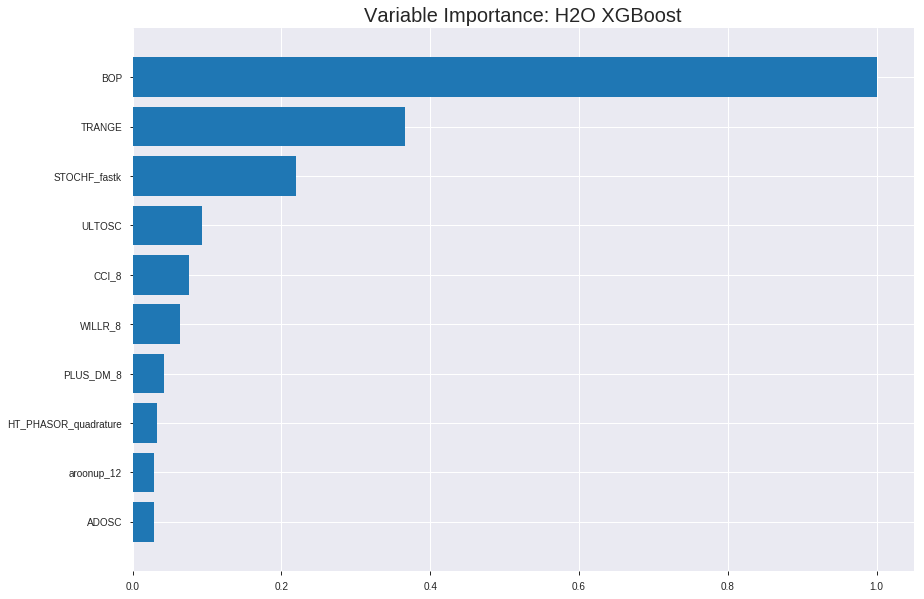

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_134538_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15822439583765857
RMSE: 0.3977743026361288
LogLoss: 0.48839878024458877
Mean Per-Class Error: 0.2154082440527767
AUC: 0.8598957855499717
pr_auc: 0.8473271018797548
Gini: 0.7197915710999434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39614351391792296: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      521  268  0.3397   (268.0/789.0)
1      88   658  0.118    (88.0/746.0)
Total  609  926  0.2319   (356.0/1535.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396144     0.787081  245
max f2                       0.260912     0.862895  316
max f0point5                 0.581895     0.78754   156
max accuracy                 0.514064     0.785016  190
max precision                0.906806     1         0
max recall                   0.126324     1         380
max specificity              0.906806     1         0
max absolute_mcc             0.514064     0.56957   190
max min_per_class_accuracy   0.496174     0.782003  198
max mean_per_class_accuracy  0.514064     0.784592  190

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.62 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104235                   0.878593           2.05764    2.05764            1                0.888744  1                           0.888744            0.0214477       0.0214477                  105.764   105.764
    2        0.0201954                   0.868364           2.05764    2.05764            1                0.873707  1                           0.881468            0.0201072       0.041555                   105.764   105.764
    3        0.0306189                   0.858736           1.92904    2.01386            0.9375           0.863355  0.978723                    0.875302            0.0201072       0.0616622                  92.9038   101.386
    4        0.0403909                   0.853093           2.05764    2.02445            1                0.855714  0.983871                    0.870563            0.0201072       0.0817694                  105.764   102.445
    5        0.0501629                   0.845043           2.05764    2.03092            1                0.848944  0.987013                    0.866351            0.0201072       0.101877                   105.764   103.092
    6        0.100326                    0.812158           1.87058    1.95075            0.909091         0.828653  0.948052                    0.847502            0.0938338       0.19571                    87.0583   95.075
    7        0.150489                    0.779476           1.81714    1.90621            0.883117         0.795788  0.926407                    0.830264            0.0911528       0.286863                   81.7137   90.6213
    8        0.2                         0.735855           1.73275    1.86327            0.842105         0.75865   0.905537                    0.812536            0.0857909       0.372654                   73.275    86.3271
    9        0.300326                    0.652305           1.61672    1.78091            0.785714         0.693695  0.86551                     0.772836            0.162198        0.534853                   61.6718   78.0908
    10       0.4                         0.573579           1.41211    1.68901            0.686275         0.613543  0.820847                    0.733142            0.140751        0.675603                   41.2106   68.9008
    11       0.500326                    0.486113           1.14907    1.58074            0.558442         0.533223  0.768229                    0.693054            0.115282        0.790885                   14.9072   58.074
    12       0.6                         0.397176           0.88761    1.46559            0.431373         0.443075  0.712269                    0.651527            0.0884718       0.879357                   -11.239   46.5594
    13       0.699674                    0.319842           0.511048   1.32961            0.248366         0.359472  0.646182                    0.609921            0.0509383       0.930295                   -48.8952  32.9611
    14       0.8                         0.234933           0.427562   1.21649            0.207792         0.279666  0.591205                    0.568505            0.0428954       0.97319                    -57.2438  21.6488
    15       0.899674                    0.152219           0.201729   1.10406            0.0980392        0.187534  0.536568                    0.526297            0.0201072       0.993298                   -79.8271  10.4064
    16       1                           0.0884902          0.0668065  1                  0.0324675        0.12613   0.485993                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19244998096705995
RMSE: 0.4386912136880108
LogLoss: 0.5661734892359452
Mean Per-Class Error: 0.29560444147603937
AUC: 0.778061863416263
pr_auc: 0.757256874903859
Gini: 0.5561237268325261
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3069879710674286: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      101  111  0.5236   (111.0/212.0)
1      17   209  0.0752   (17.0/226.0)
Total  118  320  0.2922   (128.0/438.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306988     0.765568  289
max f2                       0.211793     0.861244  317
max f0point5                 0.646924     0.725806  129
max accuracy                 0.409953     0.707763  243
max precision                0.895859     1         0
max recall                   0.120591     1         382
max specificity              0.895859     1         0
max absolute_mcc             0.306988     0.451919  289
max min_per_class_accuracy   0.492223     0.683962  199
max mean_per_class_accuracy  0.409953     0.704396  243

Gains/Lift Table: Avg response rate: 51.60 %, avg score: 48.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0114155                   0.880742           1.55044   1.55044            0.8              0.891295  0.8                         0.891295            0.0176991       0.0176991                  55.0442   55.0442
    2        0.0205479                   0.869829           1.45354   1.50737            0.75             0.875498  0.777778                    0.884274            0.0132743       0.0309735                  45.354    50.7375
    3        0.0319635                   0.86281            1.93805   1.66119            1                0.865142  0.857143                    0.877441            0.0221239       0.0530973                  93.8053   66.1188
    4        0.0410959                   0.857742           1.93805   1.72271            1                0.861036  0.888889                    0.873796            0.0176991       0.0707965                  93.8053   72.2714
    5        0.0502283                   0.847739           1.93805   1.76187            1                0.852616  0.909091                    0.869945            0.0176991       0.0884956                  93.8053   76.1866
    6        0.100457                    0.813529           1.40949   1.58568            0.727273         0.834541  0.818182                    0.852243            0.0707965       0.159292                   40.9493   58.568
    7        0.150685                    0.771837           1.76187   1.64441            0.909091         0.794812  0.848485                    0.833099            0.0884956       0.247788                   76.1866   64.4409
    8        0.200913                    0.730339           1.49759   1.6077             0.772727         0.747823  0.829545                    0.81178             0.0752212       0.323009                   49.7586   60.7703
    9        0.30137                     0.661574           1.49759   1.571              0.772727         0.690359  0.810606                    0.771307            0.150442        0.473451                   49.7586   57.0998
    10       0.399543                    0.582468           1.0817    1.45077            0.55814          0.627386  0.748571                    0.735943            0.106195        0.579646                   8.17041   45.0771
    11       0.5                         0.499535           0.969027  1.35398            0.5              0.539608  0.69863                     0.696497            0.0973451       0.676991                   -3.09735  35.3982
    12       0.600457                    0.417359           1.18926   1.32642            0.613636         0.458672  0.684411                    0.656709            0.119469        0.79646                    18.926    32.6424
    13       0.69863                     0.323251           0.90142   1.2667             0.465116         0.367449  0.653595                    0.616061            0.0884956       0.884956                   -9.858    26.6701
    14       0.799087                    0.2114             0.704747  1.19606            0.363636         0.281888  0.617143                    0.574051            0.0707965       0.955752                   -29.5253  19.6056
    15       0.899543                    0.144849           0.220233  1.08708            0.113636         0.172566  0.560914                    0.529215            0.0221239       0.977876                   -77.9767  8.70805
    16       1                           0.0974959          0.220233  1                  0.113636         0.124469  0.515982                    0.488556          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:45:47  3.440 sec   0                  0.5              0.693147            0.5             0                  1                0.514007                         0.5                0.693147              0.5               0                    1                  0.484018
    2019-08-28 13:45:47  3.562 sec   5                  0.474095         0.642333            0.80932         0.711738           1.97308          0.309446                         0.478001           0.649804              0.765633          0.699647             1.61504            0.333333
    2019-08-28 13:45:47  3.617 sec   10                 0.455697         0.606653            0.817089        0.716762           1.97308          0.247557                         0.464385           0.622958              0.767866          0.691613             1.61504            0.33105
    2019-08-28 13:45:47  3.674 sec   15                 0.442955         0.581686            0.822617        0.80308            2.05764          0.264495                         0.453938           0.601957              0.773491          0.745987             1.66119            0.305936
    2019-08-28 13:45:47  3.734 sec   20                 0.432578         0.560976            0.828248        0.812875           2.05764          0.27557                          0.447896           0.58912               0.775776          0.746307             1.66119            0.310502
    2019-08-28 13:45:47  3.795 sec   25                 0.425325         0.546056            0.832797        0.820646           2.05764          0.263192                         0.443945           0.580139              0.776653          0.757152             1.66119            0.308219
    2019-08-28 13:45:47  3.870 sec   30                 0.419942         0.534769            0.836036        0.822578           2.05764          0.2443                           0.442372           0.57621               0.77515           0.754333             1.66119            0.308219
    2019-08-28 13:45:47  3.934 sec   35                 0.415483         0.525434            0.840031        0.826534           2.05764          0.250163                         0.441207           0.573088              0.775589          0.754214             1.55044            0.305936
    2019-08-28 13:45:47  4.001 sec   40                 0.411666         0.517504            0.844447        0.831988           2.05764          0.231922                         0.440642           0.571396              0.775213          0.751896             1.55044            0.287671
    2019-08-28 13:45:47  4.074 sec   45                 0.408405         0.510361            0.847473        0.835012           2.05764          0.241042                         0.439974           0.569586              0.77635           0.752981             1.55044            0.303653
    2019-08-28 13:45:47  4.147 sec   50                 0.405216         0.503773            0.850972        0.838144           2.05764          0.228664                         0.439215           0.568079              0.776256          0.754076             1.55044            0.303653
    2019-08-28 13:45:47  4.220 sec   55                 0.402538         0.498131            0.854048        0.841234           2.05764          0.228664                         0.438922           0.567299              0.777091          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
BOP                      2195.62939453125       1.0                    0.4094589817362291
TRANGE                   804.7235107421875      0.366511540037926      0.15007144197850633
STOCHF_fastk             480.91064453125        0.219030882775151      0.08968416222990068
ULTOSC                   205.06422424316406     0.09339655624666279    0.03824205881842899
CCI_8                    165.2441864013672      0.07526050927034776    0.030816091490786623
---                      ---                    ---                    ---
WILLR_14                 8.684261322021484      0.003955249161653489   0.0016195122942437112
MA_30_5                  8.368057250976562      0.003811233932201513   0.0015605439650377957
BBANDS_lowerband_24_0_4  8.075605392456055      0.0036780366543508287  0.001506005143279017
PLUS_DM_20               5.439222812652588      0.002477295497227491   0.0010143508917545138
WILLR_30                 4.160478591918945      0.001894891096959091   0.0007758801790619155


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7636363636363637)

('F1', 0.7679324894514767)

('auc', 0.8428917271892479)

('logloss', 0.5080325472852433)

('mean_per_class_error', 0.23232323232323226)

('rmse', 0.40908751529750464)

('mse', 0.1673525951722861)

xgboost prediction progress: |████████████████████████████████████████████| 100%


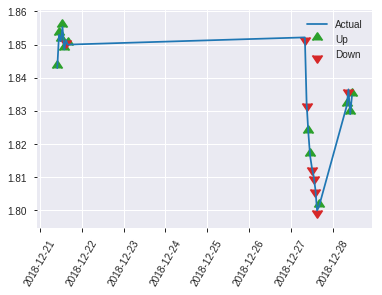


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1673525951722861
RMSE: 0.40908751529750464
LogLoss: 0.5080325472852433
Mean Per-Class Error: 0.23232323232323226
AUC: 0.8428917271892479
pr_auc: 0.8090768424445369
Gini: 0.6857834543784957
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3493896424770355: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   47   0.3884   (47.0/121.0)
1      8    91   0.0808   (8.0/99.0)
Total  82   138  0.25     (55.0/220.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.34939      0.767932  137
max f2                       0.297211     0.857664  151
max f0point5                 0.564259     0.754717  67
max accuracy                 0.428711     0.763636  112
max precision                0.878498     1         0
max recall                   0.150564     1         195
max specificity              0.878498     1         0
max absolute_mcc             0.34939      0.546089  137
max min_per_class_accuracy   0.458863     0.752066  104
max mean_per_class_accuracy  0.428711     0.767677  112

Gains/Lift Table: Avg response rate: 45.00 %, avg score: 43.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0136364                   0.870719           2.22222   2.22222            1                0.874104  1                           0.874104            0.030303        0.030303                   122.222   122.222
    2        0.0227273                   0.853081           2.22222   2.22222            1                0.862055  1                           0.869285            0.020202        0.0505051                  122.222   122.222
    3        0.0318182                   0.840594           2.22222   2.22222            1                0.846258  1                           0.862706            0.020202        0.0707071                  122.222   122.222
    4        0.0409091                   0.835501           2.22222   2.22222            1                0.839253  1                           0.857494            0.020202        0.0909091                  122.222   122.222
    5        0.05                        0.824592           2.22222   2.22222            1                0.830262  1                           0.852543            0.020202        0.111111                   122.222   122.222
    6        0.1                         0.734236           2.22222   2.22222            1                0.779077  1                           0.81581             0.111111        0.222222                   122.222   122.222
    7        0.15                        0.684107           1.41414   1.95286            0.636364         0.714513  0.878788                    0.782044            0.0707071       0.292929                   41.4141   95.2862
    8        0.2                         0.651214           1.61616   1.86869            0.727273         0.66876   0.840909                    0.753723            0.0808081       0.373737                   61.6162   86.8687
    9        0.3                         0.56651            1.71717   1.81818            0.772727         0.601991  0.818182                    0.703146            0.171717        0.545455                   71.7172   81.8182
    10       0.4                         0.480663           1.11111   1.64141            0.5              0.52903   0.738636                    0.659617            0.111111        0.656566                   11.1111   64.1414
    11       0.5                         0.432984           1.21212   1.55556            0.545455         0.465205  0.7                         0.620734            0.121212        0.777778                   21.2121   55.5556
    12       0.6                         0.356608           1.0101    1.46465            0.454545         0.395006  0.659091                    0.583113            0.10101         0.878788                   1.0101    46.4646
    13       0.7                         0.288914           0.707071  1.35642            0.318182         0.324409  0.61039                     0.546155            0.0707071       0.949495                   -29.2929  35.6421
    14       0.8                         0.228631           0.20202   1.21212            0.0909091        0.259904  0.545455                    0.510374            0.020202        0.969697                   -79.798   21.2121
    15       0.9                         0.148103           0.30303   1.11111            0.136364         0.187082  0.5                         0.474452            0.030303        1                          -69.697   11.1111
    16       1                           0.0836887          0         1                  0                0.128173  0.45                        0.439824         

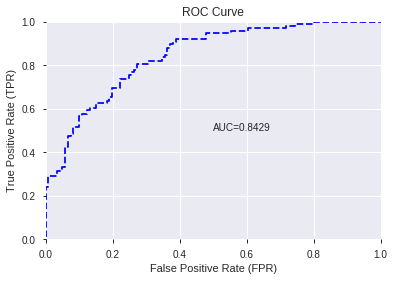

This function is available for GLM models only


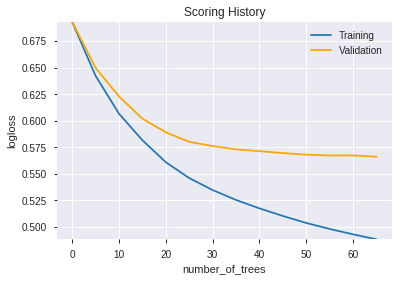

--2019-08-28 13:45:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_134538_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_134538_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9e80',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ULTOSC',
 'CCI_8',
 'WILLR_8',
 'PLUS_DM_8',
 'HT_PHASOR_quadrature',
 'aroonup_12',
 'ADOSC',
 'ROCR_20',
 'MINUS_DM_24',
 'ATR_30',
 'ATR_8',
 'WILLR_24',
 'BBANDS_upperband_20_2_3',
 'STOCHRSI_fastd',
 'BBANDS_upperband_30_6_5',
 'WILLR_12',
 'DX_8',
 'aroonup_24',
 'CCI_24',
 'STOCH_slowd',
 'ADXR_12',
 'STOCHRSI_fastk',
 'NATR_12',
 'LINEARREG_INTERCEPT_14',
 'AROONOSC_8',
 'RSI_30',
 'DX_30',
 'BBANDS_lowerband_20_6_3',
 'RSI_20',
 'CCI_12',
 'CDLLONGLINE',
 'BBANDS_upperband_20_6_2',
 'ATR_24',
 'MACDEXT_signal',
 'MFI_24',
 'LINEARREG_SLOPE_14',
 'BETA_8',
 'ROCR_8',
 'AROONOSC_24',
 'LINEARREG_SLOPE_8',
 'PLUS_DI_20',
 'RSI_8',
 'MINUS_DI_24',
 'BETA_14',
 'AROONOSC_14',
 'ROCR_14',
 'WILLR_14',
 'MA_30_5',
 'BBANDS_lowerband_24_0_4',
 'PLUS_DM_20',
 'WILLR_30']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.773
GLM             0.786
XGBoost         0.764
dtype: float64

DeepLearning    GLM  XGBoost
All          0.764  0.755    0.759
DLF          0.773  0.777    0.755
Fwe          0.755  0.786    0.755
RFE          0.755  0.782    0.764
XGBF         0.773  0.777    0.755





F1


DeepLearning    0.761
GLM             0.772
XGBoost         0.773
dtype: float64

DeepLearning    GLM  XGBoost
All          0.748  0.736    0.767
DLF          0.761  0.772    0.763
Fwe          0.750  0.768    0.773
RFE          0.750  0.769    0.768
XGBF         0.756  0.772    0.763





auc


DeepLearning    0.841
GLM             0.844
XGBoost         0.844
dtype: float64

DeepLearning    GLM  XGBoost
All          0.821  0.820    0.839
DLF          0.841  0.836    0.841
Fwe          0.836  0.844    0.844
RFE          0.827  0.837    0.843
XGBF         0.837  0.836    0.841





logloss


DeepLearning    0.528
GLM             0.527
XGBoost         0.511
dtype: float64

DeepLearning    GLM  XGBoost
All          0.528  0.527    0.511
DLF          0.502  0.507    0.498
Fwe          0.496  0.494    0.492
RFE          0.500  0.504    0.508
XGBF         0.507  0.507    0.498





mean_per_class_error


DeepLearning    0.252
GLM             0.250
XGBoost         0.238
dtype: float64

DeepLearning    GLM  XGBoost
All          0.239  0.250    0.232
DLF          0.226  0.217    0.238
Fwe          0.250  0.213    0.230
RFE          0.252  0.218    0.232
XGBF         0.229  0.217    0.238





rmse


DeepLearning    0.423
GLM             0.419
XGBoost         0.411
dtype: float64

DeepLearning    GLM  XGBoost
All          0.423  0.419    0.411
DLF          0.409  0.409    0.407
Fwe          0.408  0.403    0.404
RFE          0.412  0.408    0.409
XGBF         0.408  0.409    0.407





mse


DeepLearning    0.179
GLM             0.176
XGBoost         0.169
dtype: float64

DeepLearning    GLM  XGBoost
All          0.179  0.176    0.169
DLF          0.167  0.167    0.165
Fwe          0.166  0.162    0.163
RFE          0.169  0.166    0.167
XGBF         0.167  0.167    0.165

{'F1':       DeepLearning    GLM  XGBoost
 All          0.748    NaN      NaN
 DLF          0.761    NaN      NaN
 DLF            NaN  0.772      NaN
 DLF            NaN    NaN    0.763
 All            NaN  0.736      NaN
 All            NaN    NaN    0.767
 XGBF         0.756    NaN      NaN
 XGBF           NaN  0.772      NaN
 XGBF           NaN    NaN    0.763
 Fwe          0.750    NaN      NaN
 Fwe            NaN  0.768      NaN
 Fwe            NaN    NaN    0.773
 RFE          0.750    NaN      NaN
 RFE            NaN  0.769      NaN
 RFE            NaN    NaN    0.768,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.764    NaN      NaN
 DLF          0.773    NaN      NaN
 DLF            NaN  0.777      NaN
 DLF            NaN    NaN    0.755
 All            NaN  0.755      NaN
 All            NaN    NaN    0.759
 XGBF         0.773    NaN      NaN
 XGBF           NaN  0.777      NaN
 XGBF           NaN    NaN    0.755
 Fwe          0.755    NaN      NaN
 Fwe     